In [1]:
import sys
sys.path.insert(0, '/home/xu.chao/cantera/build')
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
import cantera as ct

In [2]:
# read the surface species names for plotting
yaml_file = '../base_original/base_modified_pt.yaml'
gas = ct.Solution(yaml_file, 'gas')
surf = ct.Interface(yaml_file, 'surface1', [gas])
species = surf.species()

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in cp/R detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  10.615319744584205
	Value computed using high-temperature polynomial: 10.773680323194302

  after removing the cwd from sys.path.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in h/RT detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  -16.685067677440152
	Value computed using high-temperature polynomial: -16.696975757668092

  after removing the cwd from sys.path.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: NasaPoly2::validate: 
For species CH4OX(43), discontinuity in cp/R detected at Tmid = 850.41
	Value computed using low-temperature polynomi

In [3]:
metals = {'Pt': {'C':-7.02516, 'O':-3.81153}, 'Pd':{'C':-7.16786, 'O':-4.13577}, 'Rh':{'C':(-6.65 - 7.11) / 2, 'O':(-4.31 - 4.88) / 2}, 'Ni': {'C':-6.79794, 'O':-4.98902}}
metal_x = []
metal_y = []
metal_names = []
for i, v in metals.items():
    metal_x.append(abs(v['C'] + 7.5) / 2.25 * 9)
    metal_y.append(abs(v['O'] + 3.125) / 2.25 * 9)
    metal_names.append(i)

def heat_map_gen(sp, property_, ratio, threshold, plot=False, title_name=False):
    """
    sp: index of species
    property_: index of the property to plot
    ratio: the C/O input ratio
    threshold: threshold to rule out the outliers
    """
    benergy_c = np.arange(-7.5, -5.25, 0.25)
    benergy_o = np.arange(-3.25, -5.5, -0.25)
    data_original = np.zeros((len(benergy_c), len(benergy_o)))
    data_bm = np.zeros((len(benergy_c), len(benergy_o)))
    parent_dir = os.path.dirname(os.getcwd())
    # read the first file to extract the species and properties list
    f = f'{parent_dir}/base_original/binding_energies/1.0_c-5.50o-3.25/thermo_sensitivity_data/0.6_sens_data.csv'
    df = pd.read_csv(f)
#     species = df.loc[:, 'Species'].to_list()
    properties = df.columns.to_list()
    
    total = 81
    i = -1
    paths = []
    for c_binding_energy in benergy_c:
        i += 1
        j = -1
        index = total - ((7.5 - abs(c_binding_energy)) / 0.25 + 1) * 9
        for o_binding_energy in benergy_o:
            j += 1
            index += 1

     
            # read the simulation files
            original_path_sens = '{}/base_original/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
            if os.path.exists(original_path_sens):
                df_original = pd.read_csv(original_path_sens)
                charac_sens_original = df_original.loc[df_original['Species'] == sp].iloc[:,property_].to_list()[0]
                if abs(charac_sens_original) >= threshold:
                    data_original[j][i] = 0
                else:
                    data_original[j][i] = charac_sens_original

            bm_path_sens = '{}/base_bm/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
            if os.path.exists(bm_path_sens):
                df_bm = pd.read_csv(bm_path_sens)
                charac_sens_bm = df_bm.loc[df_bm['Species'] == sp].iloc[:,property_].to_list()[0]
                if abs(charac_sens_bm) >= threshold:
                    data_bm[j][i] = 0
                else:
                    data_bm[j][i] = charac_sens_bm
                    
    original_df = pd.DataFrame(data_original, columns=benergy_c, index=benergy_o)
    bm_df = pd.DataFrame(data_bm, columns=benergy_c, index=benergy_o)
    minimum = min(original_df.min().min(), bm_df.min().min())
    maximum = max(original_df.max().max(), bm_df.max().max())
    sns.set_style("darkgrid")
    plt.rcParams.update({'font.size': 36})
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121, aspect='equal')
    ax2 = fig.add_subplot(122, aspect='equal')
    # cmap = sns.color_palette("viridis", as_cmap=True)
    cmap = sns.color_palette("Spectral", as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    ax1 = sns.heatmap(original_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax1, vmin=minimum, vmax=maximum, cbar=False)
    if title_name:
        ax1.set(title="original models {} sensitivity of {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    else:
        ax1.set(title=None,
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    ax1.title.set_size(12)
    ax1.scatter(metal_x, metal_y, marker='*', color='black')
    for i, txt in enumerate(metal_names):
        ax1.annotate(txt,(metal_x[i], metal_y[i]))
    cbar_ax = fig.add_axes([1, 0, .03, 1])
    ax2 = sns.heatmap(bm_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax2, vmin=minimum, vmax=maximum, cbar_ax=cbar_ax)
    if title_name:
        ax2.set(title="bm models {} sensitivity of species {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    else:
        ax2.set(title=None,
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)    
    ax2.title.set_size(12)
    ax2.scatter(metal_x, metal_y, marker='*', color='black')
    for i, txt in enumerate(metal_names):
        ax2.annotate(txt,(metal_x[i], metal_y[i]))
    xticks1 = ax1.xaxis.get_major_ticks()
    yticks1 = ax1.yaxis.get_major_ticks()
    xticks2 = ax2.xaxis.get_major_ticks()
    yticks2 = ax2.yaxis.get_major_ticks()
    for i in range(len(xticks1)-1):
        if i % 2 != 0:
            xticks1[i].label1.set_visible(False)
            xticks2[i].label1.set_visible(False)
    for i in range(len(yticks1)-1):
        if i % 2 != 0:
            yticks1[i].label1.set_visible(False)
            yticks2[i].label1.set_visible(False)
    plt.tight_layout()
    plt.plot()
    if plot == True:
        plt.savefig(f'therm_sens_plots/{ratio}_{species[sp].name}_{properties[property_]}.pdf', bbox_inches='tight')

In [4]:
metals = {'Pt': {'C':-7.02516, 'O':-3.81153}, 'Pd':{'C':-7.16786, 'O':-4.13577}, 'Rh':{'C':(-6.65 - 7.11) / 2, 'O':(-4.31 - 4.88) / 2}, 'Ni': {'C':-6.79794, 'O':-4.98902}}
metal_x = []
metal_y = []
metal_names = []
for i, v in metals.items():
    metal_x.append(abs(v['C'] + 7.5) / 2.25 * 9)
    metal_y.append(abs(v['O'] + 3.125) / 2.25 * 9)
    metal_names.append(i)

def heat_map_gen(sp, property_, ratio, threshold, plot=False, title_name=False, minimum=1e9, maximum=1e-9, print_data=False):
    """
    This only plot for one property at a time vertically
    rxn: index of reations
    property_: index of the property to plot
    ratio: the C/O input ratio
    threshold: threshold to rule out the outliers
    """
    benergy_c = np.arange(-7.5, -5.25, 0.25)
    benergy_o = np.arange(-3.25, -5.5, -0.25)
    data_original = np.zeros((len(benergy_c), len(benergy_o)))
    data_bm = np.zeros((len(benergy_c), len(benergy_o)))
    # parent_dir = os.path.dirname(os.getcwd())
    parent_dir = '/work/westgroup/chao/sketches/cpox_sim/bm_models_final'
    # read the first file to extract the species and properties list
    f = f'{parent_dir}/base_original/binding_energies/1.0_c-5.50o-3.25/kinetic_sensitivity_data/0.6_sens_data.csv'
    df = pd.read_csv(f)
#     species = df.loc[:, 'Species'].to_list()
    properties = df.columns.to_list()
    
    total = 81
    i = -1
    paths = []
    for c_binding_energy in benergy_c:
        i += 1
        j = -1
        index = total - ((7.5 - abs(c_binding_energy)) / 0.25 + 1) * 9
        for o_binding_energy in benergy_o:
            j += 1
            index += 1

     
            # read the simulation files
            original_path_sens = '{}/base_original/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
            if os.path.exists(original_path_sens):
                df_original = pd.read_csv(original_path_sens)
                charac_sens_original = df_original.loc[df_original['Species'] == sp].iloc[:,property_].to_list()[0]
                if abs(charac_sens_original) >= threshold:
                    data_original[j][i] = charac_sens_original / abs(charac_sens_original) * threshold
                else:
                    data_original[j][i] = charac_sens_original

            bm_path_sens = '{}/base_bm/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
            if os.path.exists(bm_path_sens):
                df_bm = pd.read_csv(bm_path_sens)
                charac_sens_bm = df_bm.loc[df_bm['Species'] == sp].iloc[:,property_].to_list()[0]
                if abs(charac_sens_bm) >= threshold:
                    data_bm[j][i] = charac_sens_bm / abs(charac_sens_bm) * threshold
                else:
                    data_bm[j][i] = charac_sens_bm               
    # original_df = pd.DataFrame(data_original/abs(data_original.max()-data_original.min()), columns=benergy_c, index=benergy_o)
    # bm_df = pd.DataFrame(data_bm/abs(data_bm.max()-data_bm.min()), columns=benergy_c, index=benergy_o)
    original_df = pd.DataFrame(data_original, columns=benergy_c, index=benergy_o)
    bm_df = pd.DataFrame(data_bm, columns=benergy_c, index=benergy_o)
    if print_data:
        print(original_df)
        print(bm_df)
    if minimum == 1e9:
        minimum = min(original_df.min().min(), bm_df.min().min())
    if maximum == 1e-9:
        maximum = max(original_df.max().max(), bm_df.max().max())
    sns.set_style("darkgrid")
    plt.rcParams.update({'font.size': 36})
    fig, axs = plt.subplots(2, 1, figsize=(9, 18))
    ax1 = axs[0]
    ax2 = axs[1]
    # ax1 = fig.add_subplot(121, aspect='equal')
    # ax2 = fig.add_subplot(122, aspect='equal')
    # cmap = sns.color_palette("viridis", as_cmap=True)
    # cmap = sns.color_palette("Spectral", as_cmap=True)
    cmap = sns.diverging_palette(250, 10,center='light', as_cmap=True)
    # cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
    # cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    # ax1 = sns.heatmap(original_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax1, cbar=False)
    ax1 = sns.heatmap(original_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax1, vmin=minimum, vmax=maximum, cbar=False)
    if title_name:
        ax1.set(title="original models {} sensitivity of {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    # print("Original models {} sensitivity of \n {} \n at C/O={}".format(properties[property_], rxns[rxn].equation, ratio), rxn)
    else:
        ax1.set(title=None,
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    ax1.scatter(metal_x, metal_y, marker='*', color='black')
    for i, txt in enumerate(metal_names):
        ax1.annotate(txt,(metal_x[i], metal_y[i]))
    # ax1.xaxis.label.set_size(20)
    # ax1.yaxis.label.set_size(20)
    ax1.title.set_size(18)
    cbar_ax = fig.add_axes([0.2, 0, 0.8, 0.02])
    ax2 = sns.heatmap(bm_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax2, vmin=minimum, vmax=maximum, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})
    if title_name:
        ax2.set(title="bm models {} sensitivity of species {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
              xlabel="$\\Delta E^C(ev)$",
              ylabel="$\\Delta E^O(ev)$",)
    # print("BMA models {} sensitivity of \n {} \n at C/O={}".format(properties[property_], rxns[rxn].equation, ratio))
    else:
        ax2.set(title=None,
          xlabel="$\\Delta E^C(ev)$",
          ylabel="$\\Delta E^O(ev)$",)
    ax2.scatter(metal_x, metal_y, marker='*', color='black')
    for i, txt in enumerate(metal_names):
        ax2.annotate(txt,(metal_x[i], metal_y[i]))
    # ax2.xaxis.label.set_size(20)
    # ax2.yaxis.label.set_size(20)
    ax2.title.set_size(18)
    xticks1 = ax1.xaxis.get_major_ticks()
    yticks1 = ax1.yaxis.get_major_ticks()
    xticks2 = ax2.xaxis.get_major_ticks()
    yticks2 = ax2.yaxis.get_major_ticks()
    for i in range(len(xticks1)-1):
        if i % 2 != 0:
            xticks1[i].label1.set_visible(False)
            xticks2[i].label1.set_visible(False)
    for i in range(len(yticks1)-1):
        if i % 2 != 0:
            yticks1[i].label1.set_visible(False)
            yticks2[i].label1.set_visible(False)
    plt.tight_layout()
    plt.plot()
    if plot == True:
        plt.savefig(f'therm_sens_plots/{ratio}_{species[sp].name}_{properties[property_]}.pdf', bbox_inches='tight')

       -7.50     -7.25     -7.00      -6.75      -6.50     -6.25     -6.00  \
-3.25    0.0  0.000932  0.005410   0.001014  -0.013019  0.232309 -0.010081   
-3.50    0.0  0.027215  0.053648   0.009118   0.002786 -0.021330 -0.020311   
-3.75    0.0  0.183931  0.345185   0.065445   0.017856  0.002576 -0.004100   
-4.00    0.0  0.156795  0.292187   0.028832   0.010356 -0.014707 -0.256110   
-4.25    0.0  0.022571  0.039414   0.001181  -0.020941 -0.814800 -1.800680   
-4.50    0.0  0.000706  0.000526  -0.060398 -10.970220 -3.991140 -3.104837   
-4.75    0.0  0.000021  0.000147 -10.210438  -8.142347 -5.656991 -4.747396   
-5.00    0.0  0.000003  0.000028  -8.705492  -7.218850 -6.779292 -7.504115   
-5.25    0.0  0.000002 -0.000023  -6.100377  -6.409881 -7.903131 -8.565515   

          -5.75     -5.50  
-3.25  0.001066  0.003578  
-3.50  0.009045  0.002863  
-3.75  0.004596 -0.010070  
-4.00 -0.222175 -0.201484  
-4.25 -1.124706 -0.925144  
-4.50 -2.935100 -2.900002  
-4.75 -4.428292 -4.3028

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


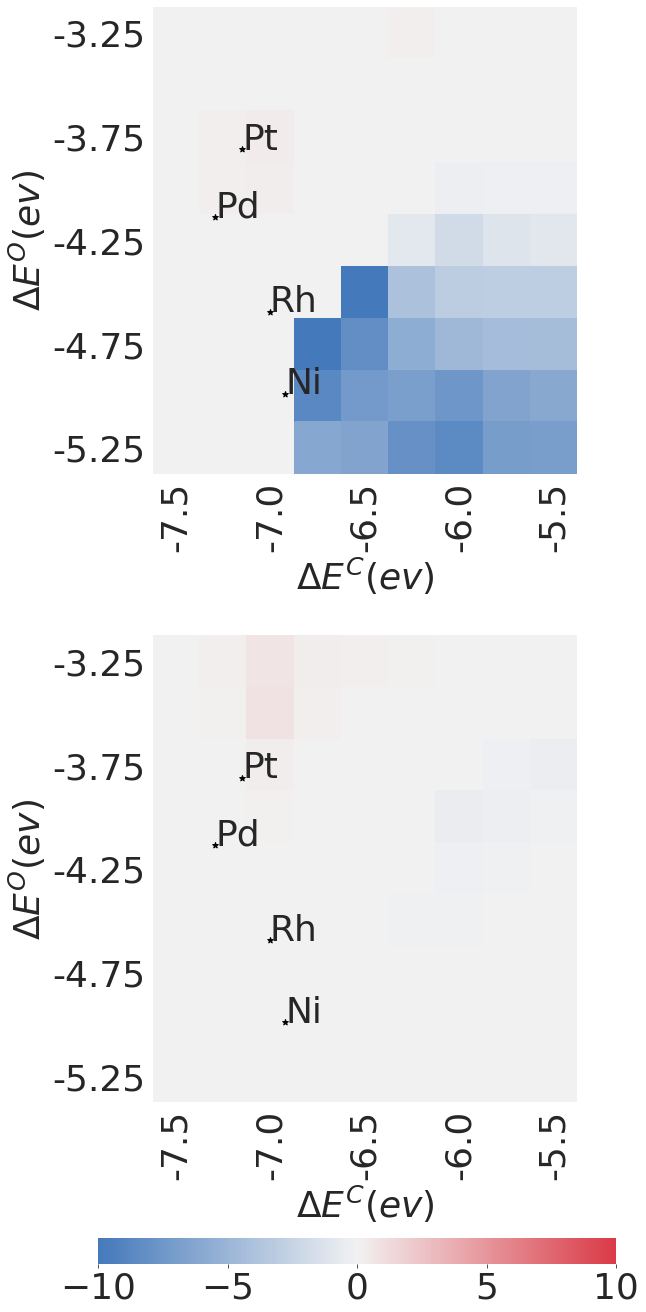

In [5]:
heat_map_gen(12, 8, 1.0, 20, minimum=-10, maximum=10, plot=False, print_data=True)

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


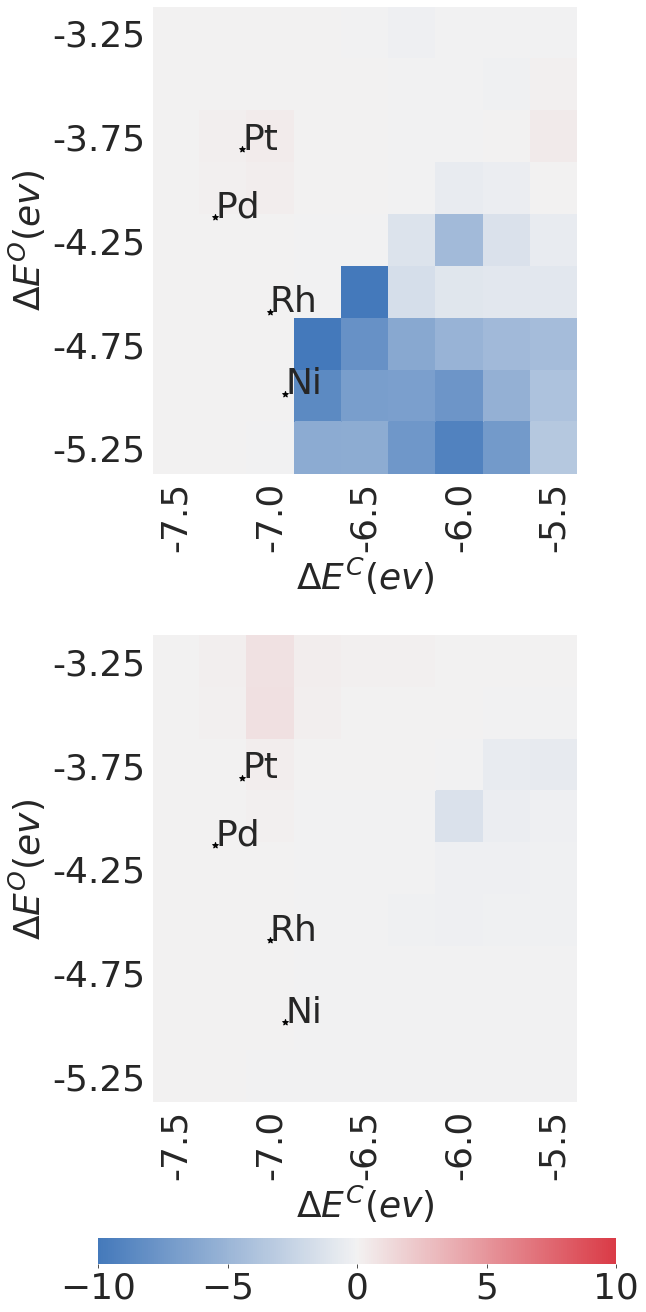

In [35]:
heat_map_gen(12, 3, 1.0, 20, minimum=-10, maximum=10, plot=True)

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


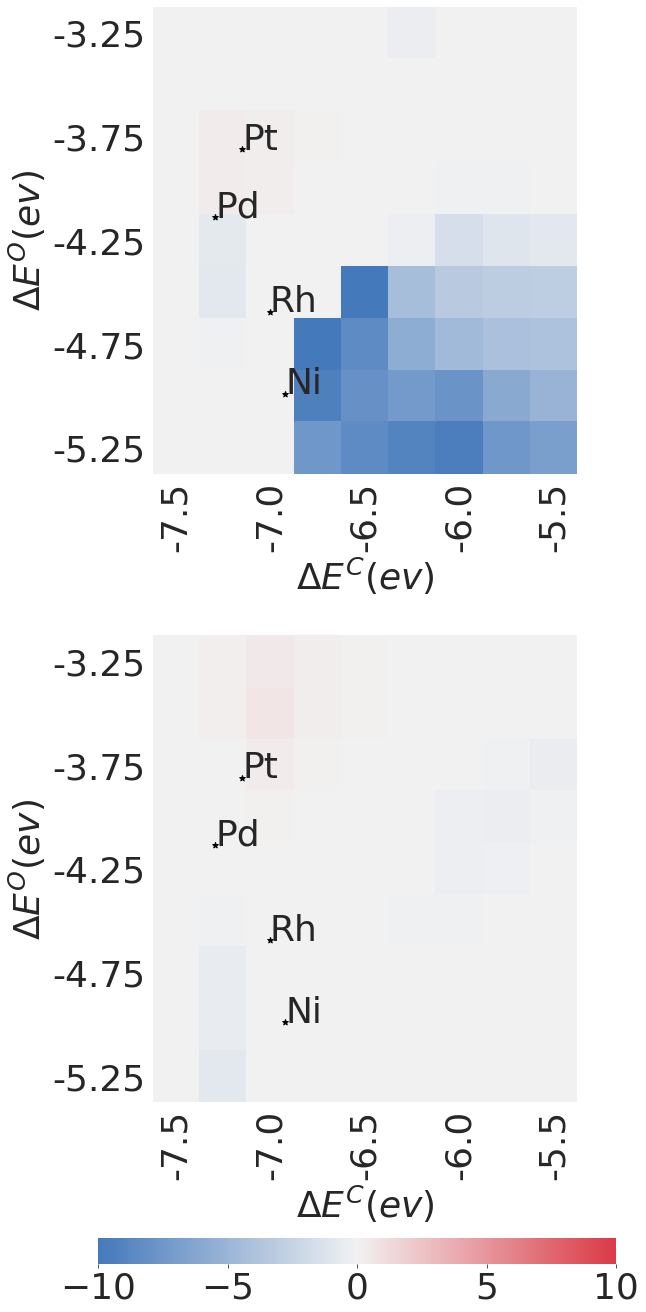

In [31]:
heat_map_gen(12, 10, 1.0, 20, minimum=-10, maximum=10, plot=True)

       -7.50         -7.25         -7.00         -6.75     -6.50     -6.25  \
-3.25    0.0 -9.511643e-08 -1.132486e-07  3.011980e-07  0.000099  0.003301   
-3.50    0.0 -2.344948e-07  9.280508e-07  3.904882e-07  0.000012  0.001095   
-3.75    0.0  1.073518e-06  3.838864e-05  1.672942e-05 -0.000018  0.000760   
-4.00    0.0  7.452414e-06  3.689220e-04  4.045509e-05 -0.000271 -0.003120   
-4.25    0.0  9.523092e-06  6.726830e-04 -3.200288e-04 -0.014127 -0.696909   
-4.50    0.0  1.953790e-06  2.554551e-04 -8.417670e-03 -3.562595 -6.197249   
-4.75    0.0  5.379537e-07  4.732293e-04 -1.184675e+00 -1.236067 -3.606378   
-5.00    0.0  3.114343e-07  1.387482e-04 -8.084282e-01 -0.794028 -0.872833   
-5.25    0.0  1.536261e-06 -1.985433e-04 -6.232029e-01 -0.613076 -0.750520   

          -6.00     -5.75     -5.50  
-3.25  0.009058  0.013175  0.013697  
-3.50  0.003977  0.004824  0.007436  
-3.75  0.004855  0.000392  0.006685  
-4.00 -0.036819 -0.082311 -0.063510  
-4.25 -3.726788 -3.895347 -3.

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


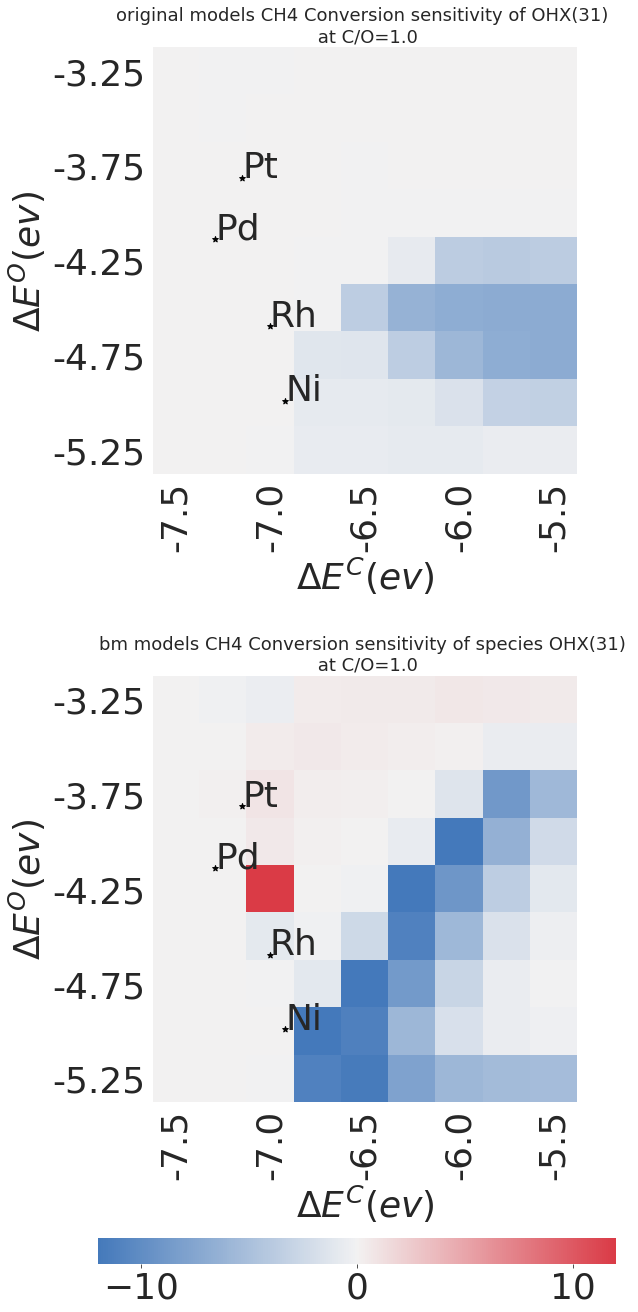

In [10]:
heat_map_gen(11, 8, 1.0, 12, minimum=-12, maximum=12, plot=False, title_name=True, print_data=True)

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


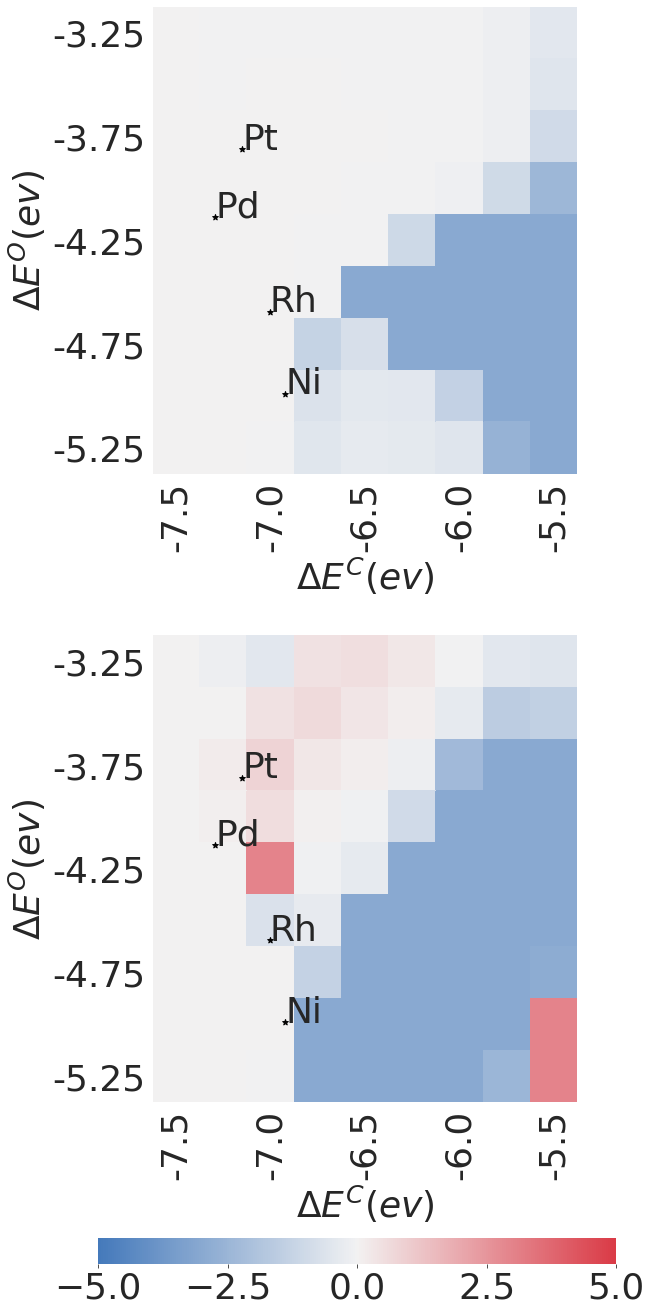

In [43]:
heat_map_gen(11, 3, 1.0, 3, minimum=-5, maximum=5, plot=True)

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


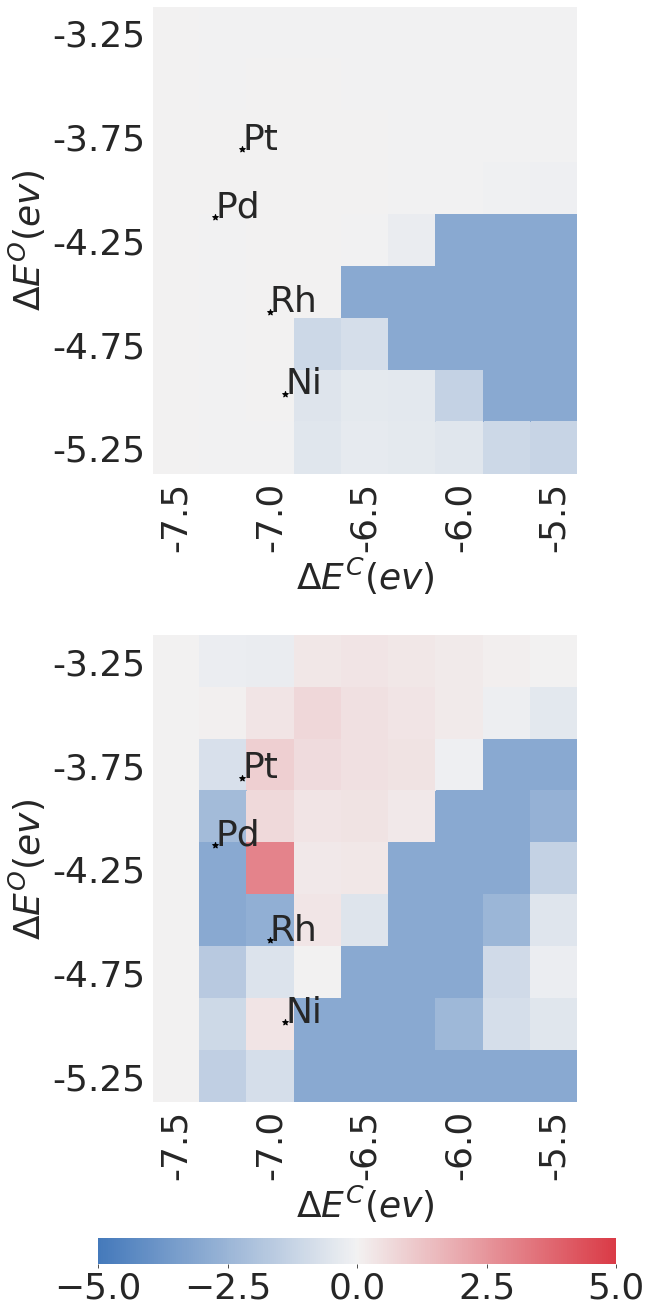

In [38]:
heat_map_gen(11, 10, 1.0, 3, minimum=-5, maximum=5, plot=True)

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so res

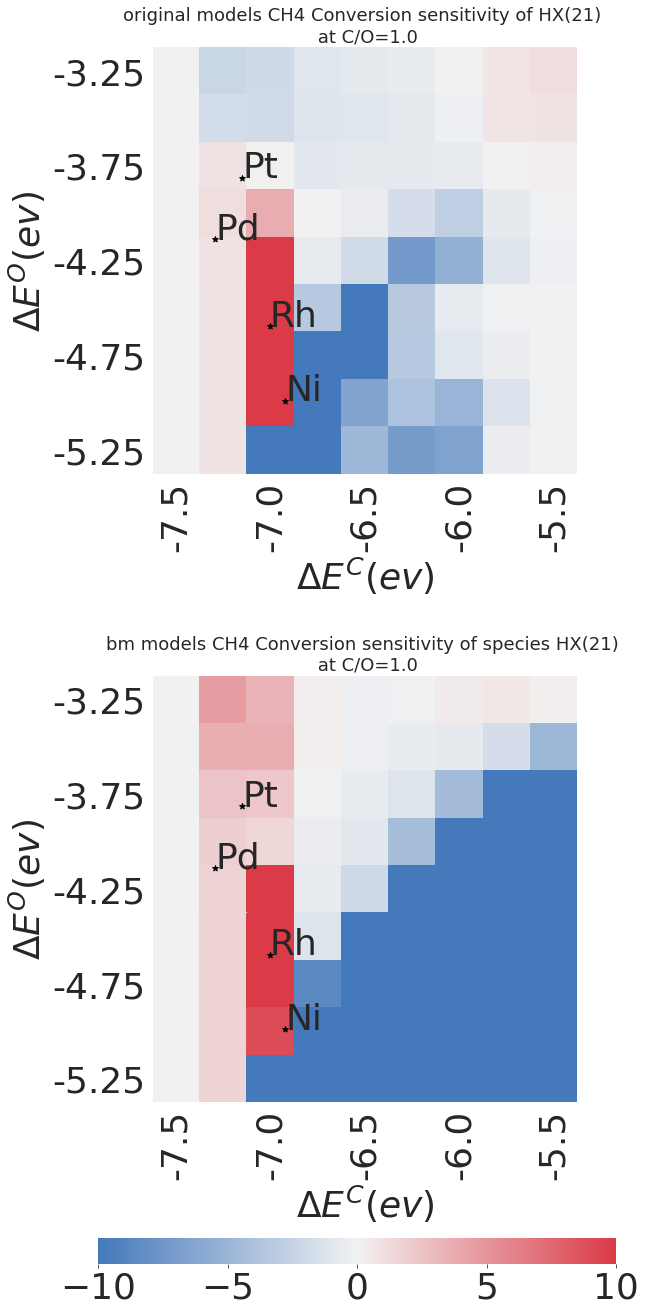

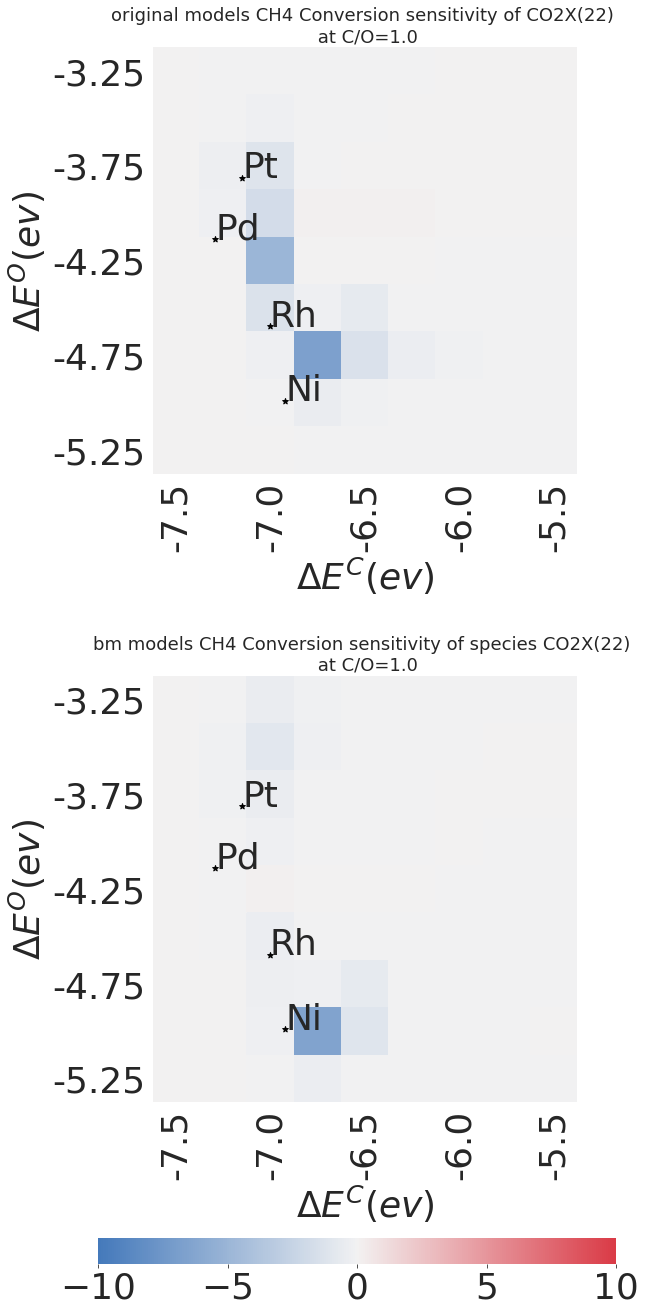

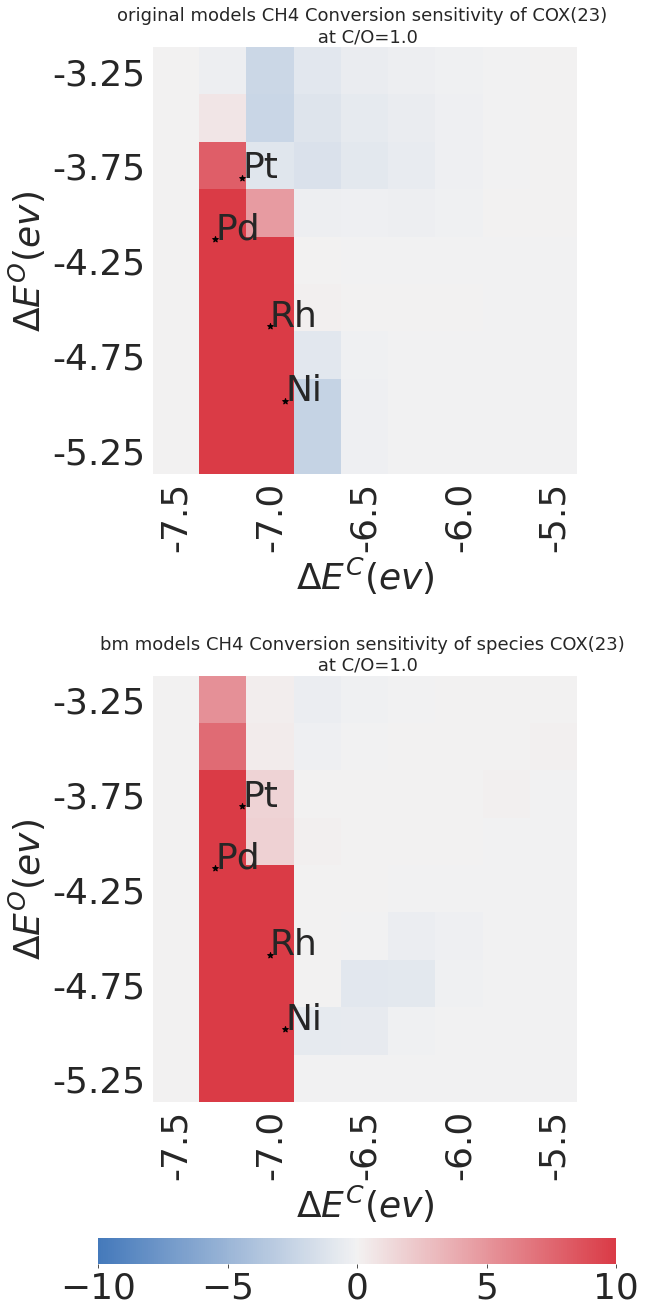

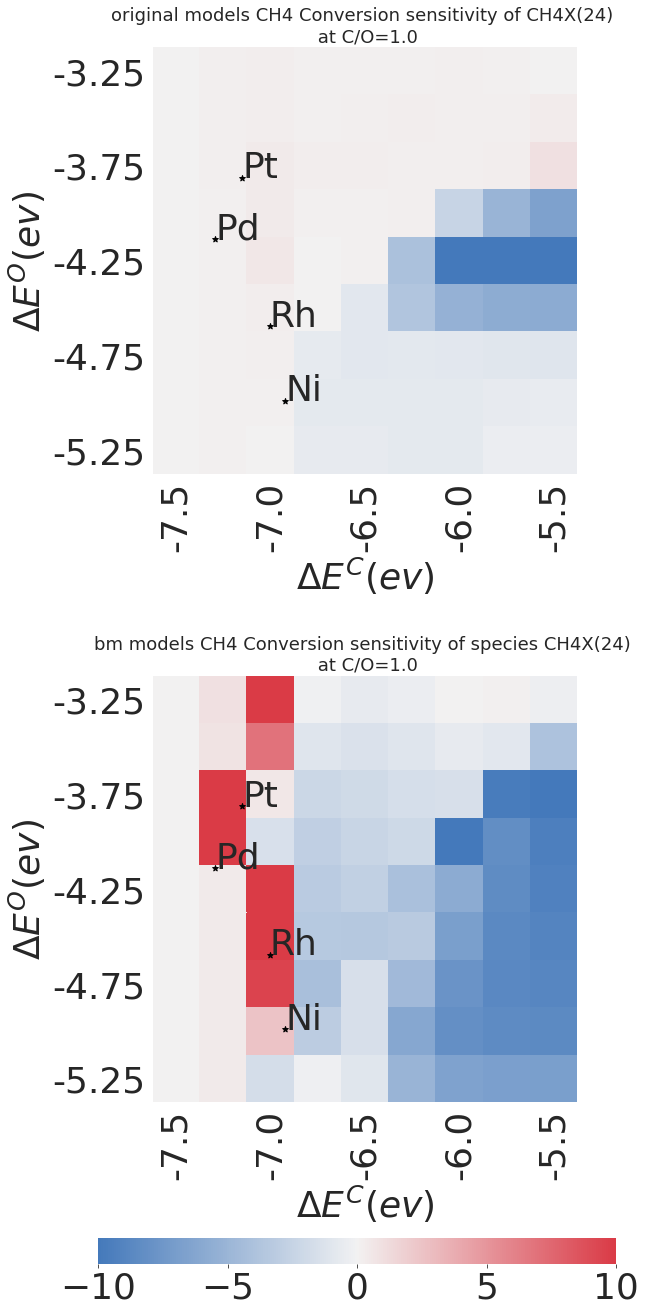

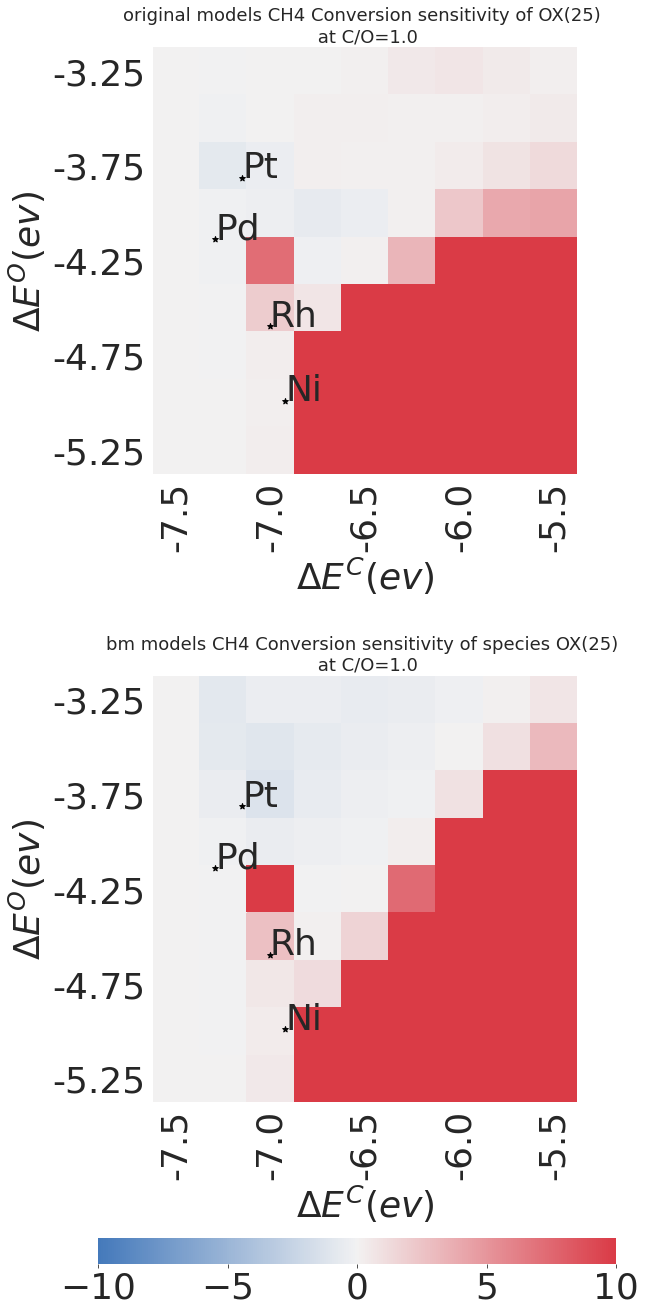

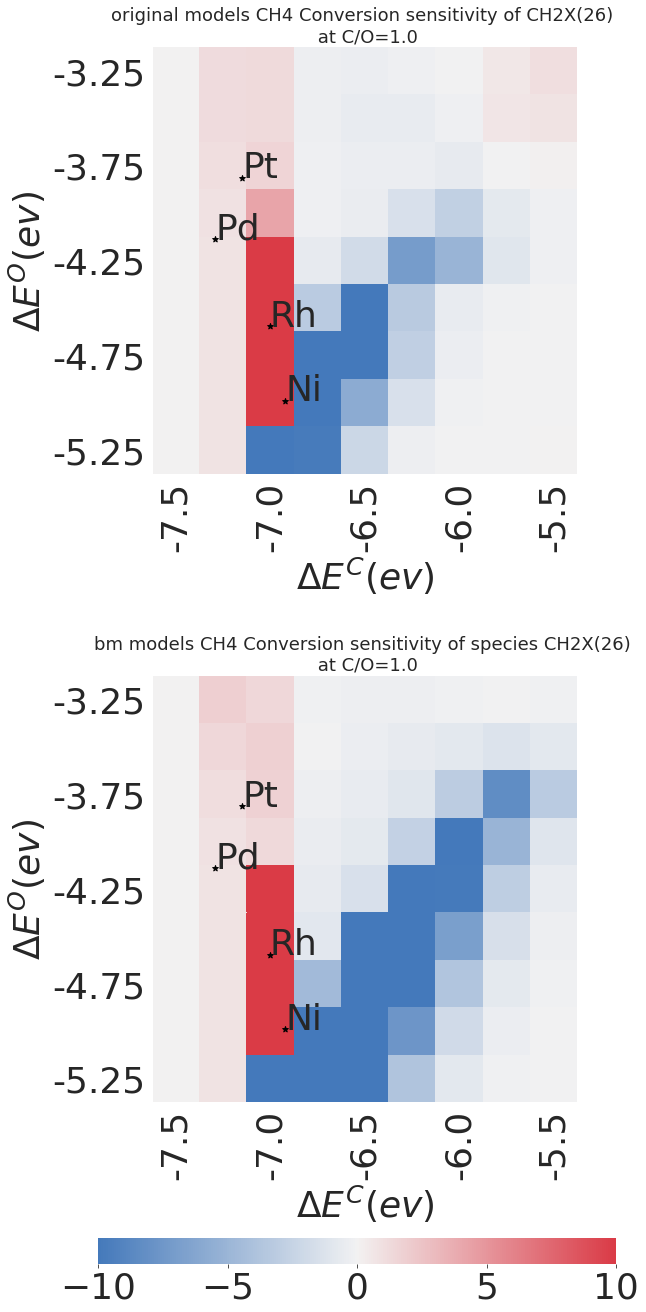

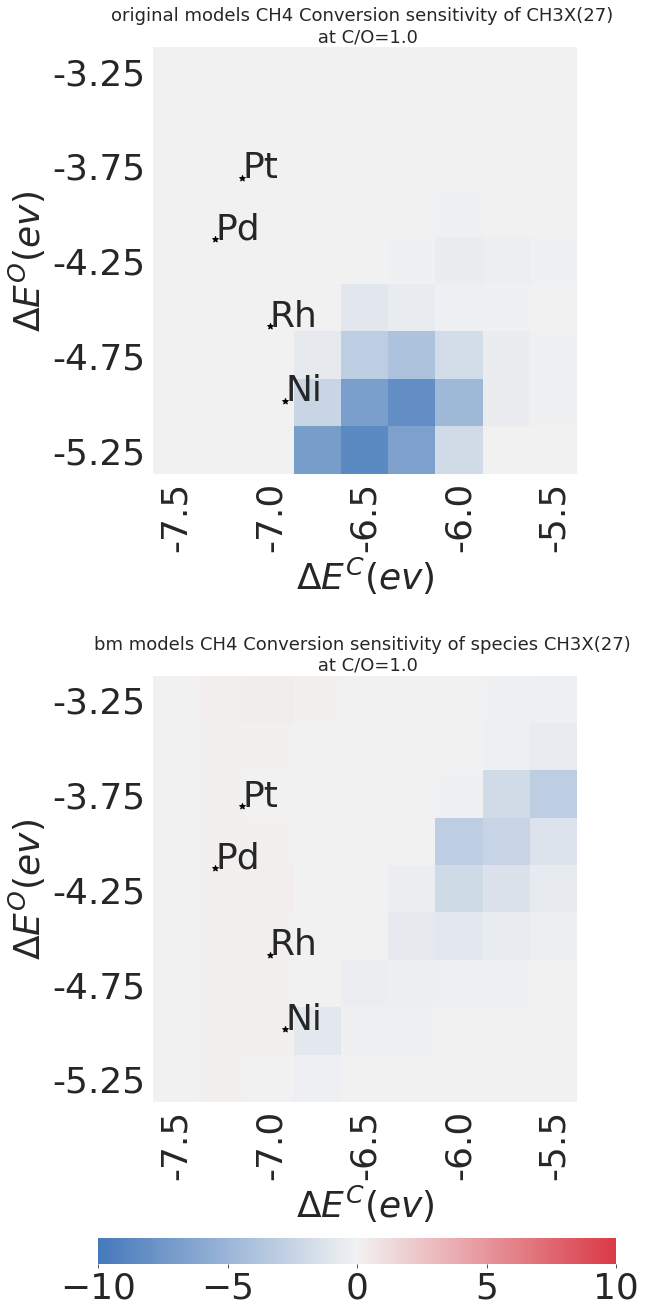

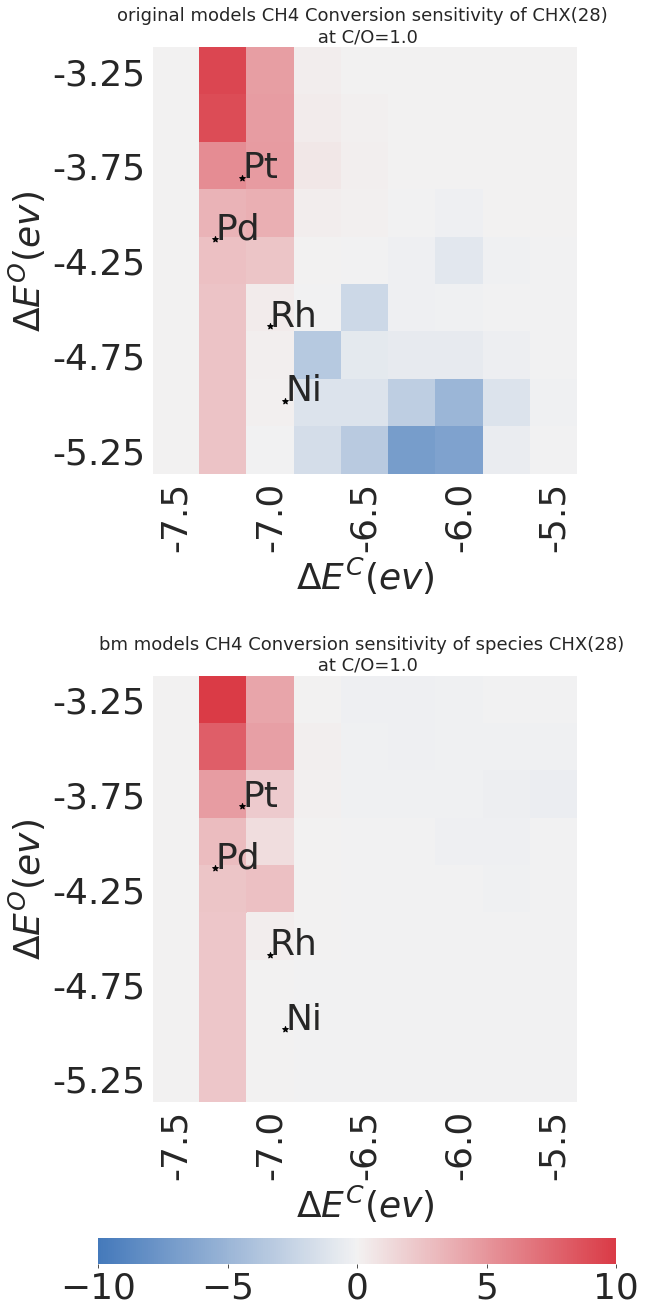

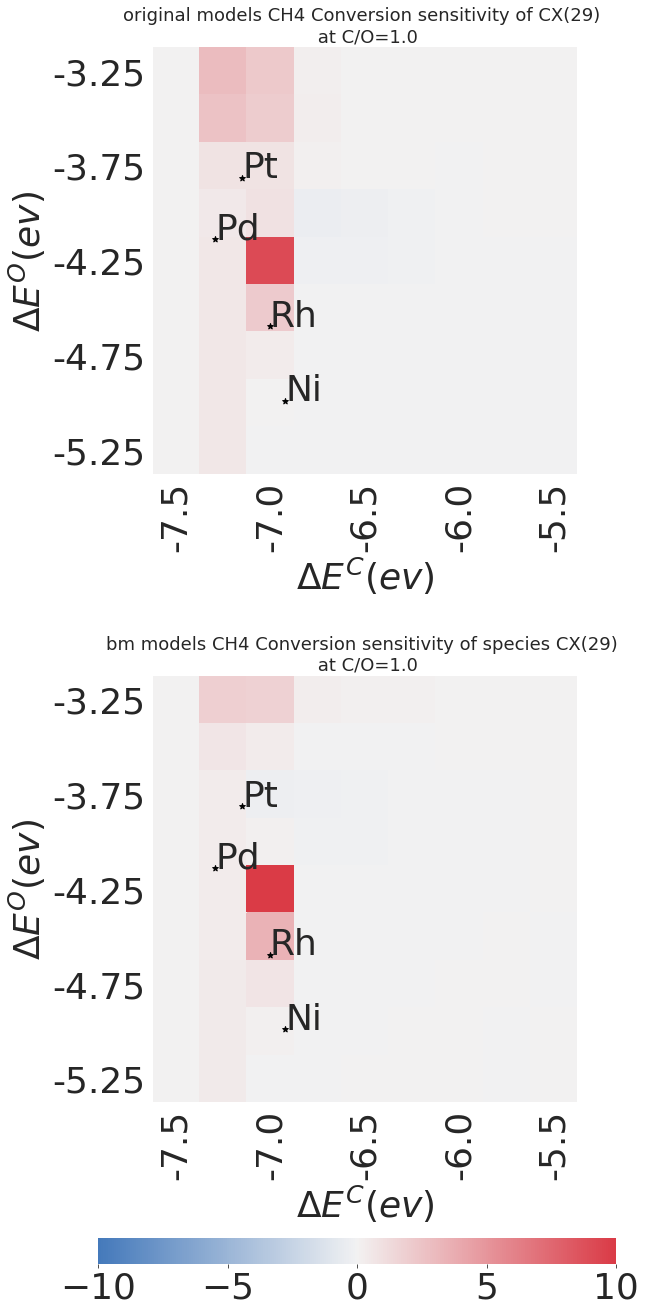

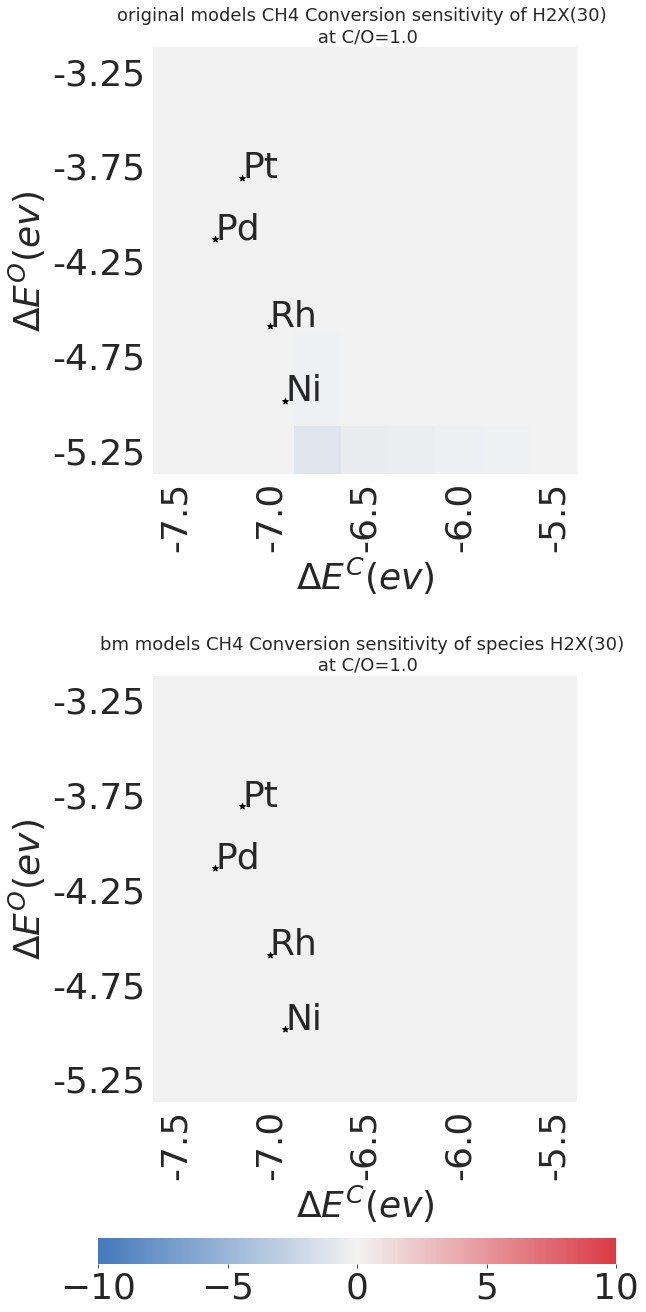

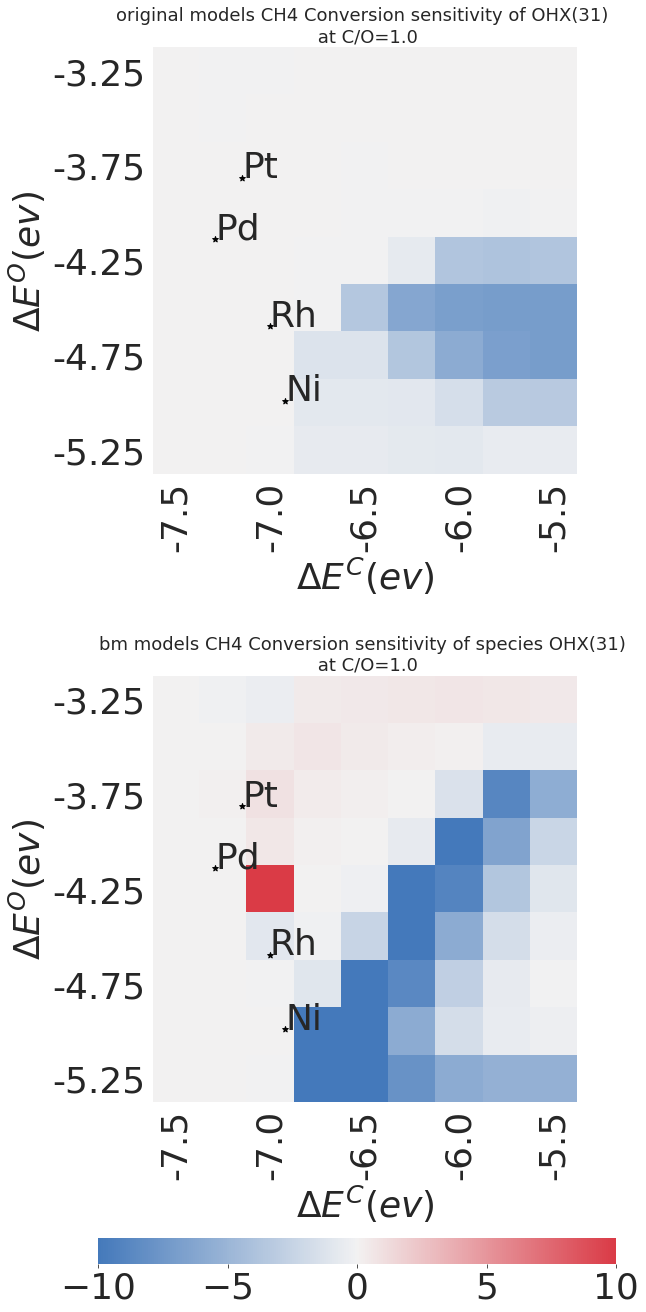

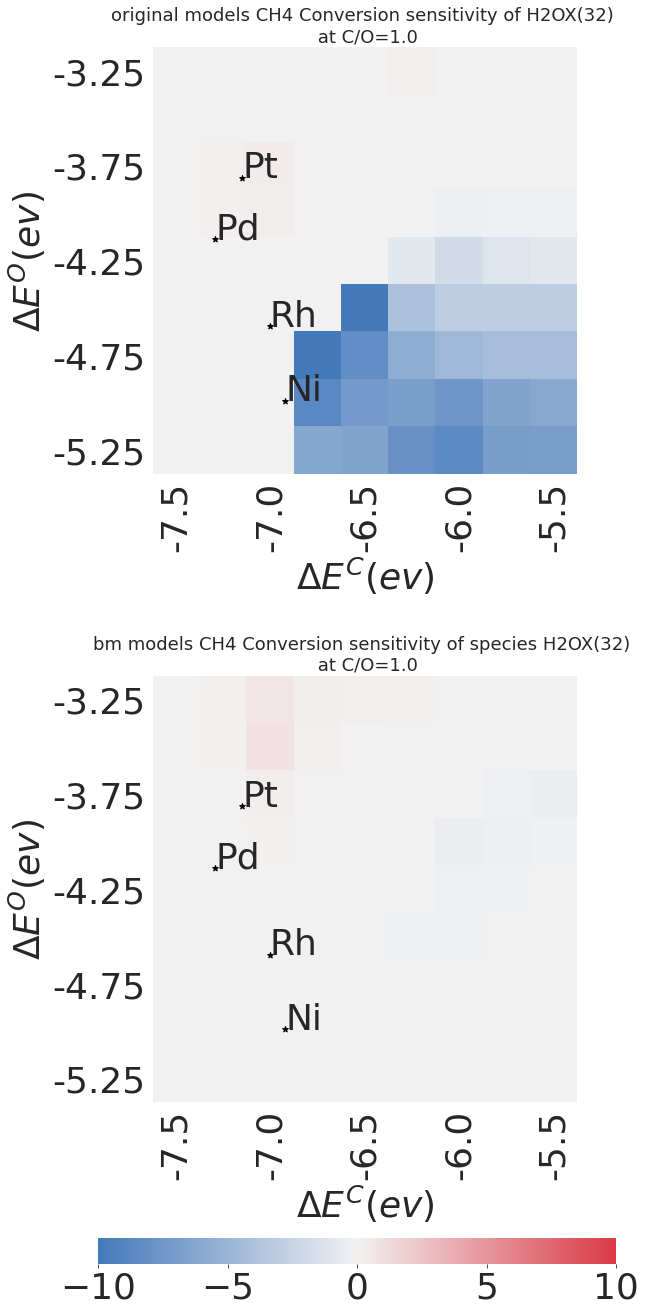

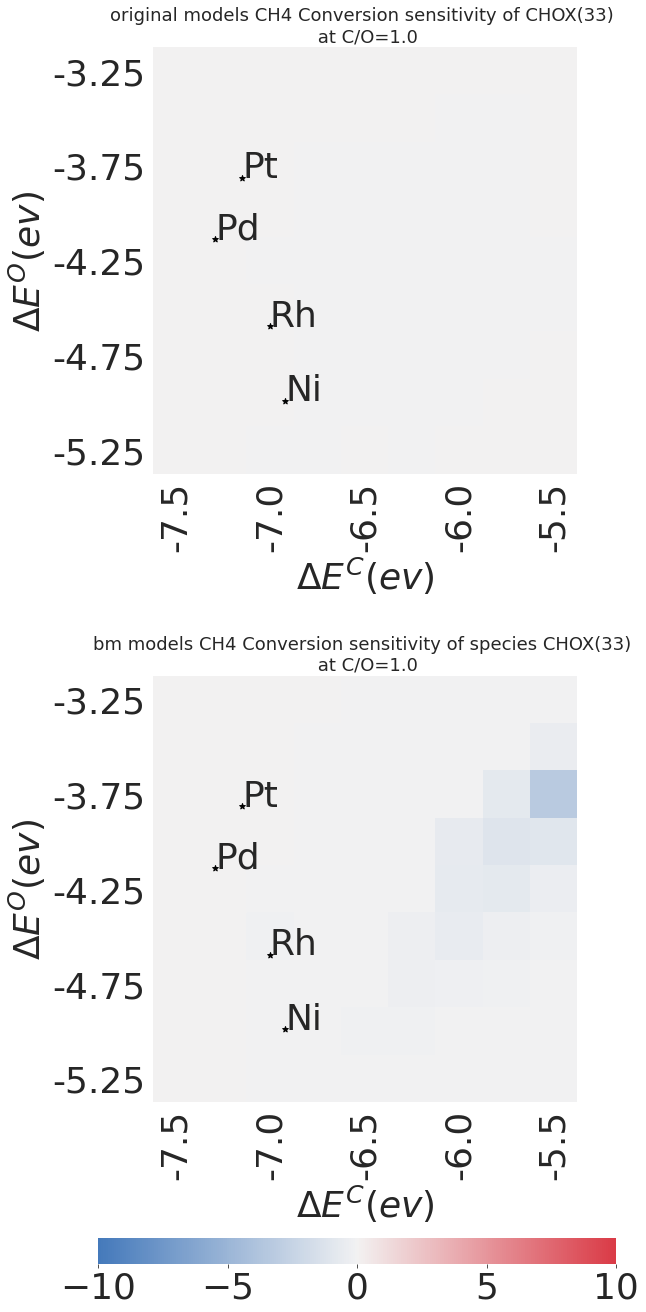

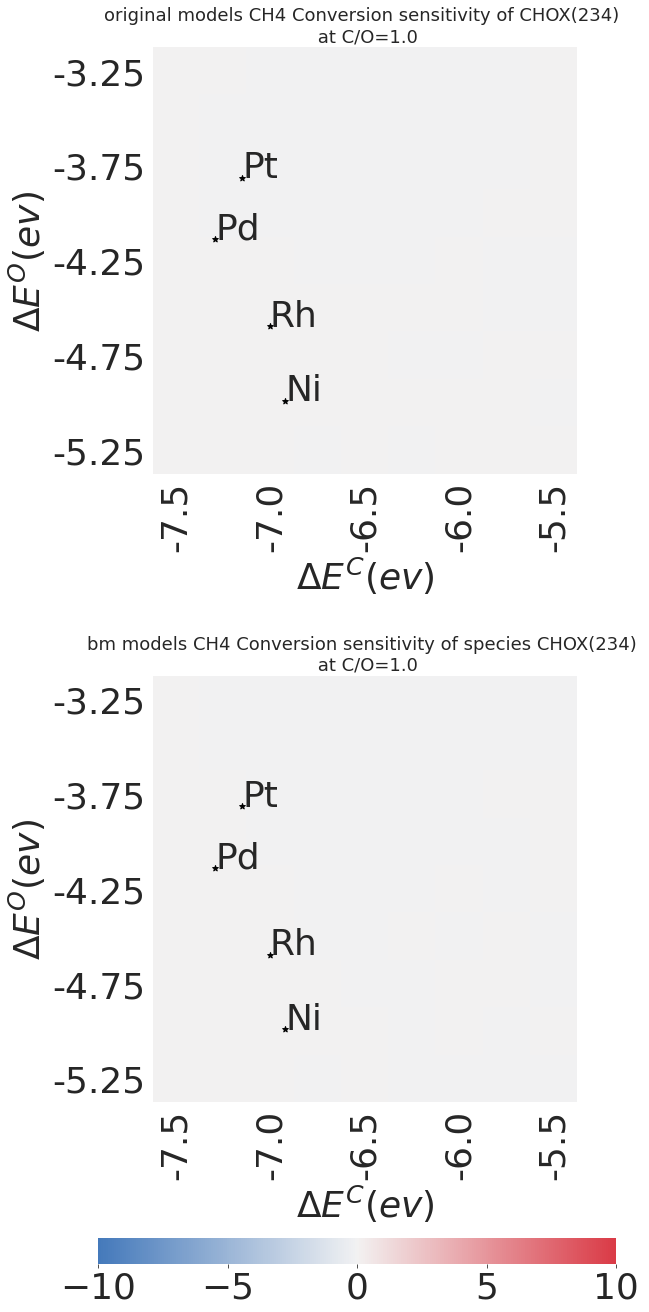

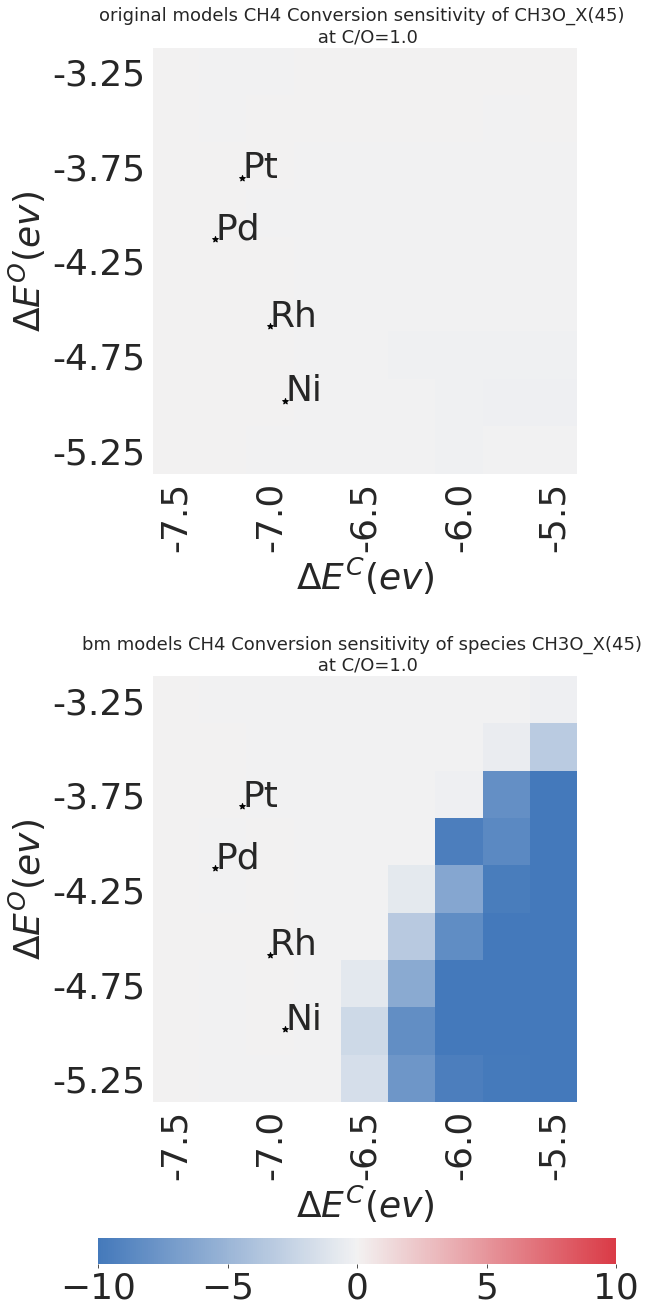

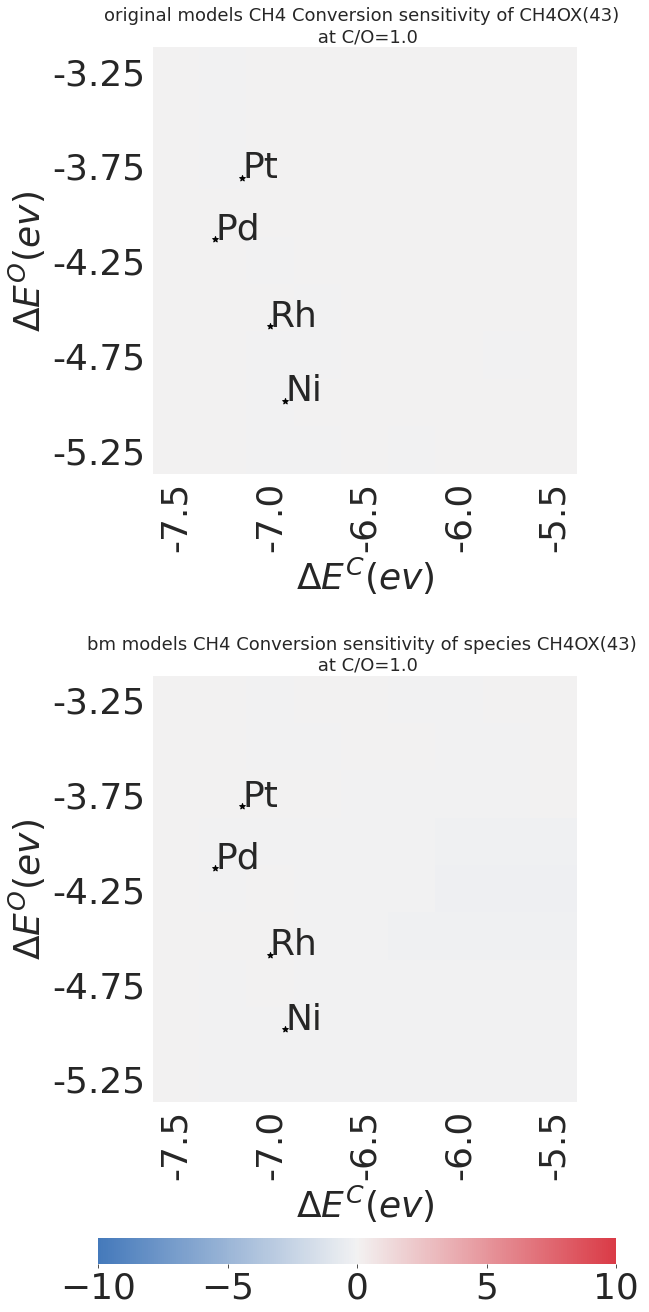

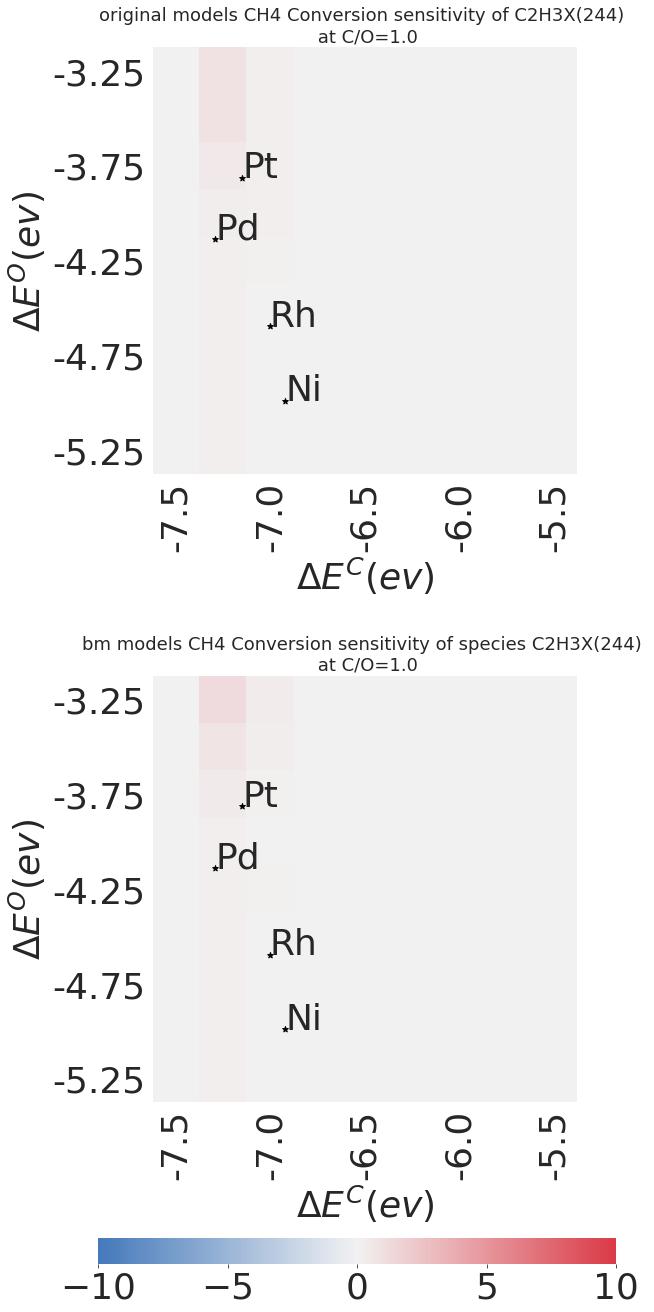

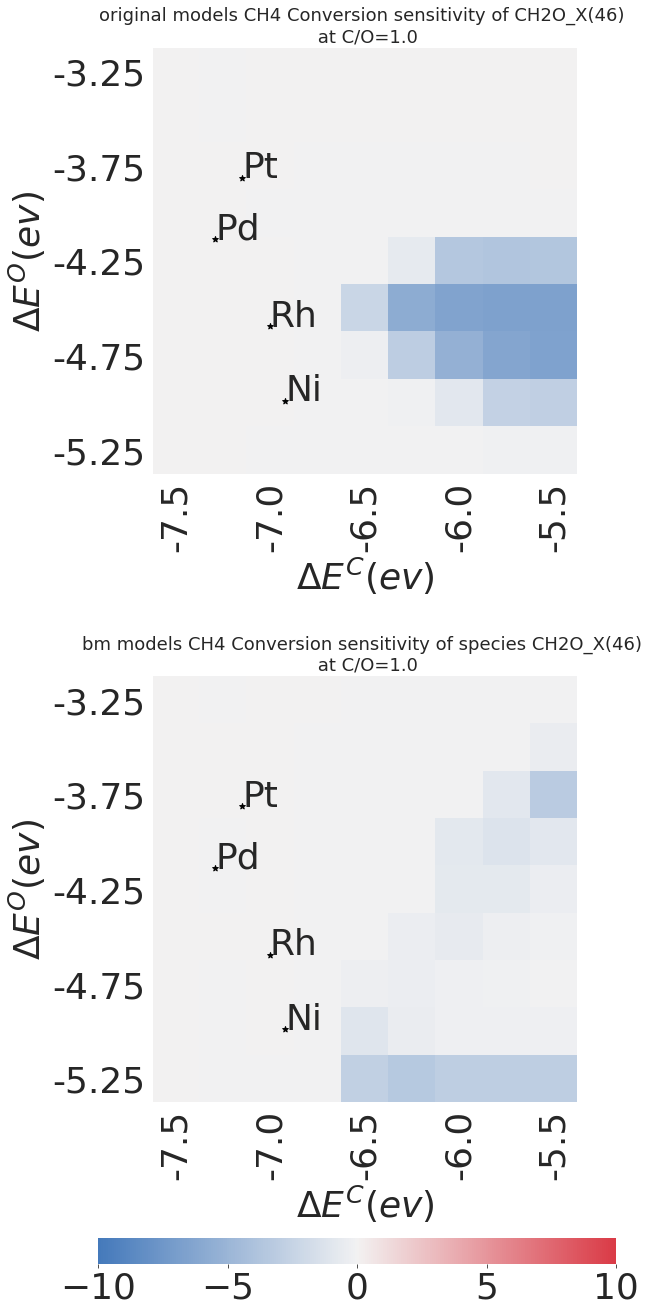

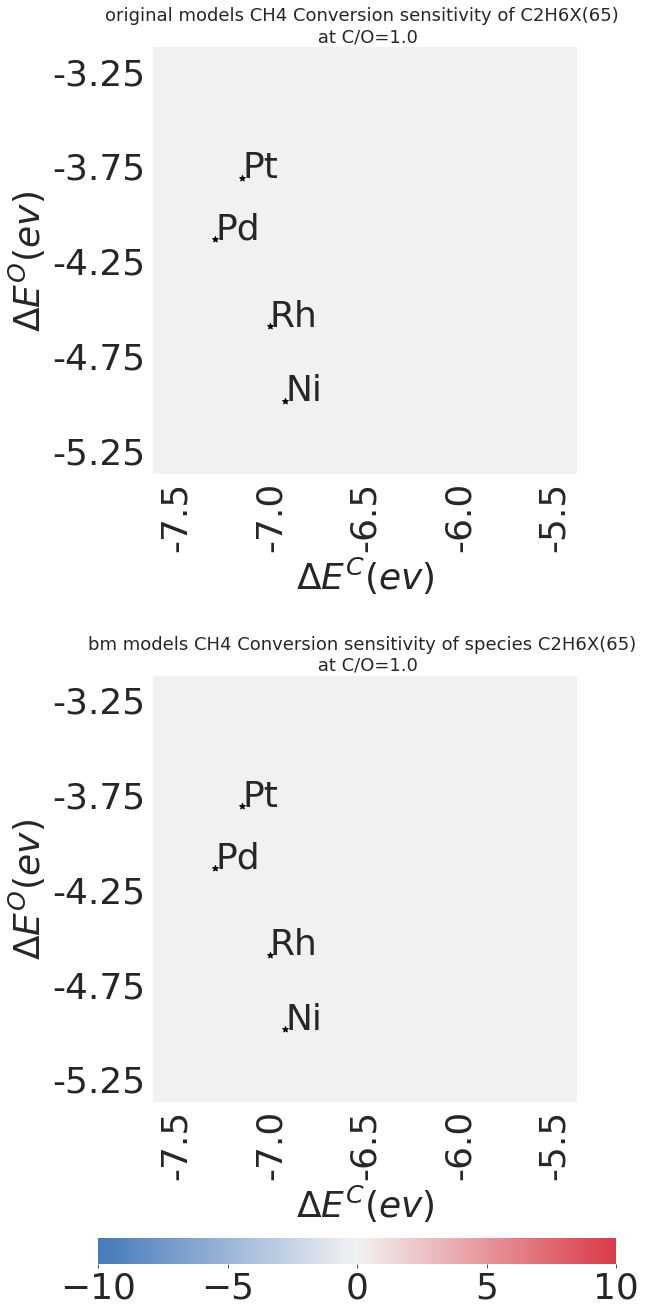

In [18]:
# syngas yield
for i in range(1, 20):
    heat_map_gen(i, 8, 1.0, 20, title_name=True, minimum=-10, maximum=10)

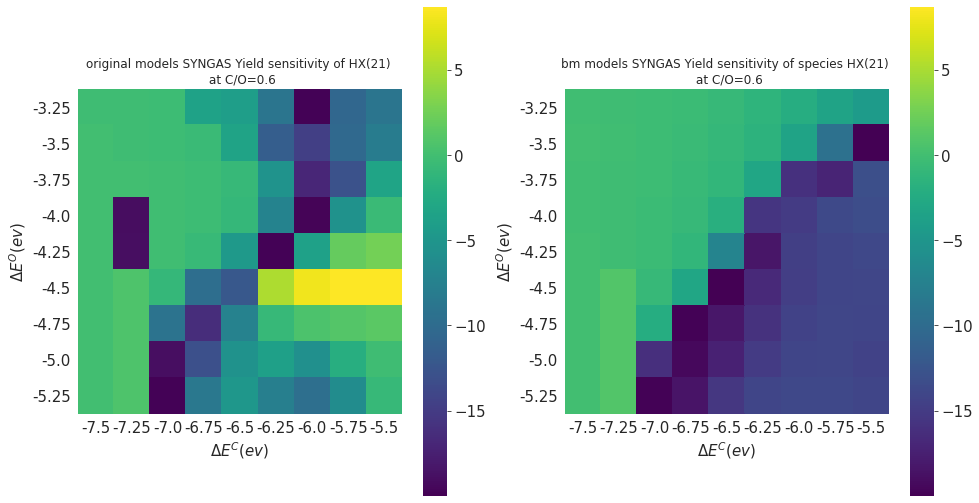

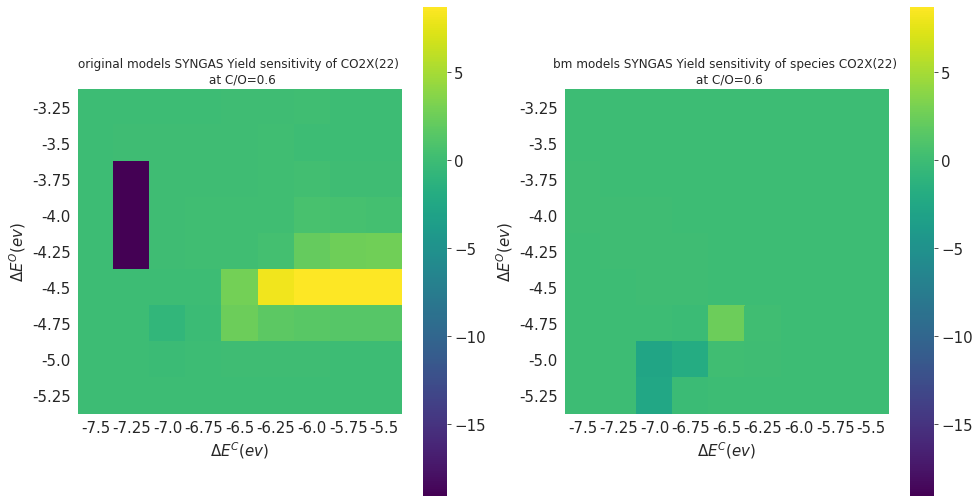

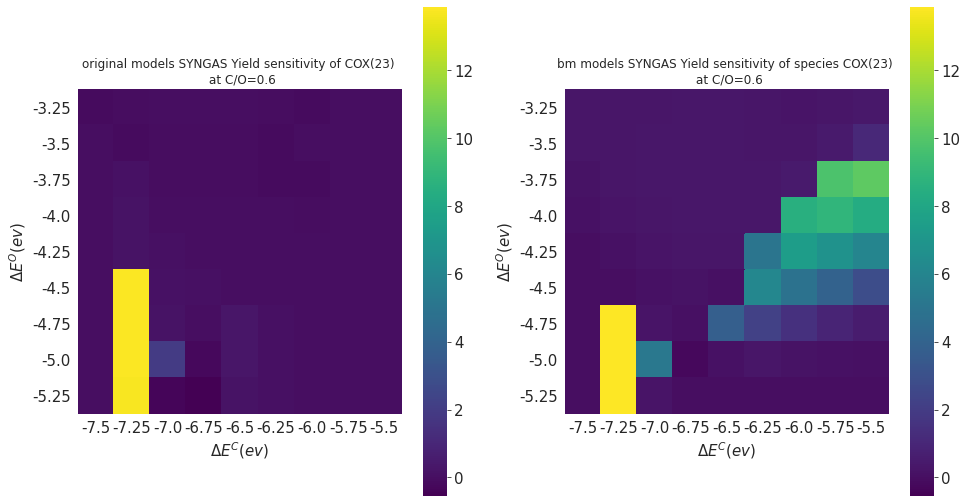

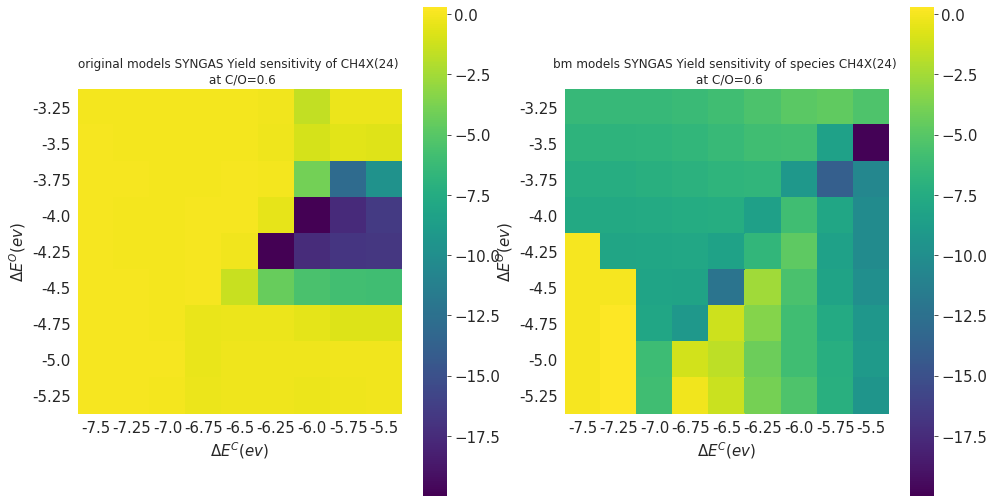

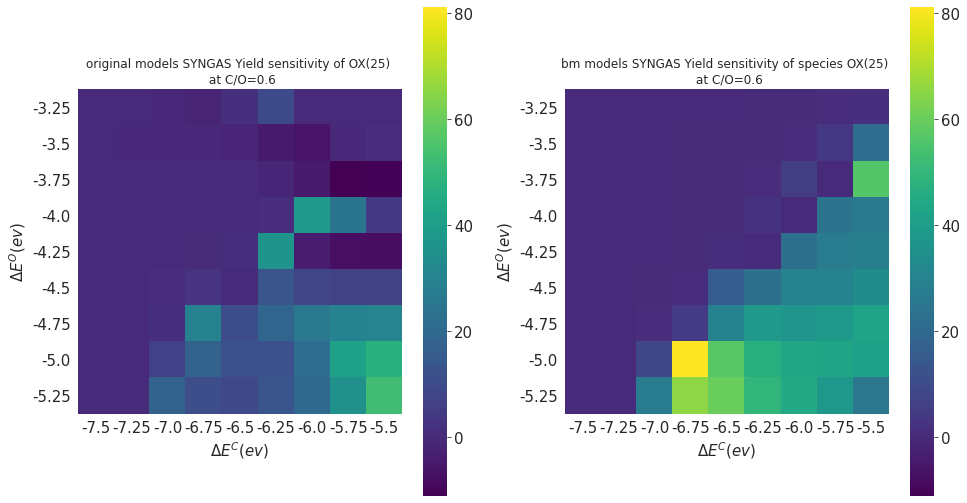

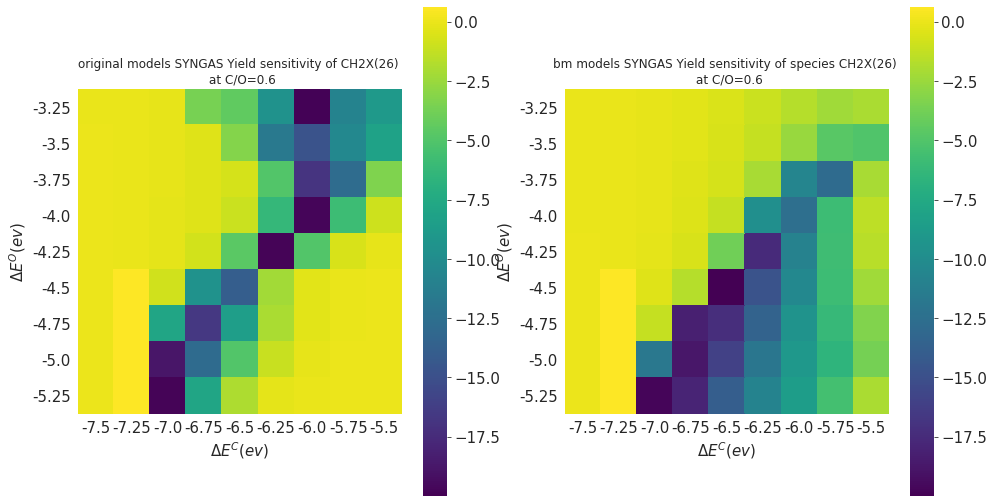

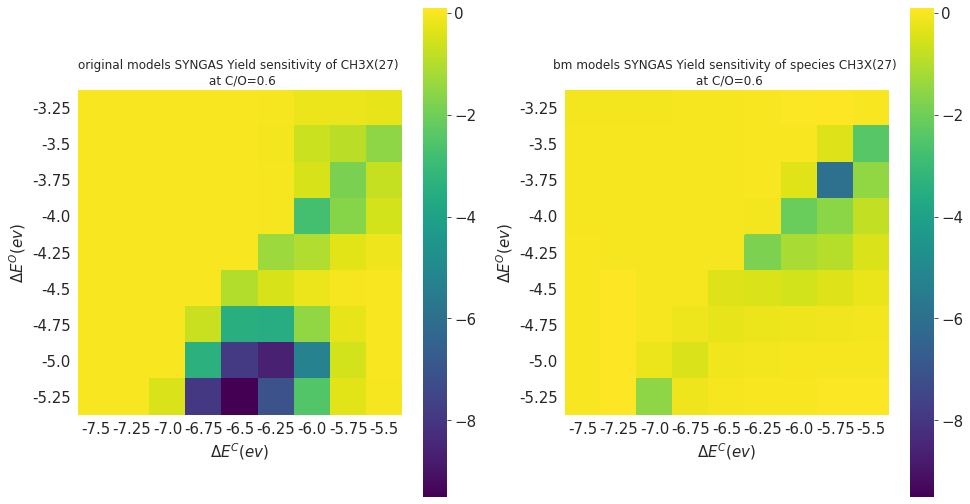

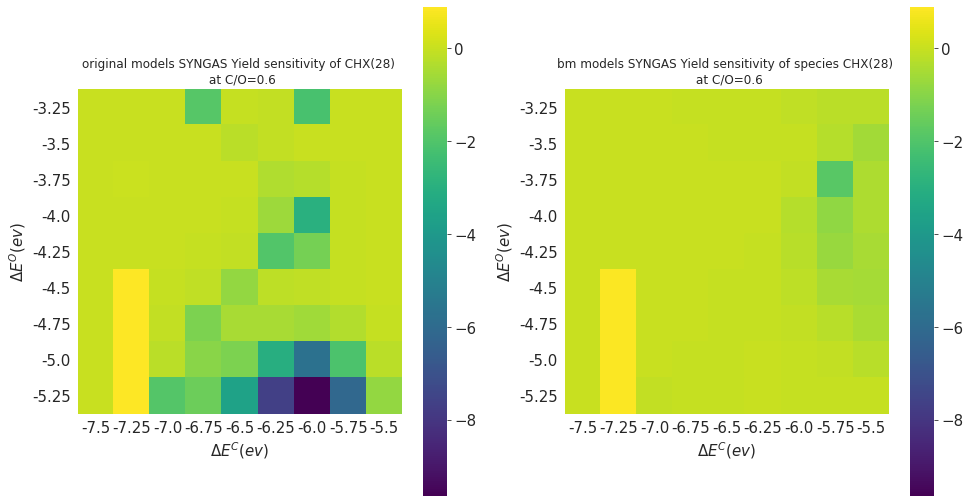

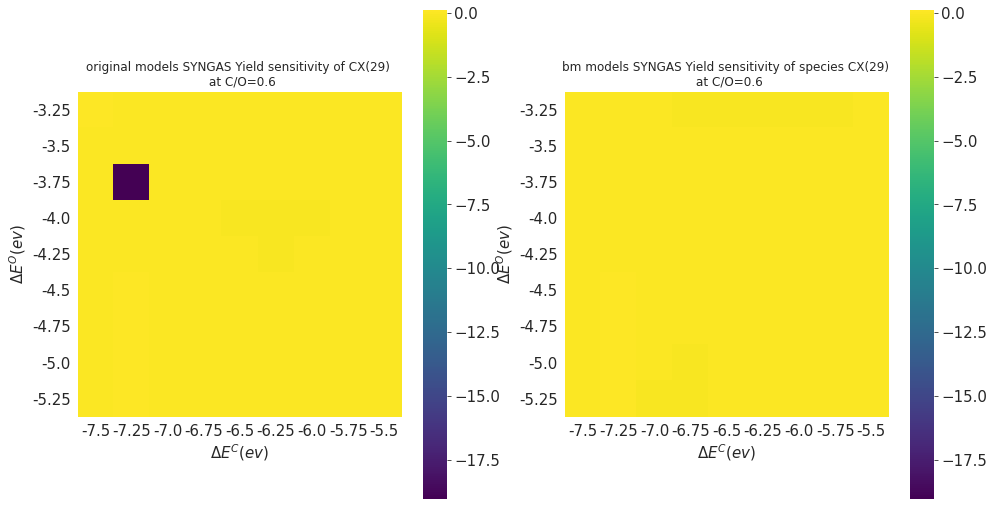

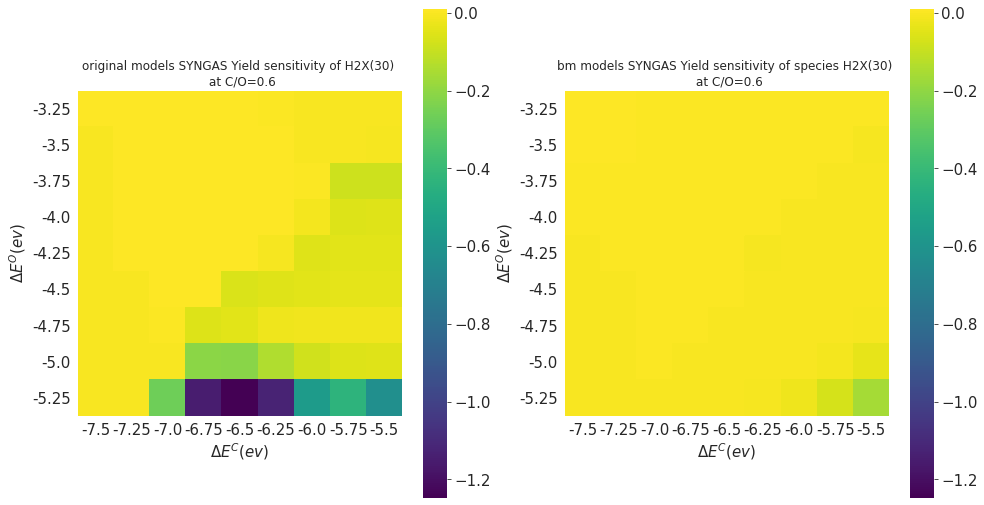

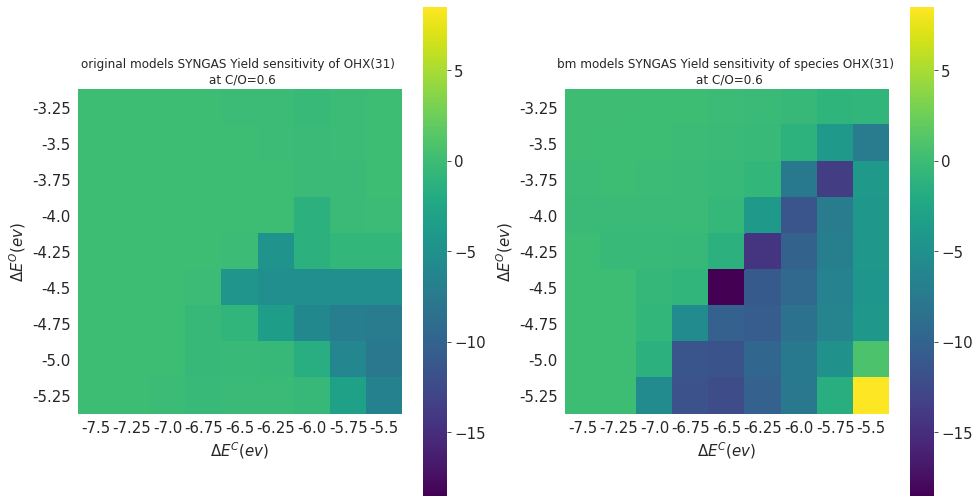

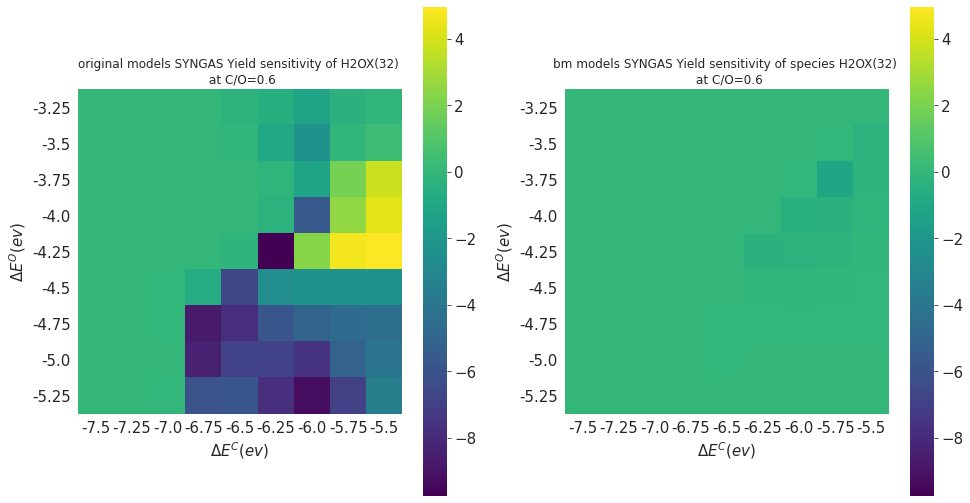

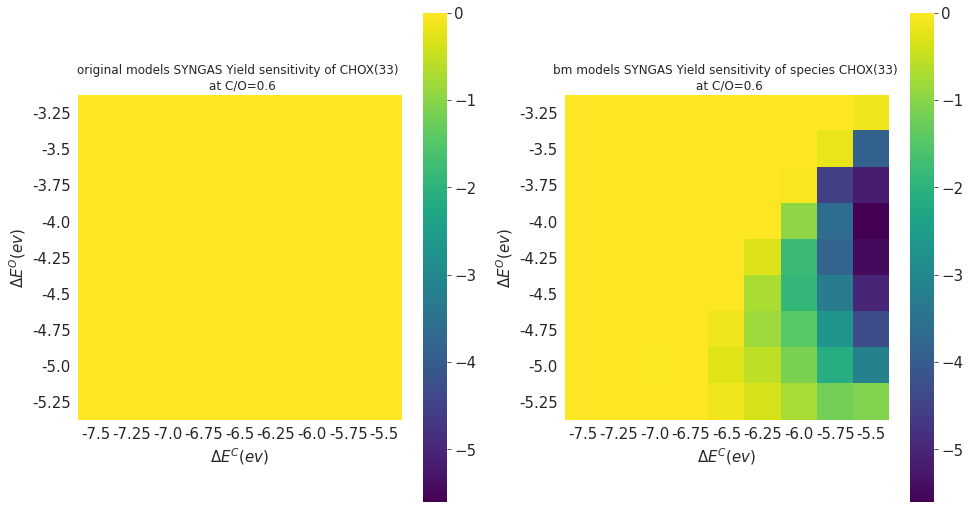

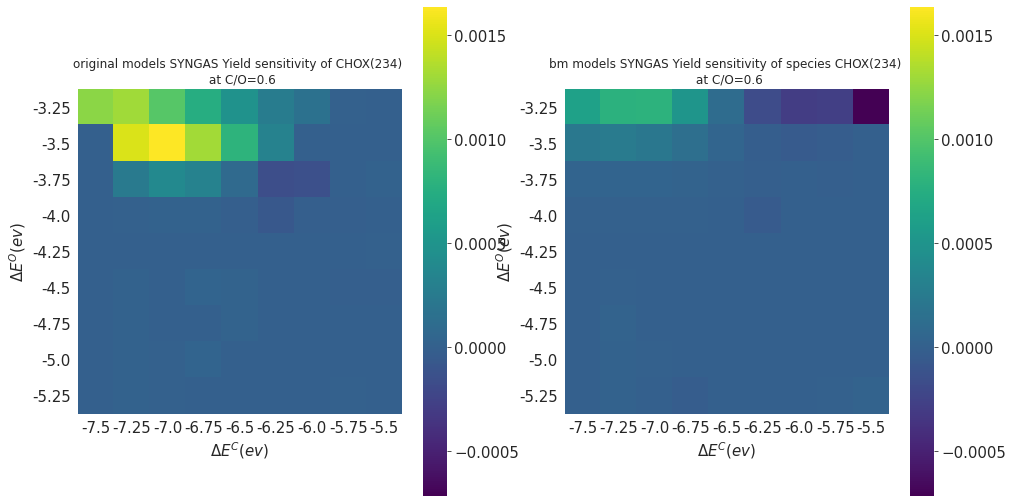

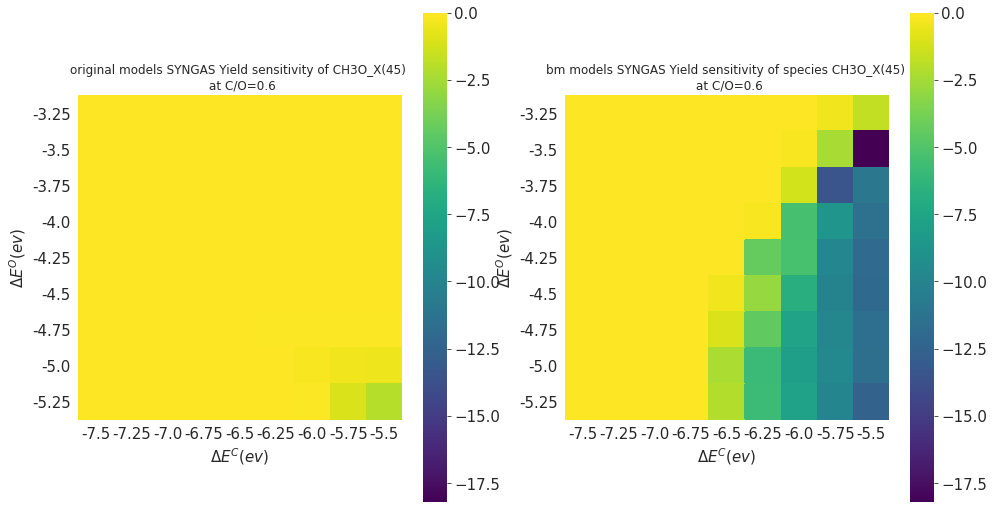

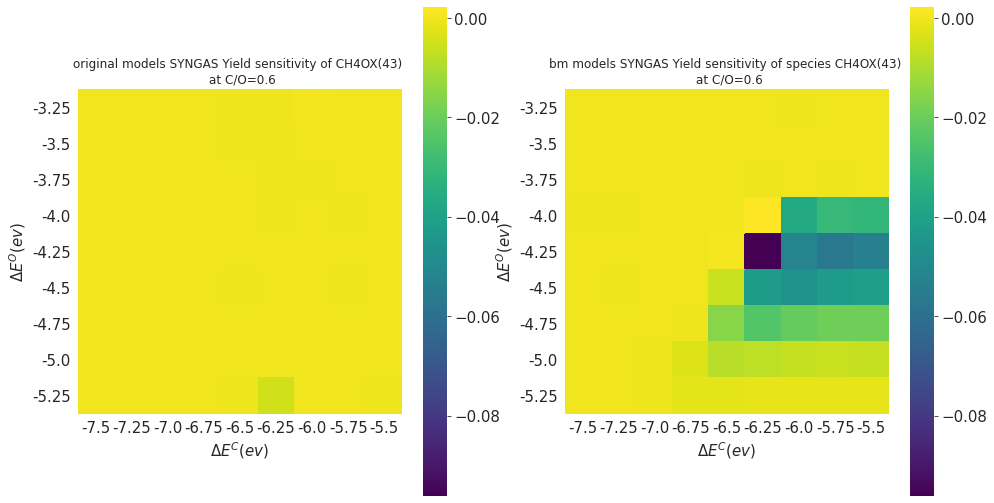

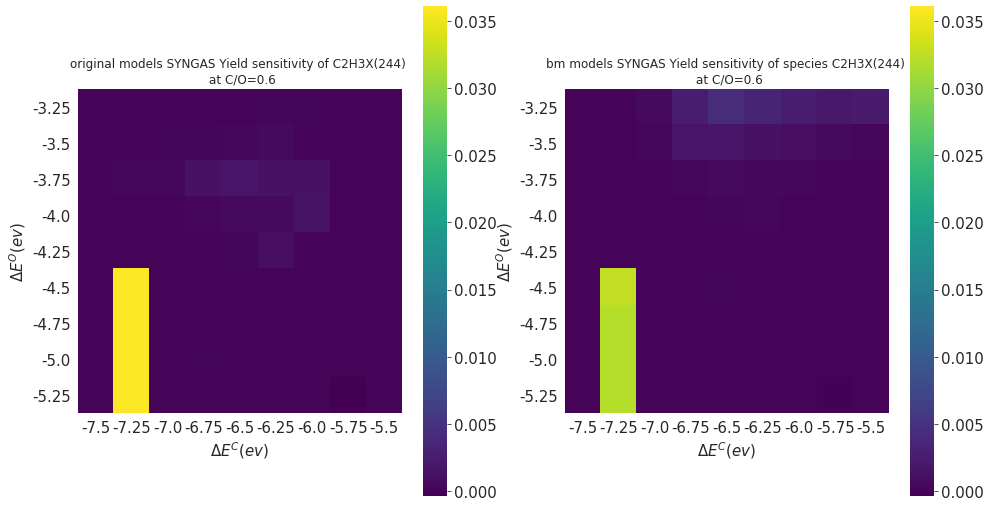

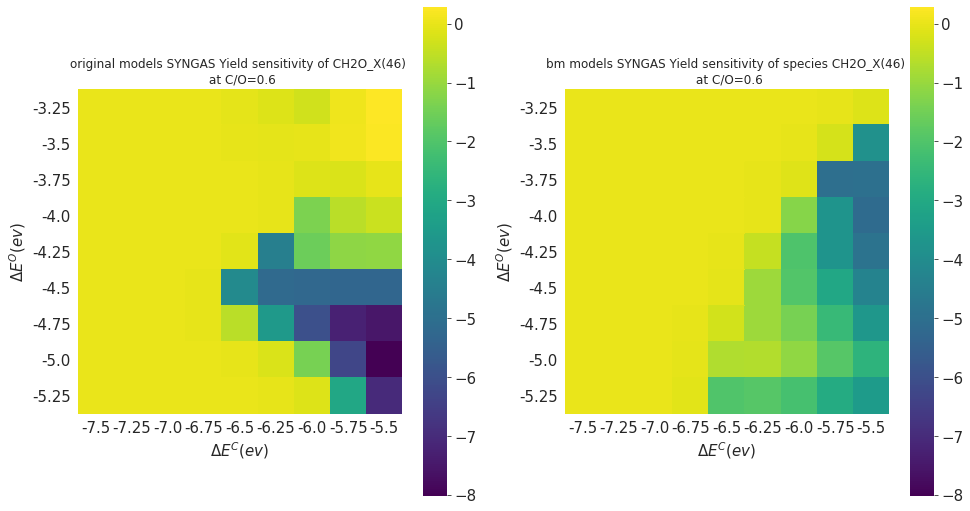

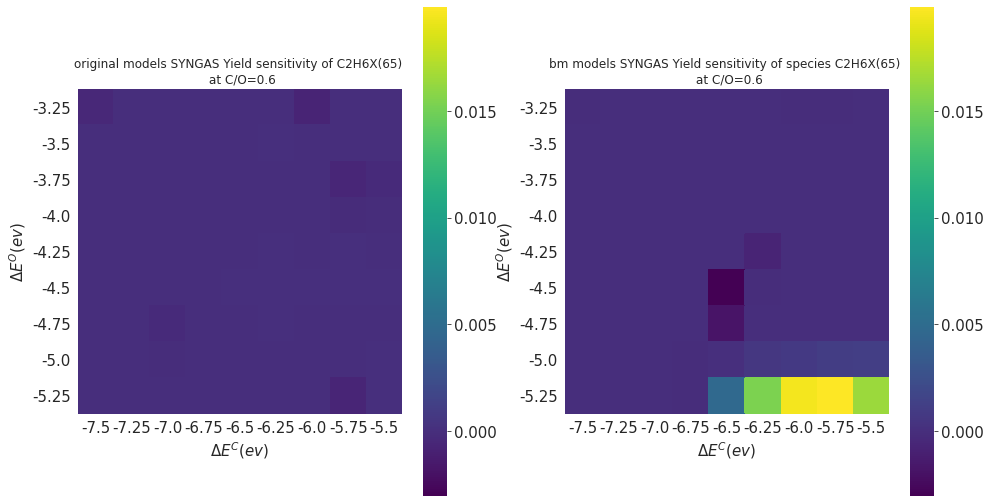

In [15]:
# syngas yield
for i in range(1, 20):
    heat_map_gen(i, 3, 0.6, 100)

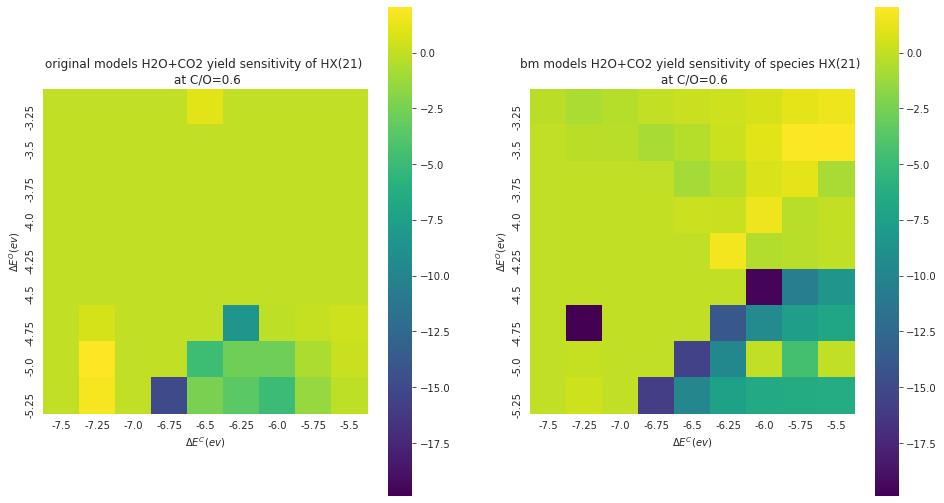

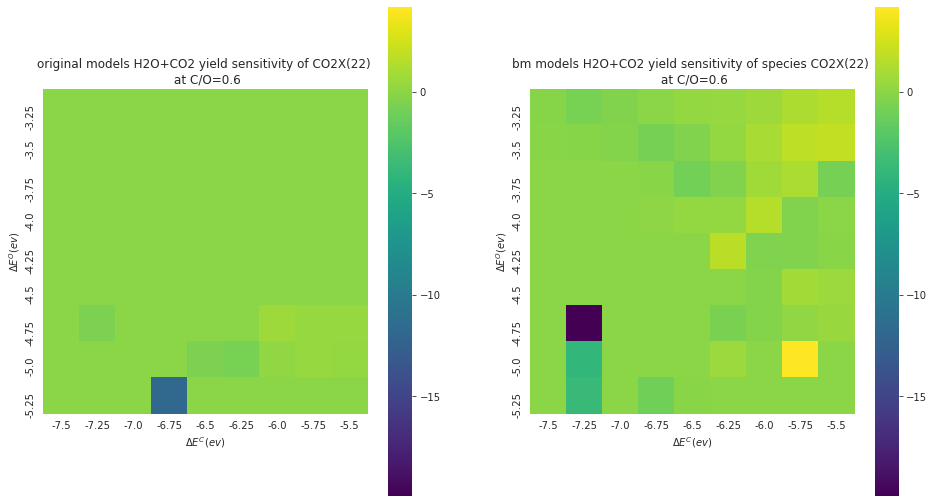

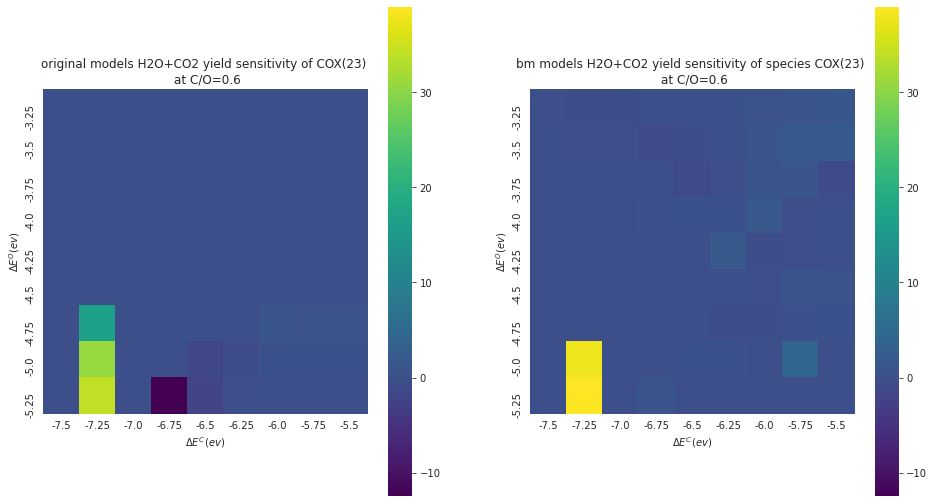

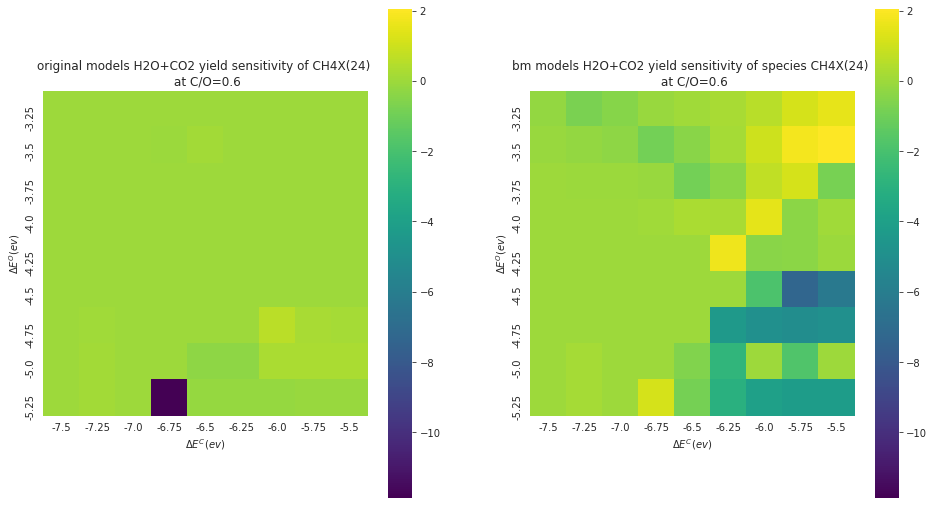

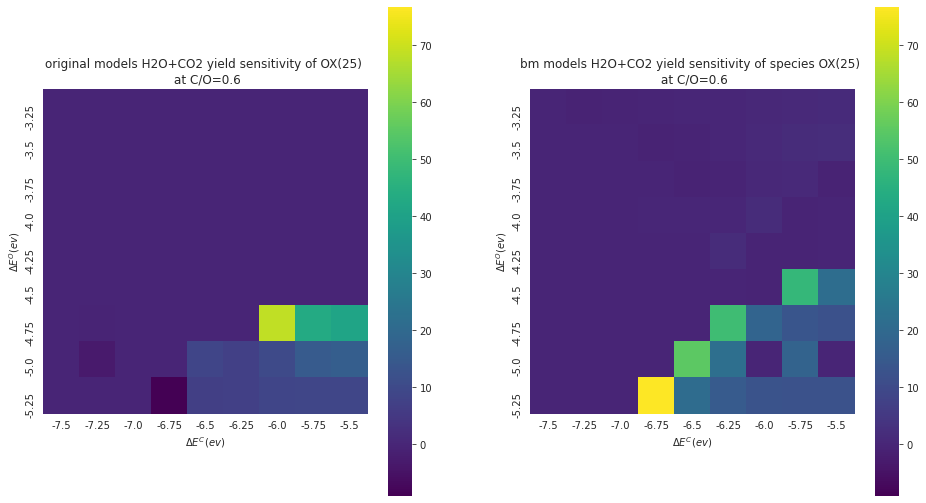

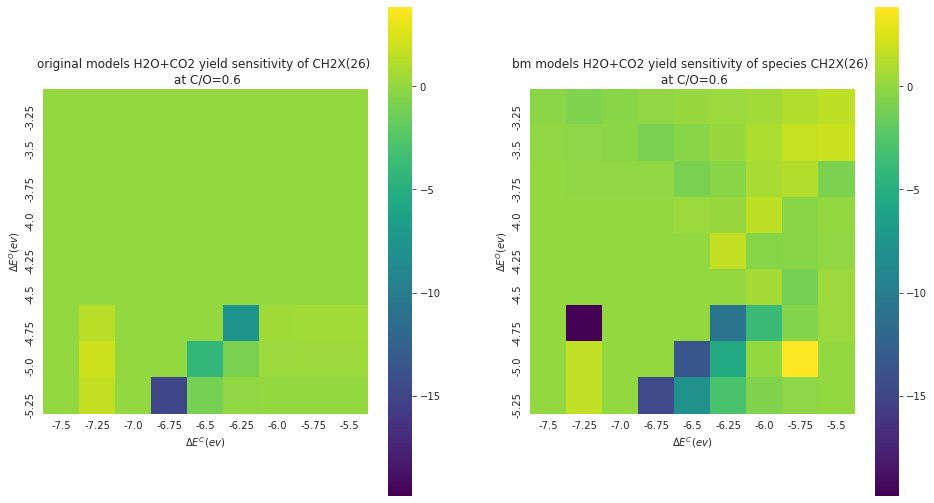

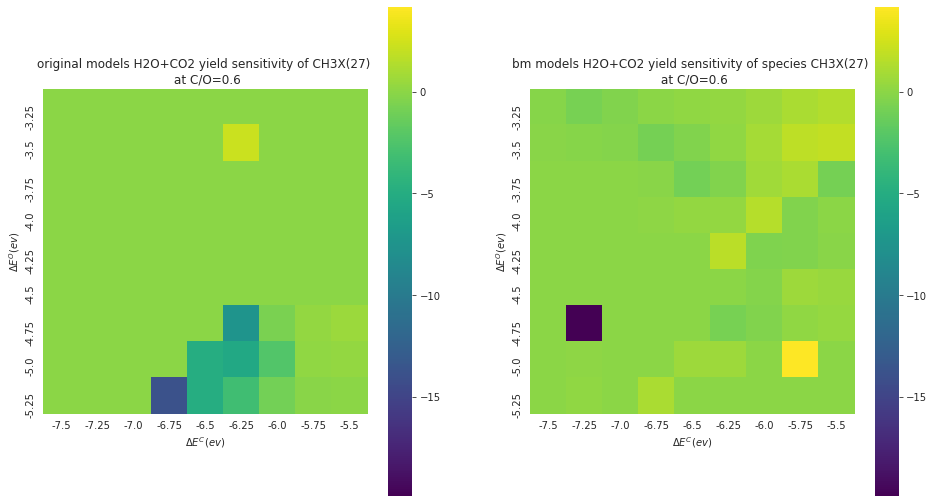

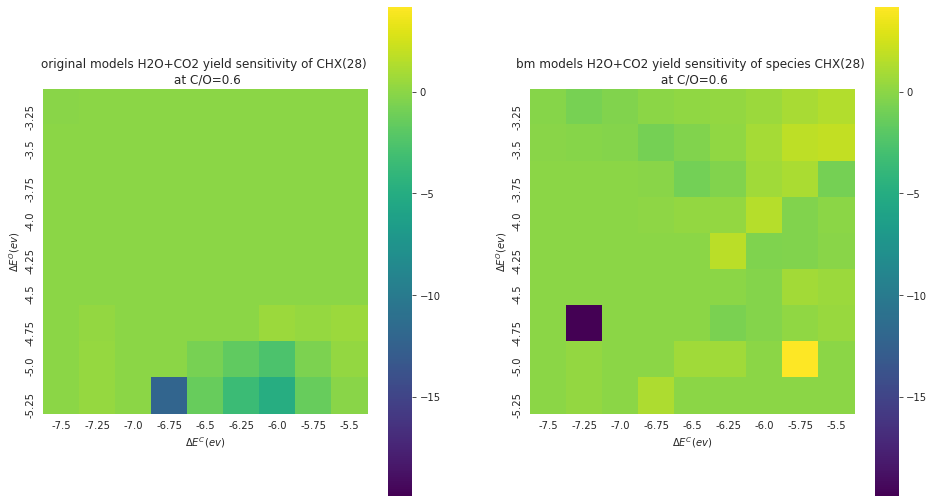

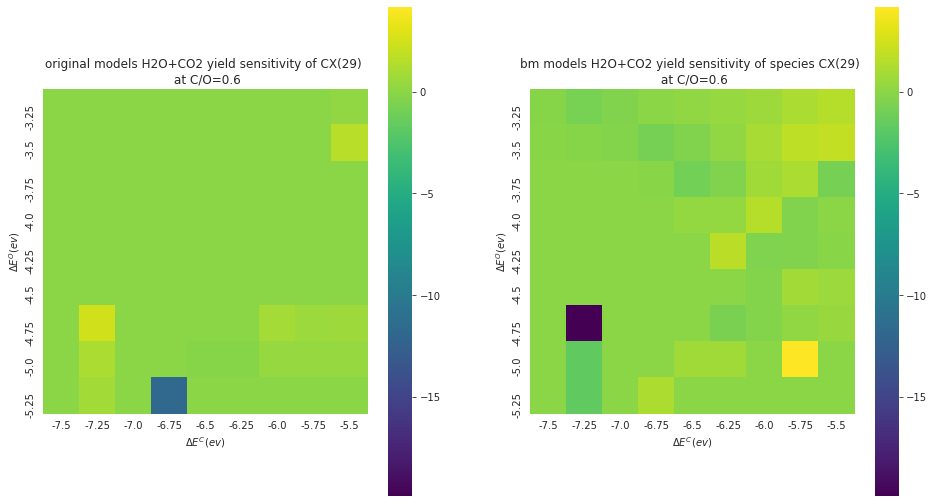

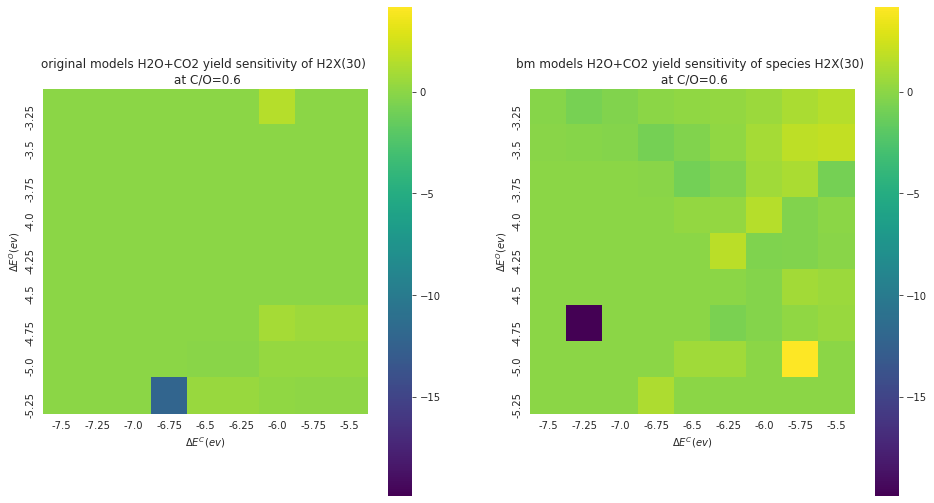

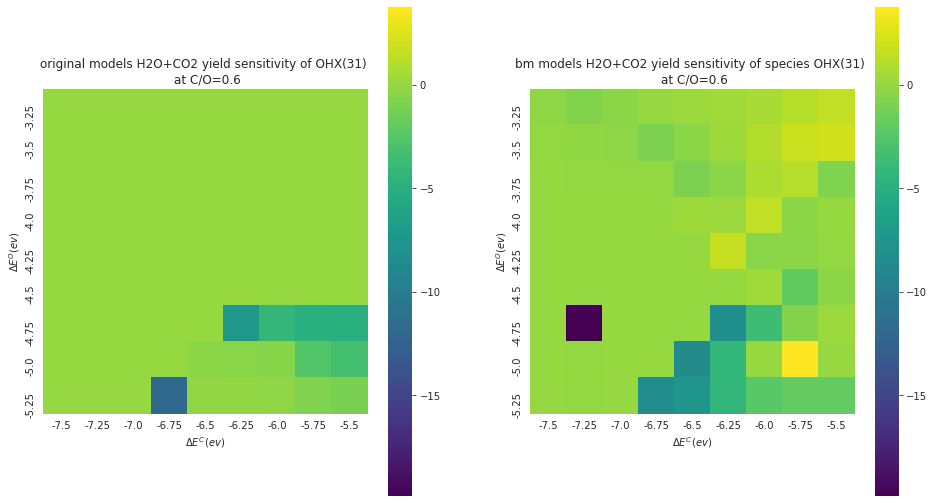

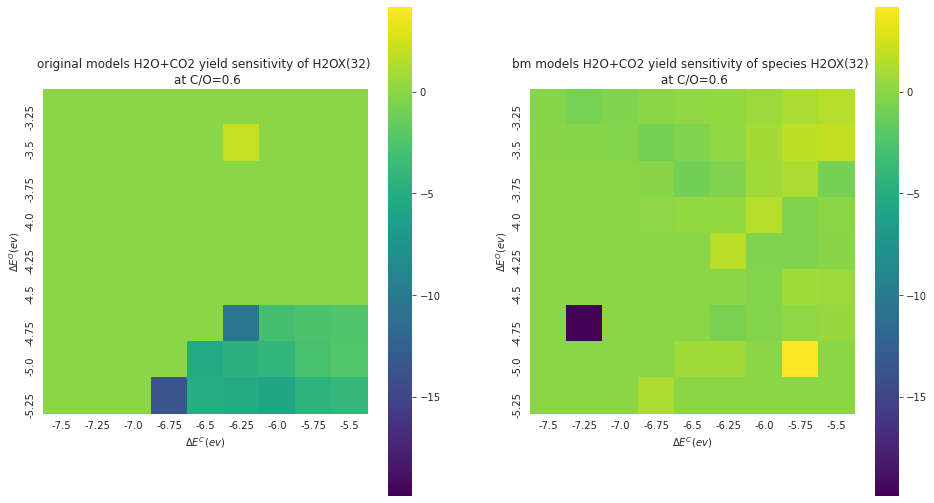

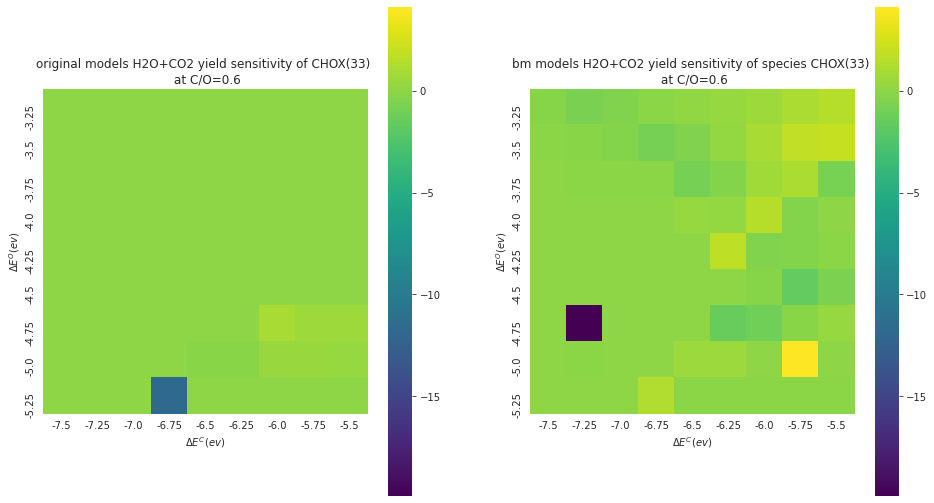

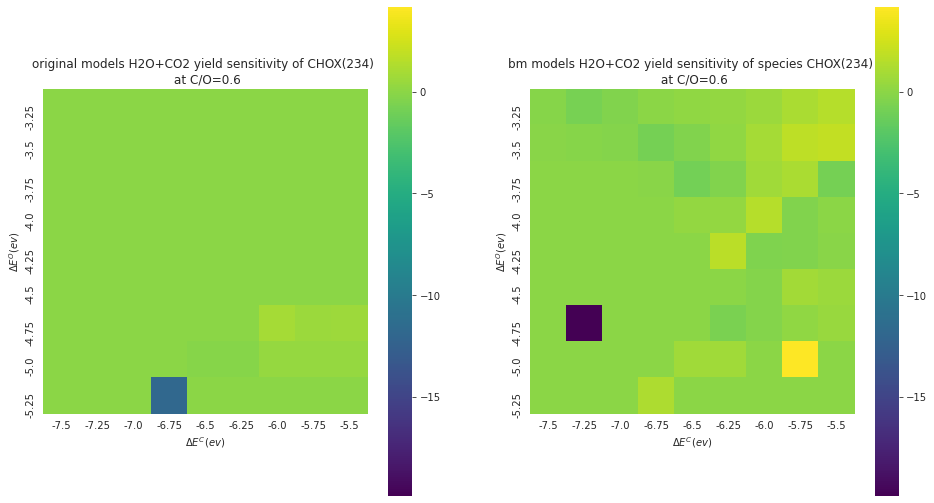

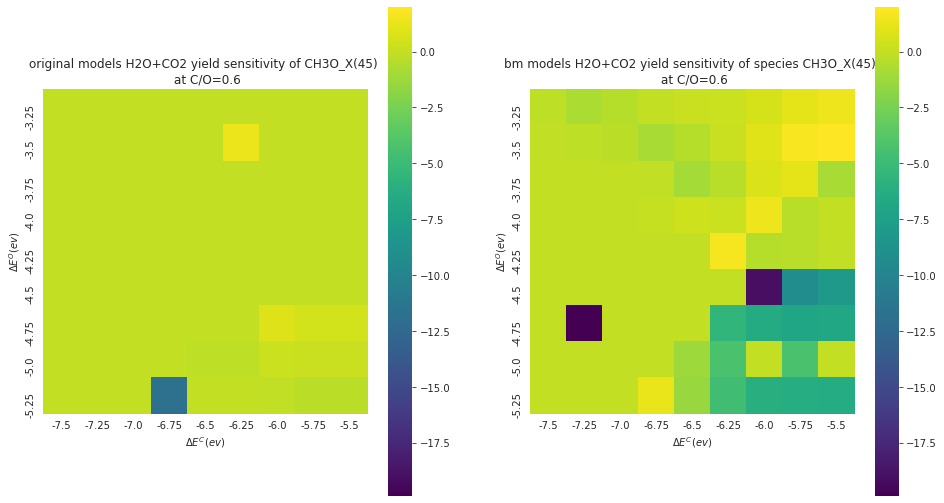

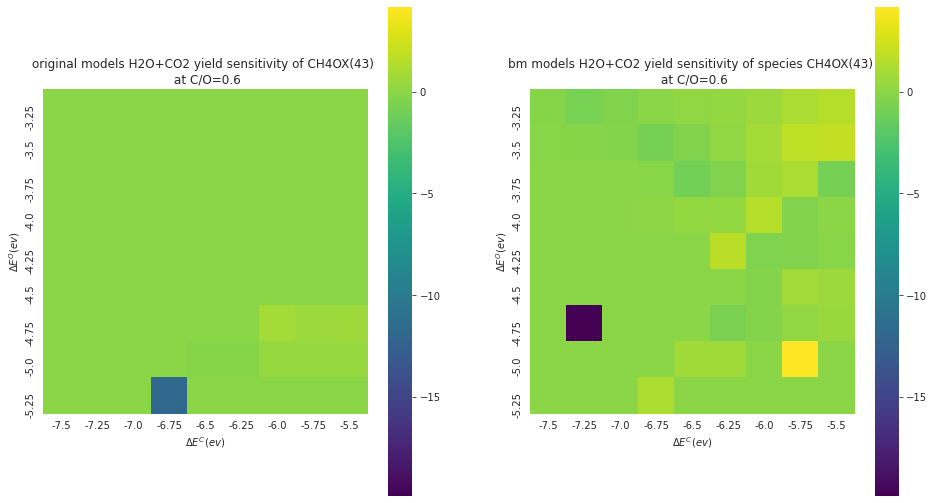

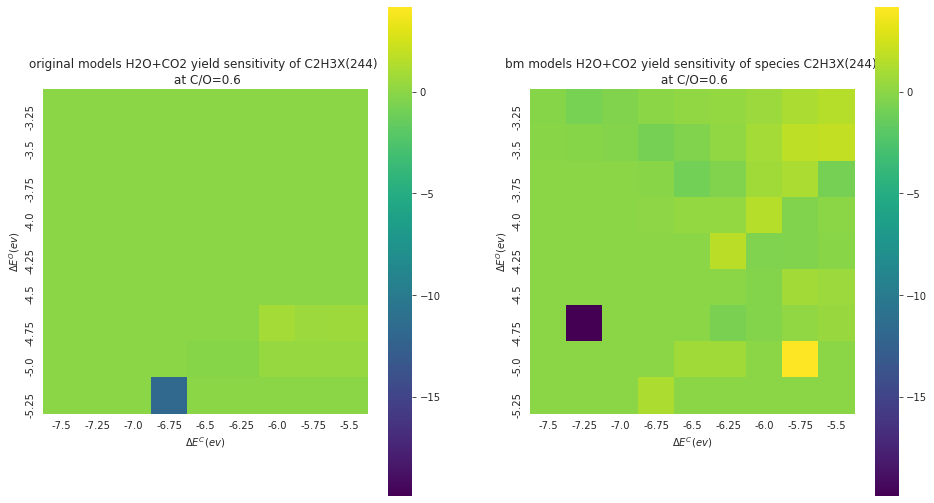

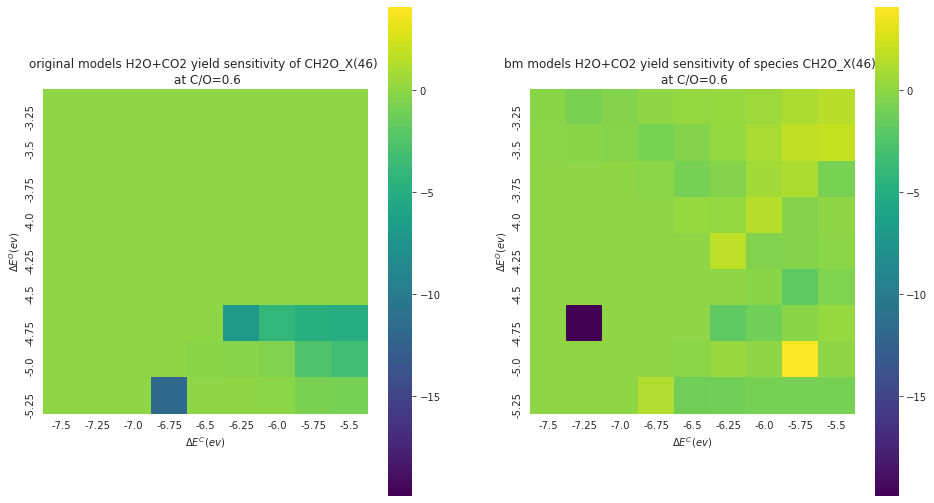

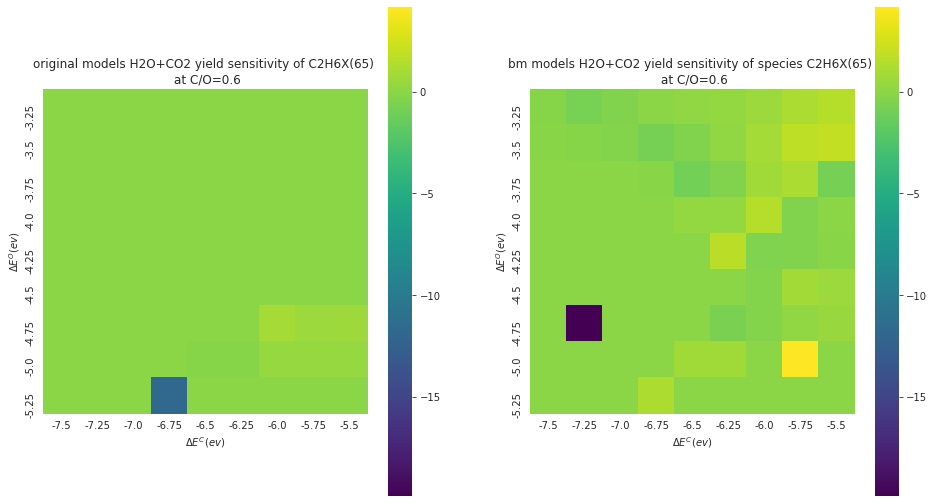

In [7]:
# CO2+H20 yield
for i in range(1, 20):
    heat_map_gen(i, 10, 0.6, 100)

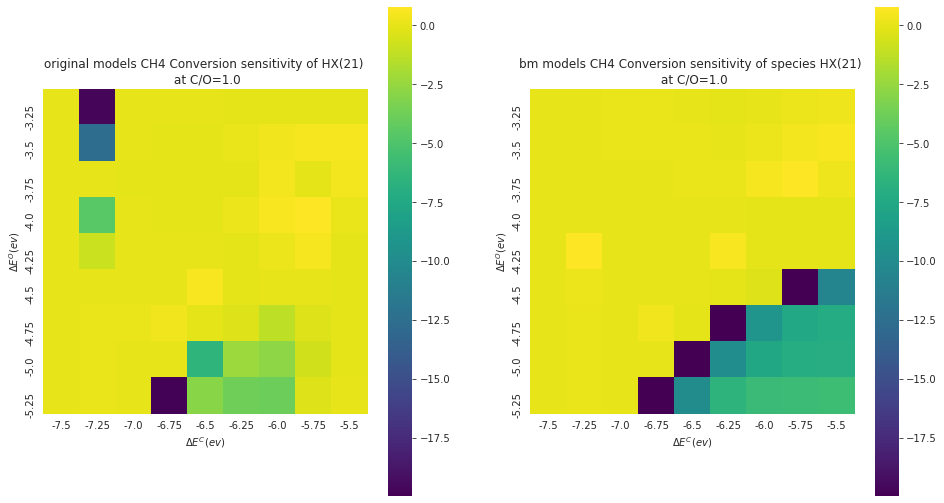

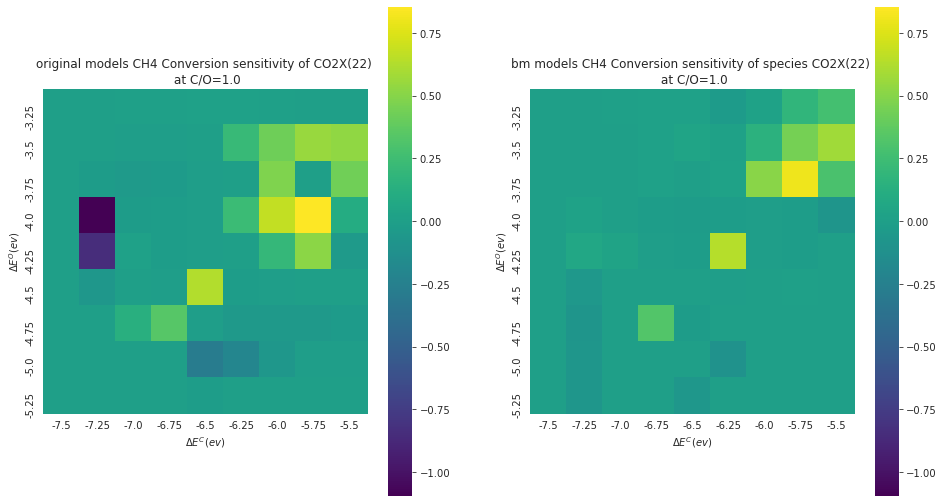

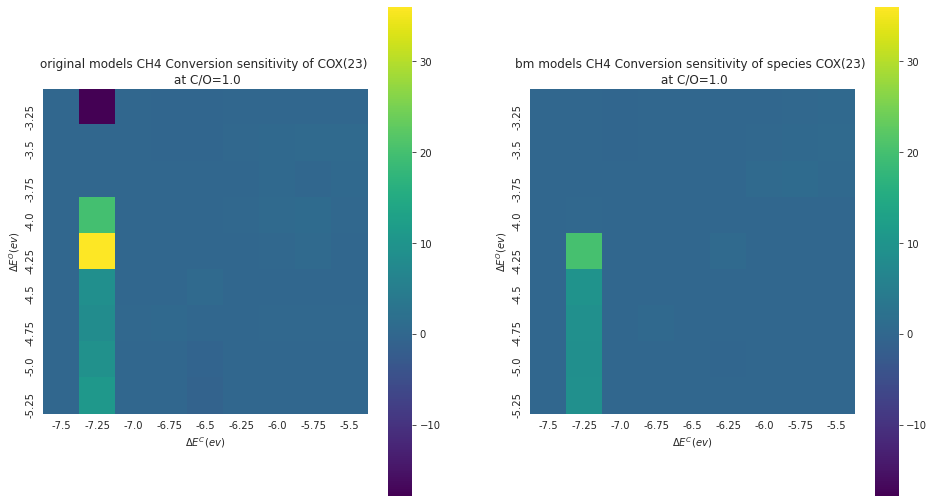

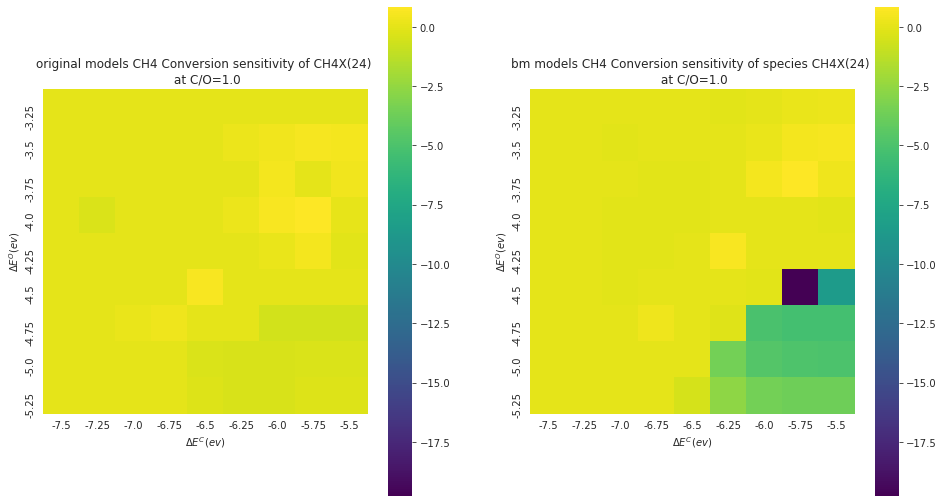

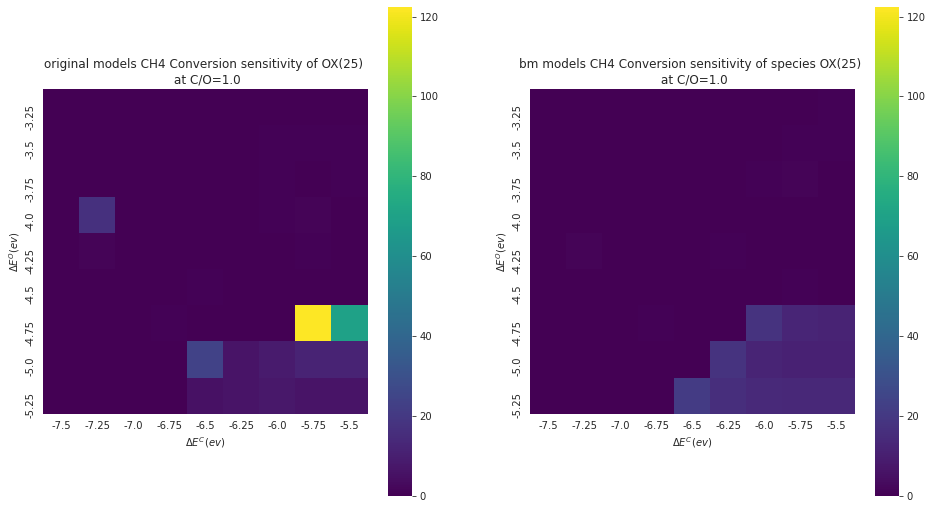

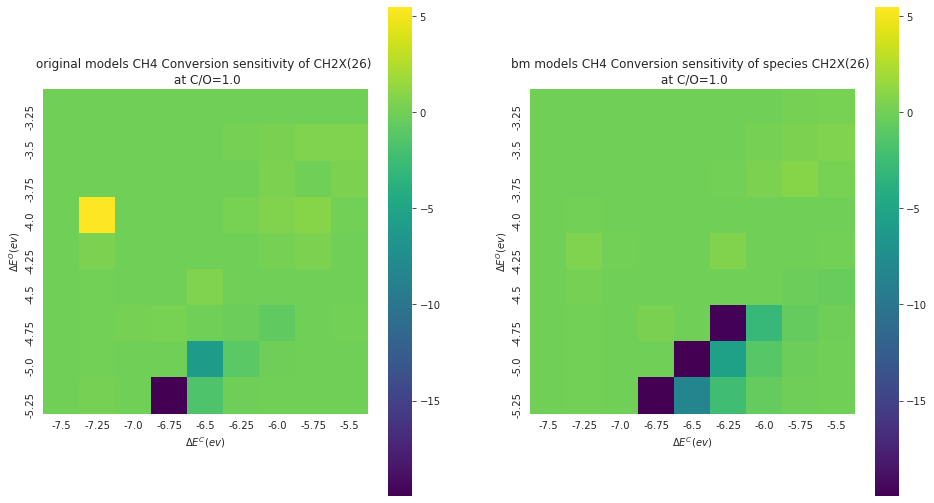

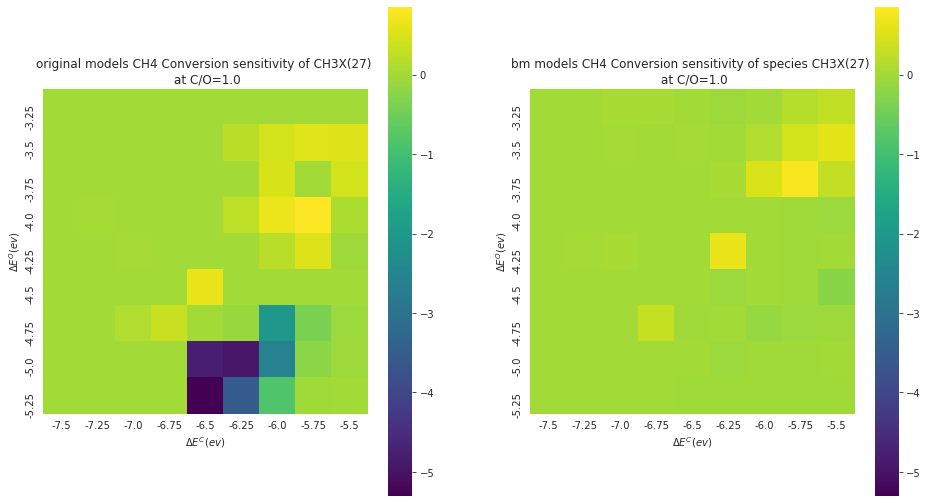

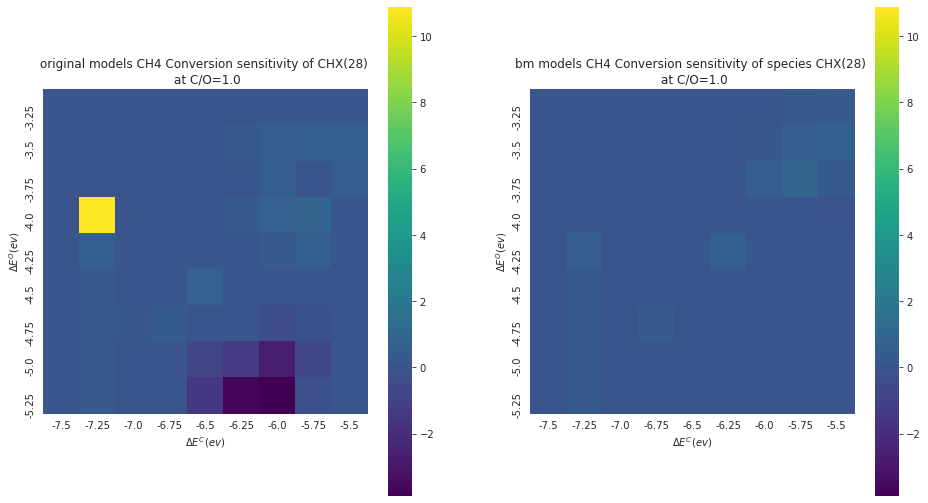

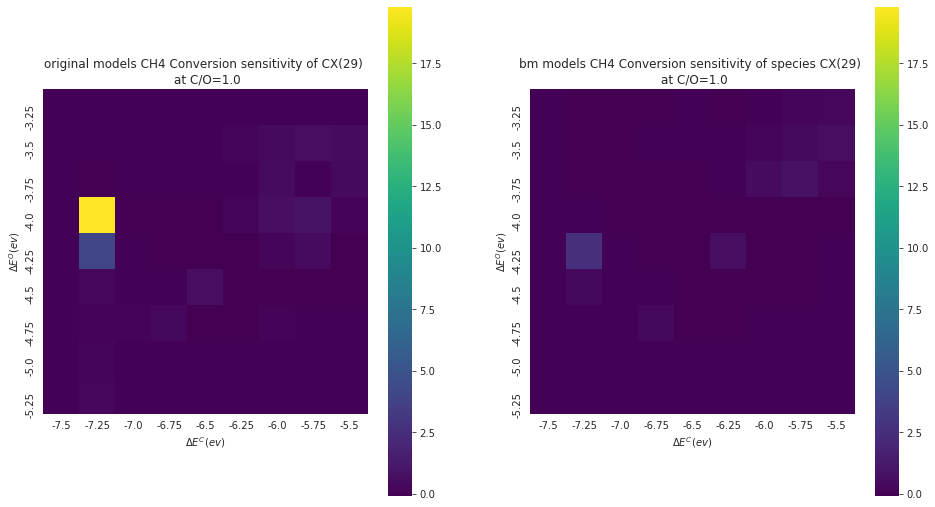

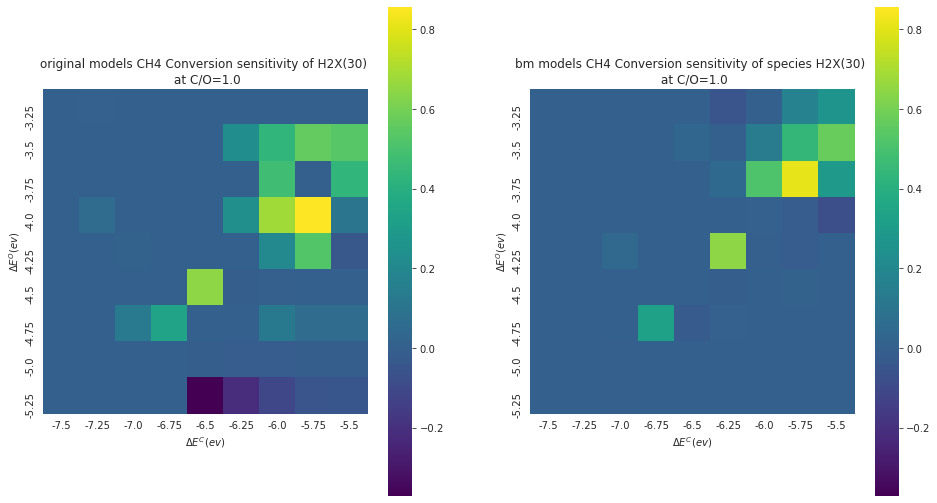

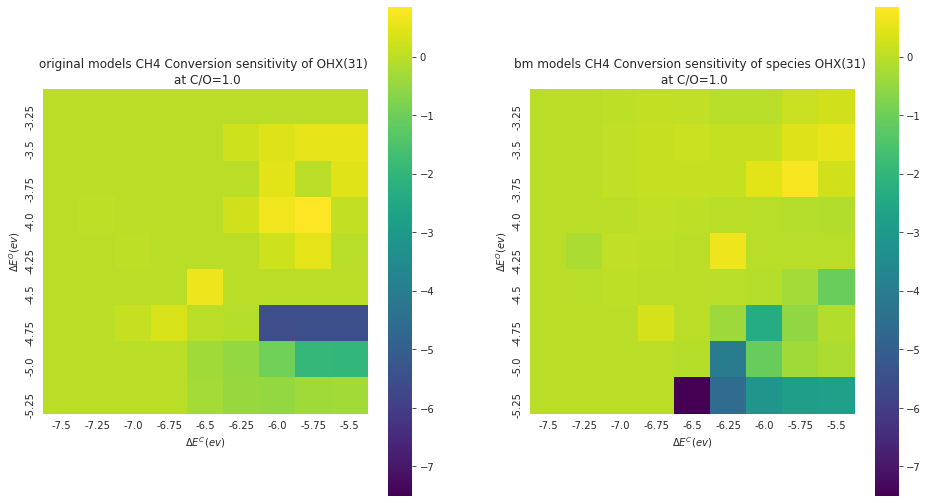

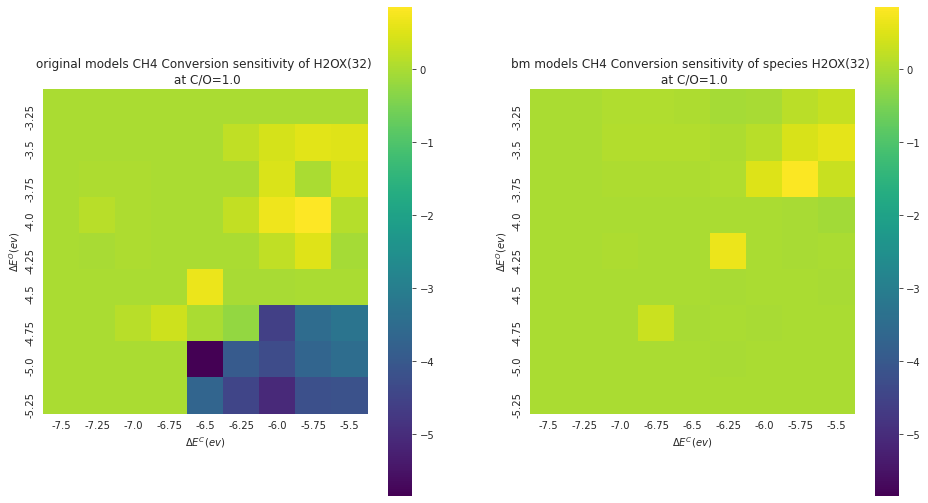

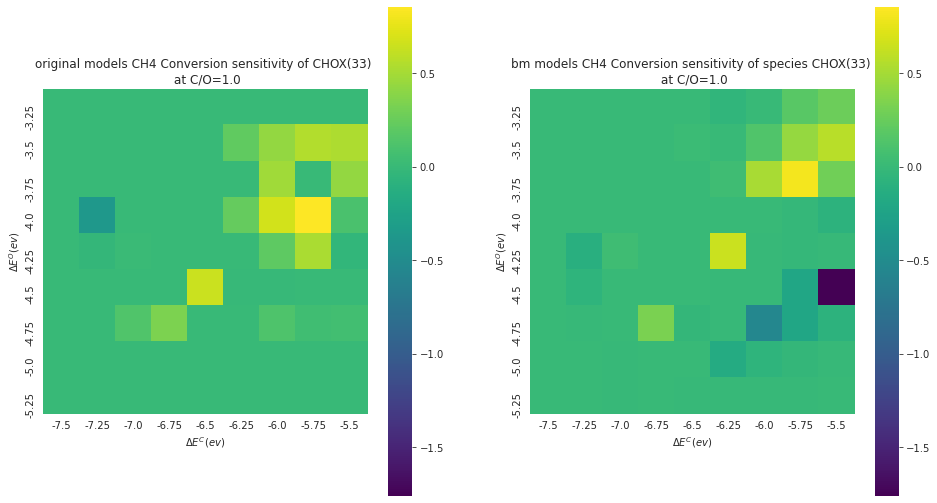

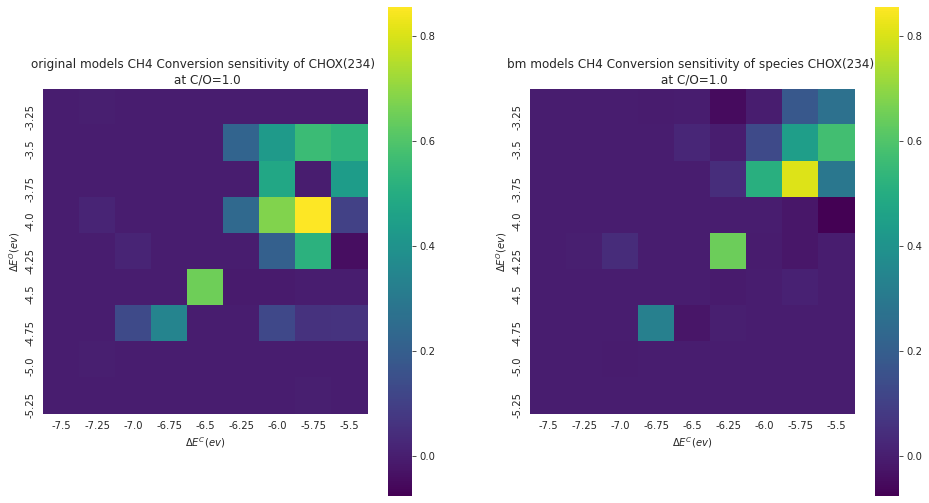

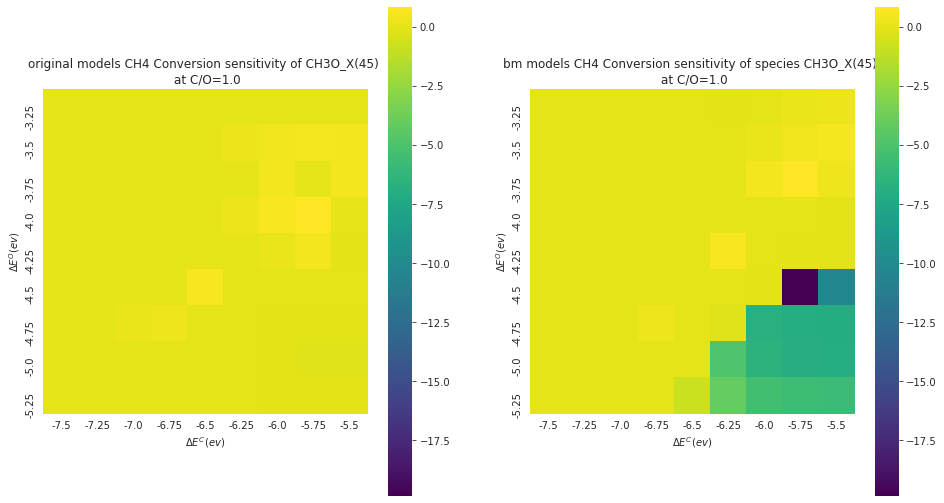

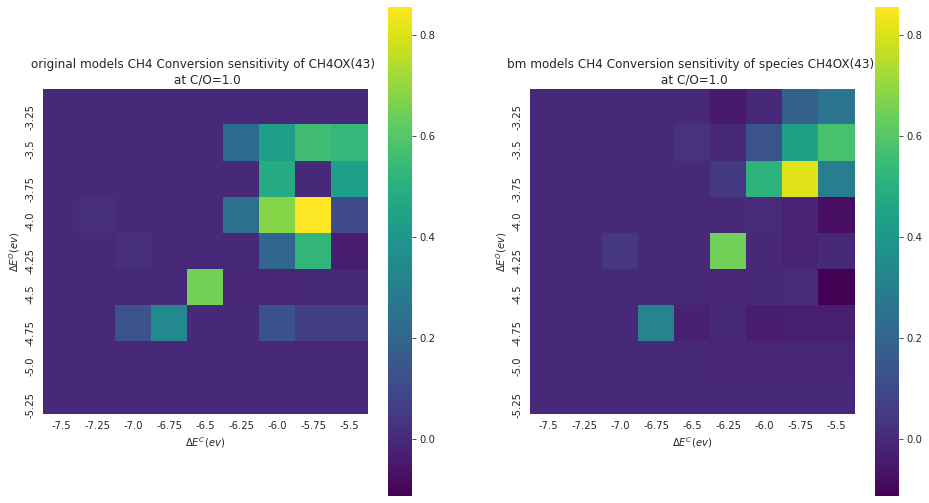

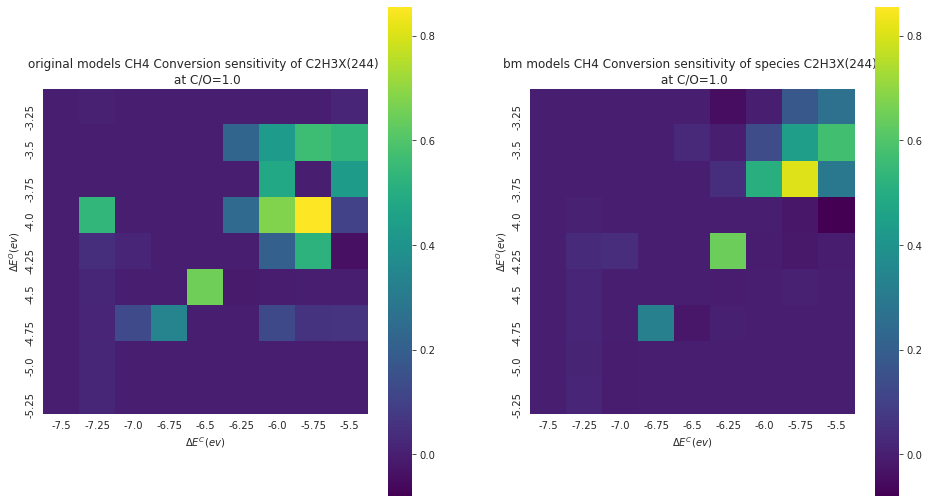

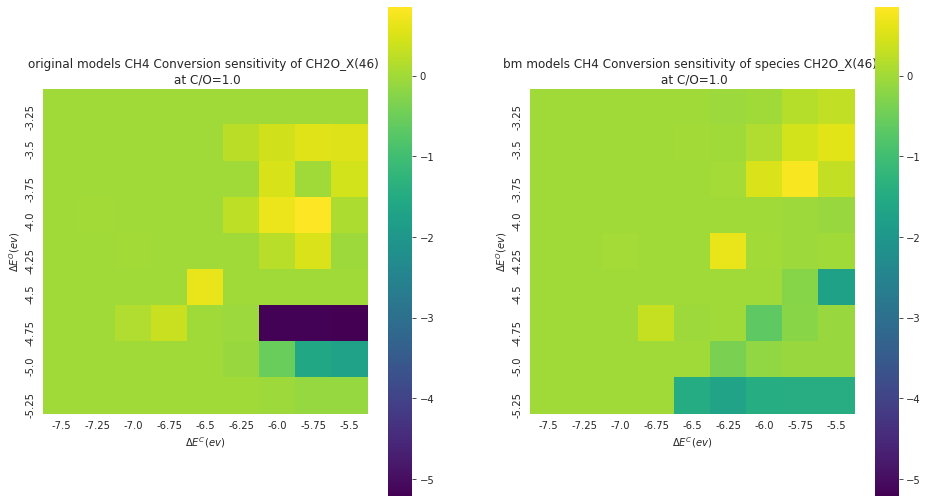

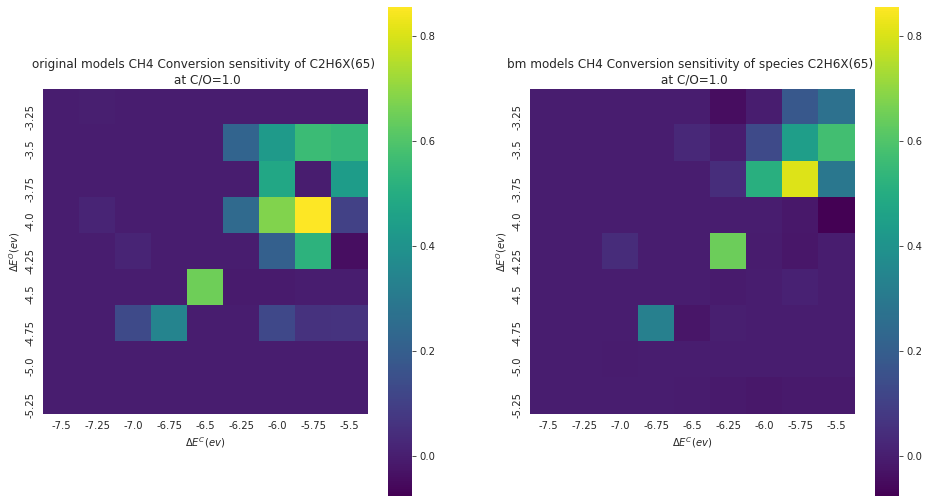

In [4]:
# CH4 conversion
for i in range(1, 20):
    heat_map_gen(i, 8, 1.0, 1000)

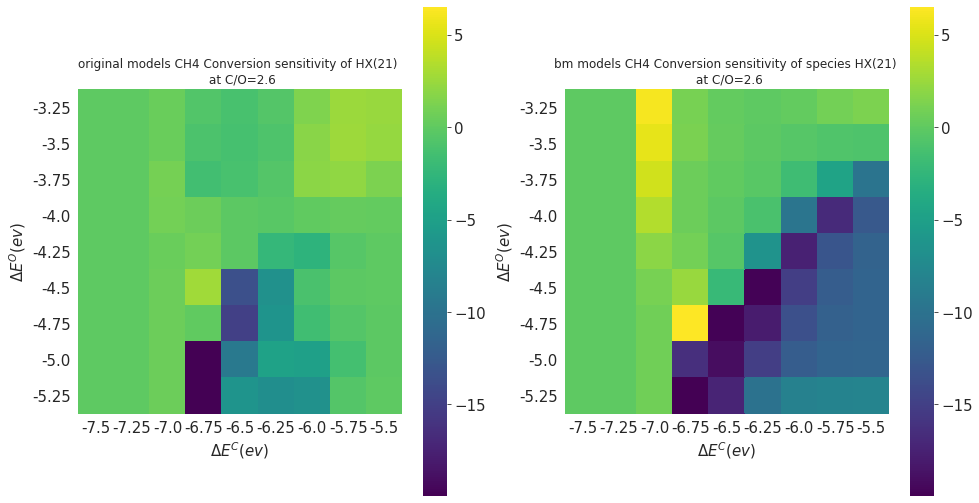

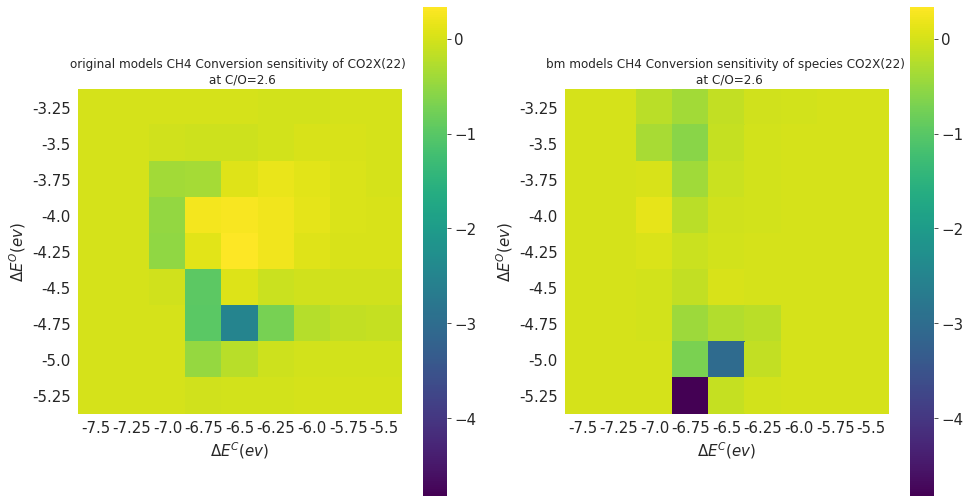

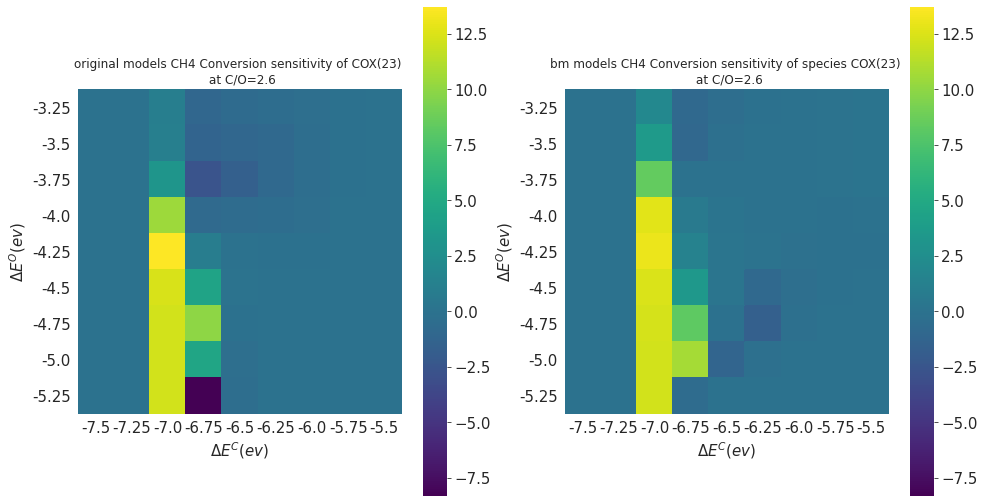

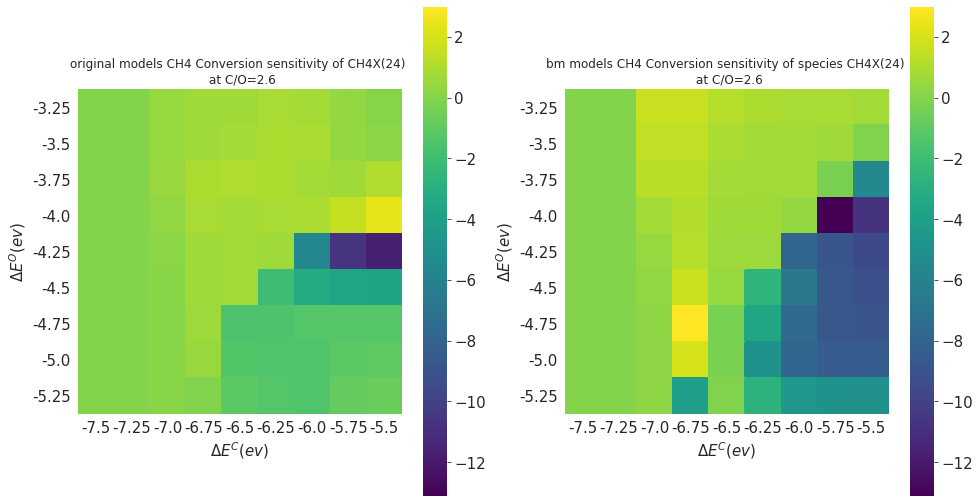

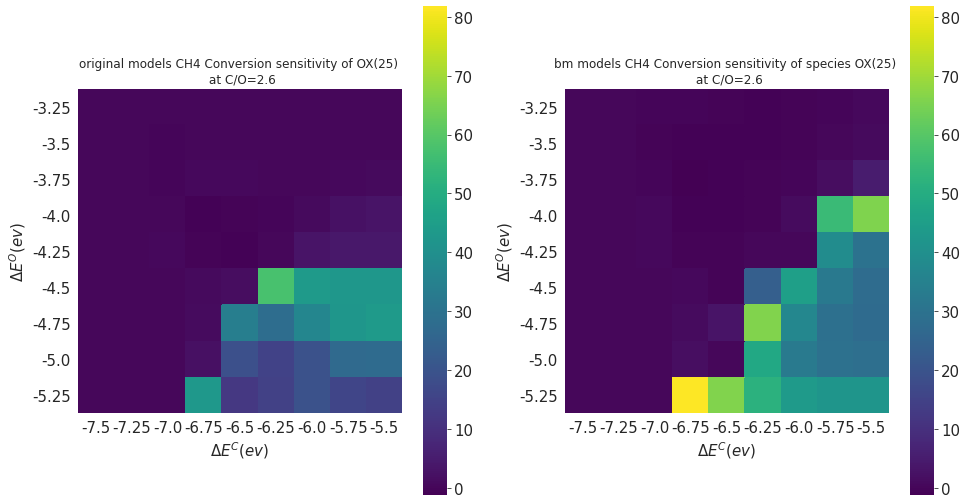

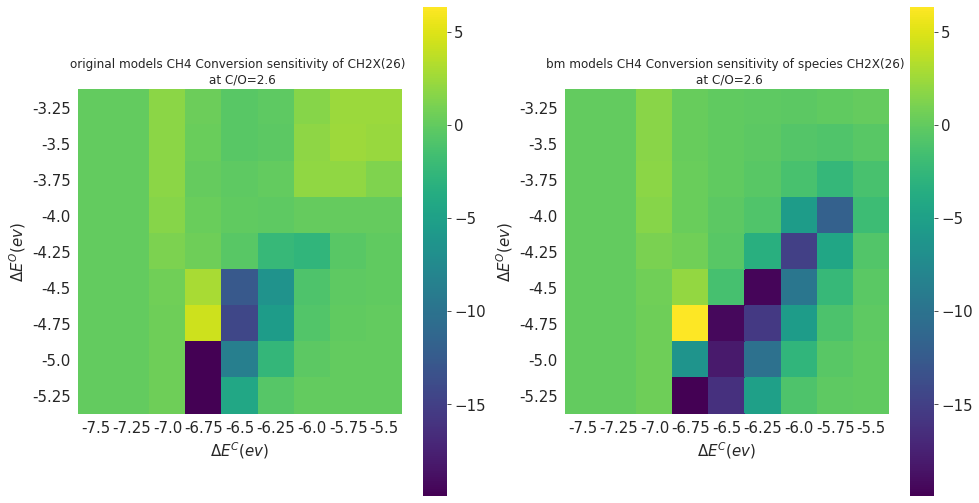

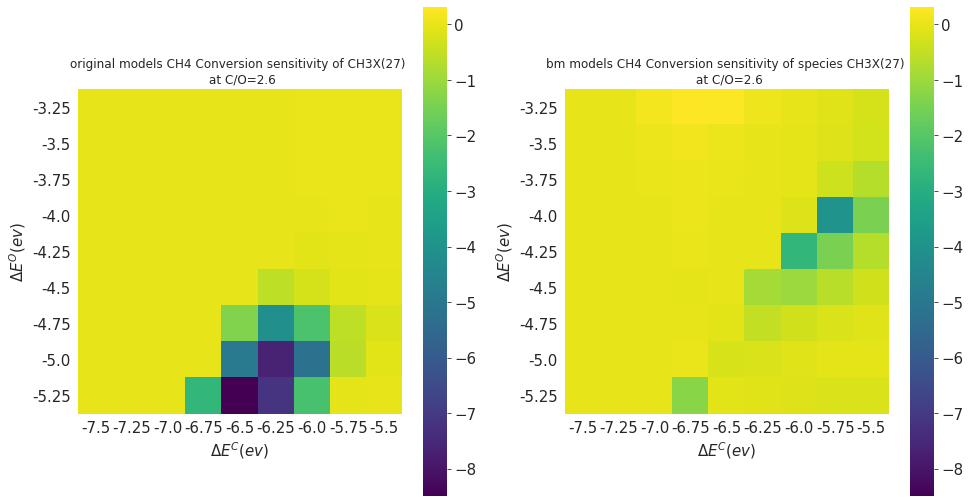

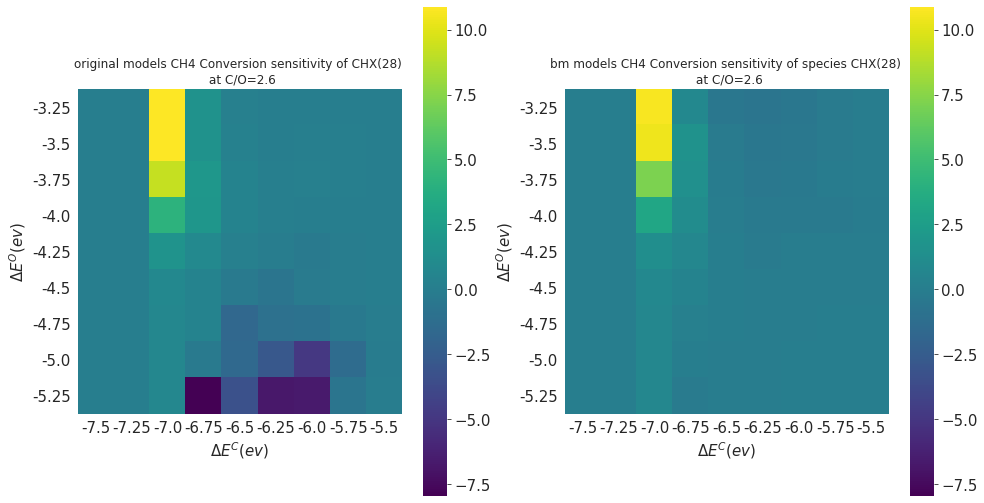

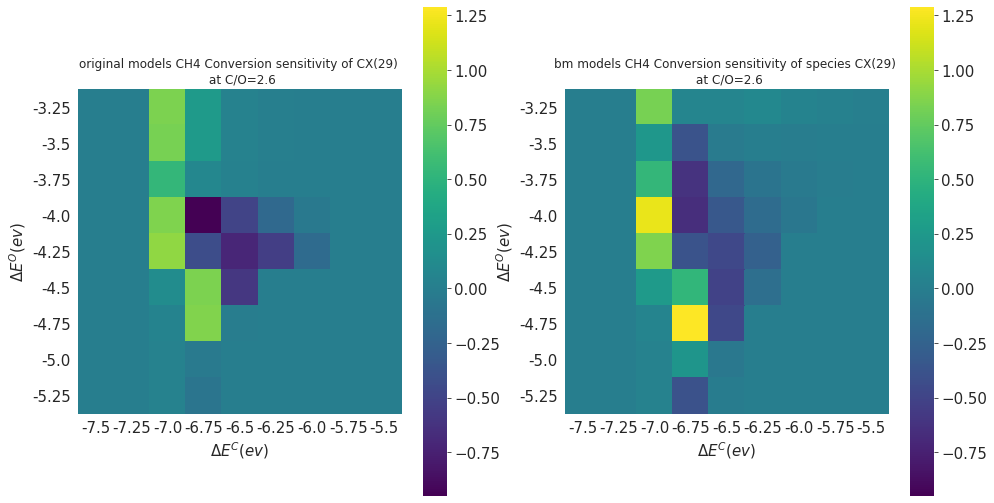

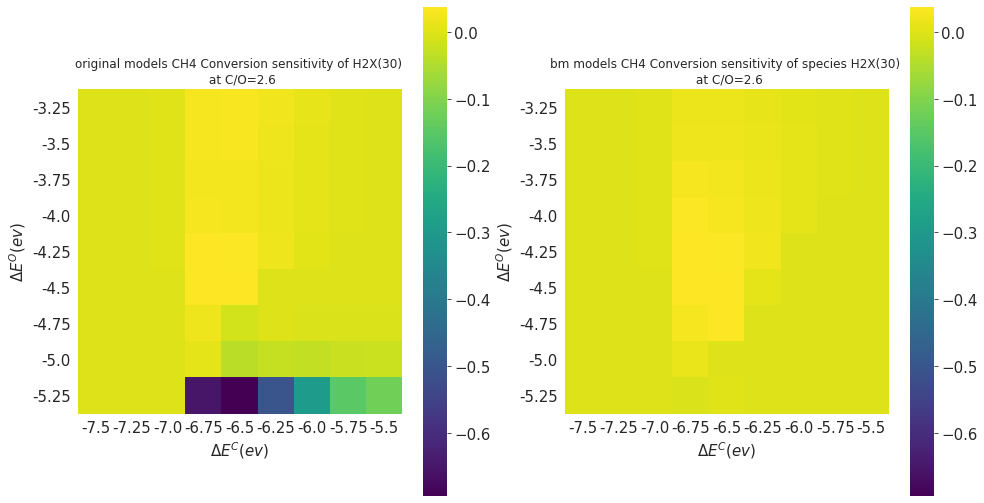

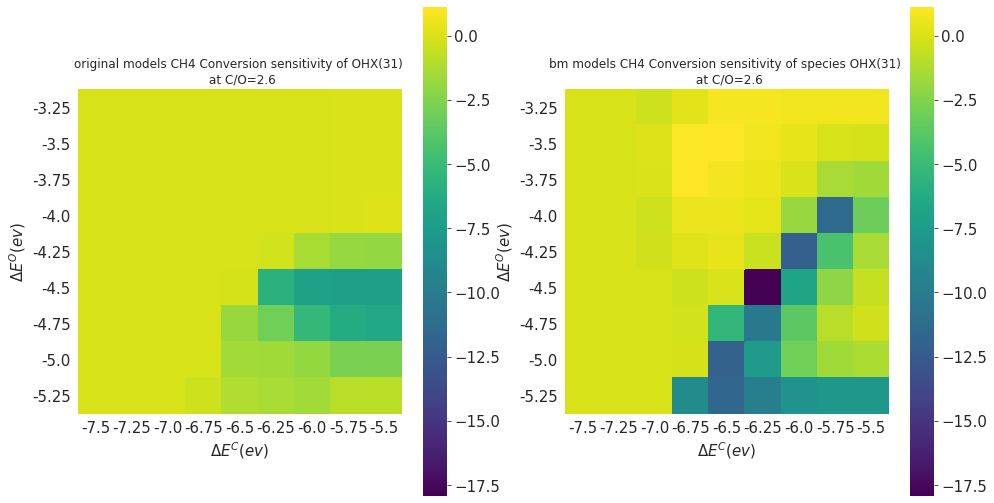

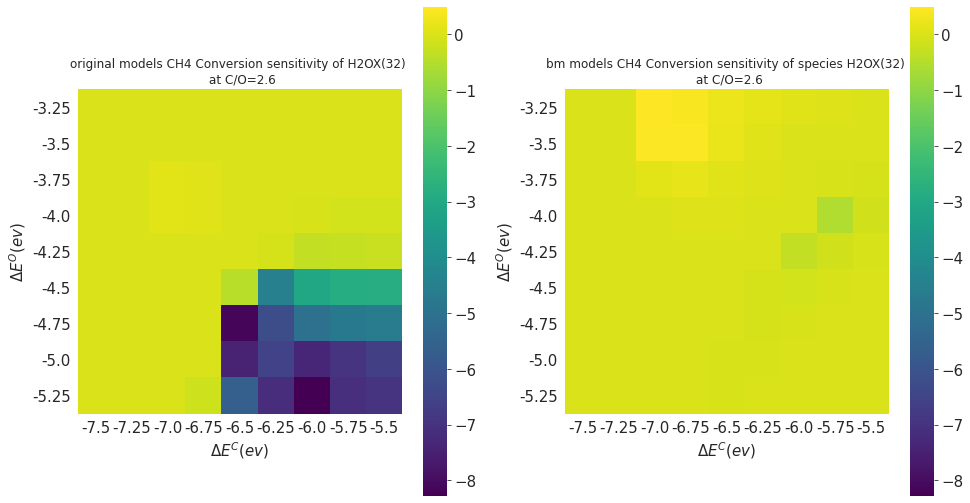

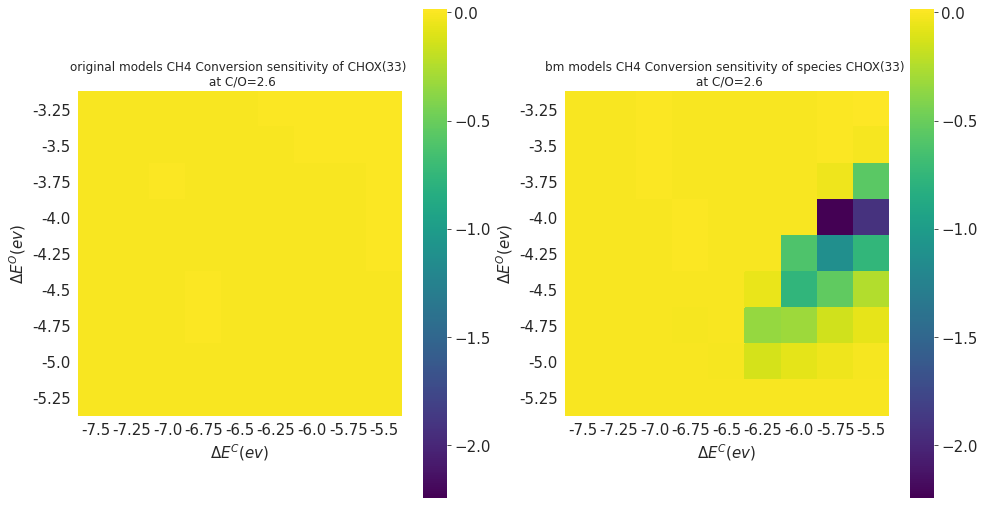

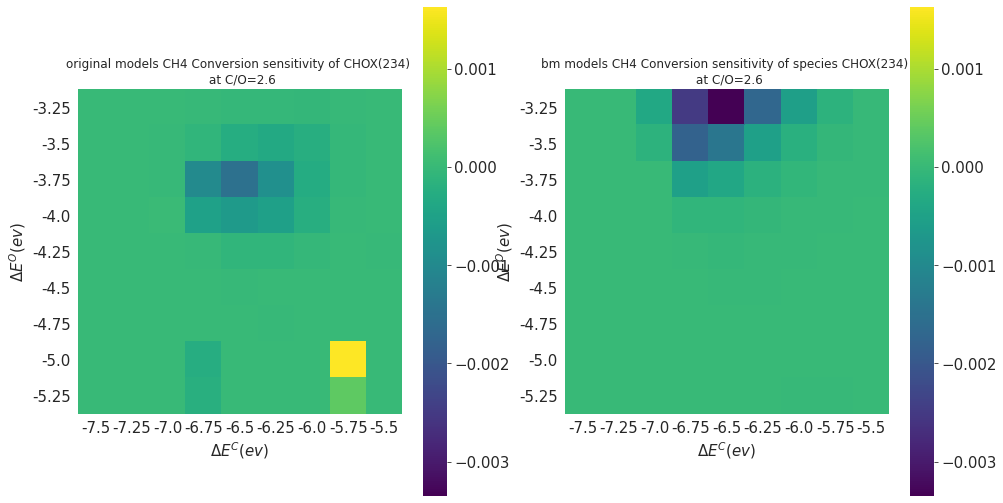

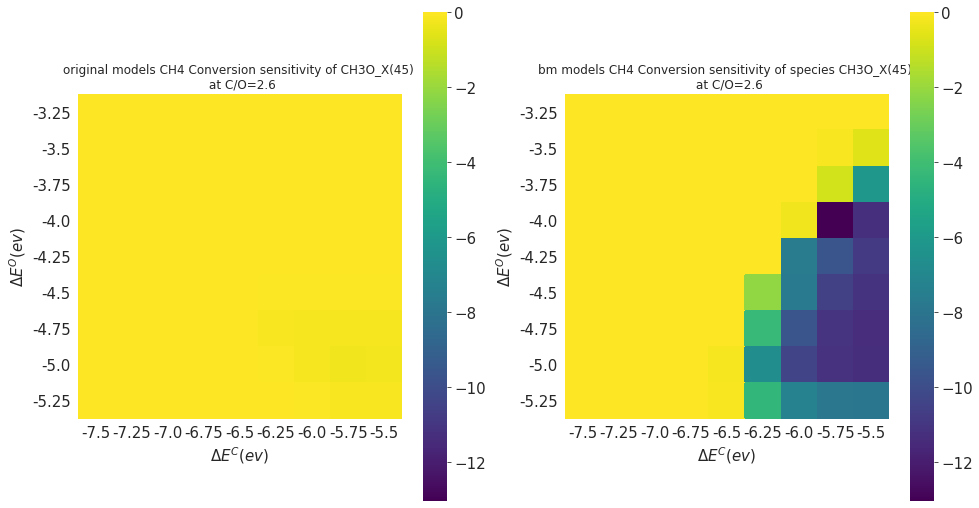

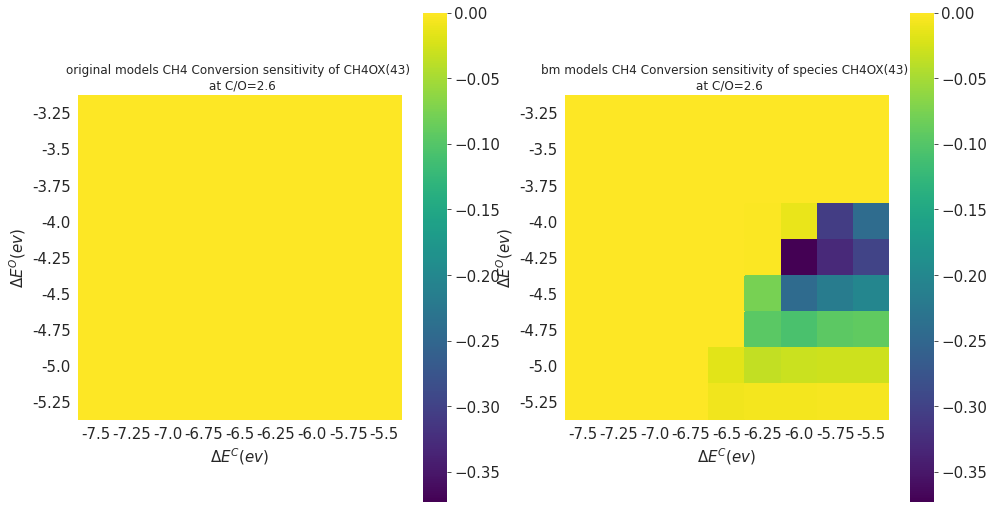

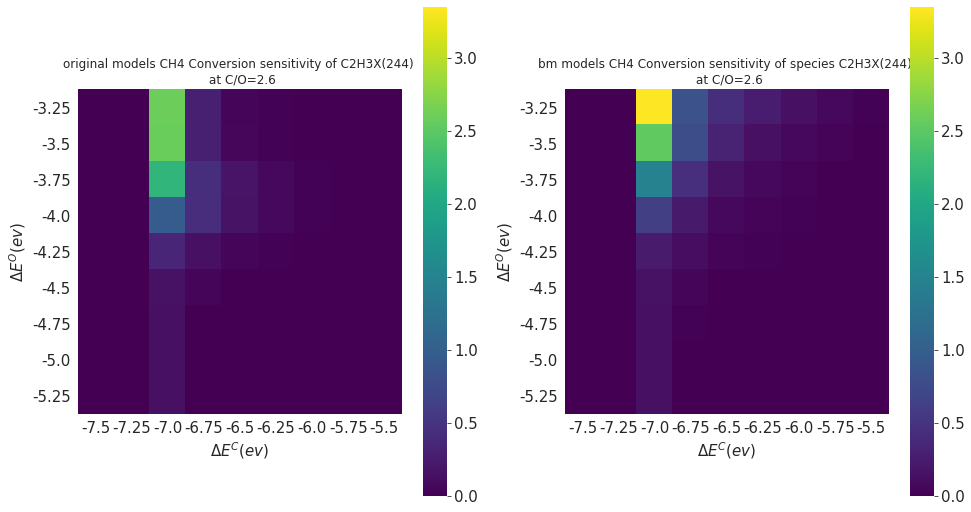

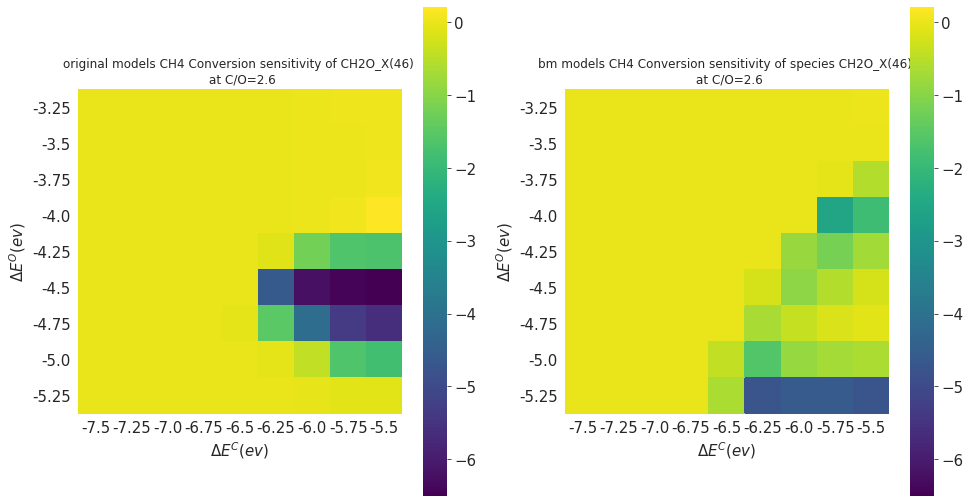

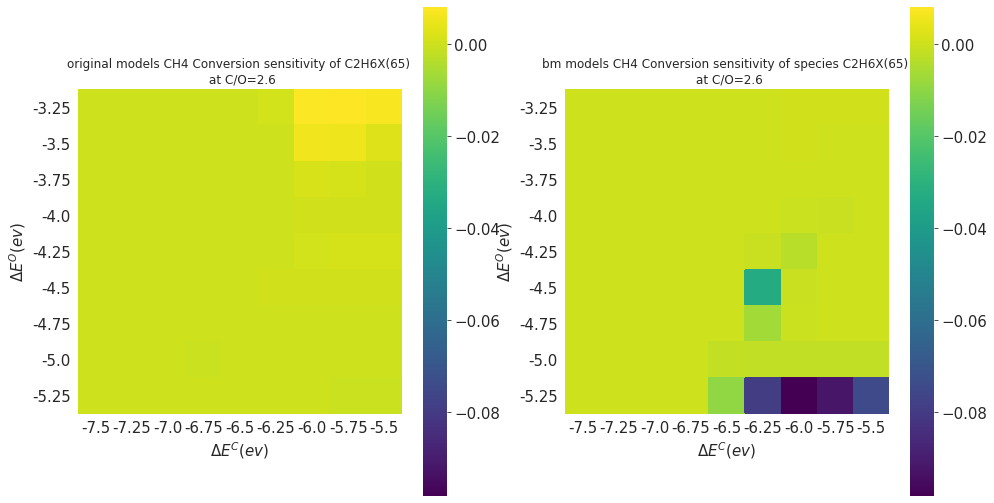

In [23]:
# CH4 Conversion
for i in range(1, 20):
    heat_map_gen(i, 8, 2.6, 100)

In [9]:
zero_ori_surfaces = [7, 8, 9, 16, 17, 18, 25, 26, 27, 35, 36, 44,45,68, 69, 70, 71, 72, 
                 73, 74, 75, 76, 77, 78, 79, 80, 81]
zero_bm_surfaces = [6, 7, 8, 9, 16, 17, 18, 25, 26, 27, 35, 36,45,68, 69, 70, 71, 72, 
                 73, 74, 75, 76, 77, 78, 79, 80, 81]

In [18]:
zero_ori_surfaces = [7, 8, 9, 16, 17, 18, 26, 27, 35, 36,45,64,65,66,67,68, 69, 70, 71, 72, 
                 73, 74, 75, 76, 77, 78, 79, 80, 81]
zero_bm_surfaces = [7, 8, 9, 16, 17, 18, 26, 27, 35, 36,45,64,65,66,67,68, 69, 70, 71, 72, 
                 73, 74, 75, 76, 77, 78, 79, 80, 81]

In [19]:
def heat_map_gen(sp, property_, ratio, threshold):
    """
    sp: index of species
    property_: index of the property to plot
    ratio: the C/O input ratio
    threshold: threshold to rule out the outliers
    """
    benergy_c = np.arange(-7.5, -5.25, 0.25)
    benergy_o = np.arange(-3.25, -5.5, -0.25)
    data_original = np.zeros((len(benergy_c), len(benergy_o)))
    data_bm = np.zeros((len(benergy_c), len(benergy_o)))
    parent_dir = os.path.dirname(os.getcwd())
    # read the first file to extract the species and properties list
    f = f'{parent_dir}/base_original/binding_energies/1.0_c-5.50o-3.25/thermo_sensitivity_data/0.6_sens_data.csv'
    df = pd.read_csv(f)
#     species = df.loc[:, 'Species'].to_list()
    properties = df.columns.to_list()
    
    total = 81
    i = -1
    paths = []
    for c_binding_energy in benergy_c:
        i += 1
        j = -1
        index = total - ((7.5 - abs(c_binding_energy)) / 0.25 + 1) * 9
        for o_binding_energy in benergy_o:
            j += 1
            index += 1

            if index not in zero_ori_surfaces:
                # read the simulation files
                original_path_sens = '{}/base_original/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
                if os.path.exists(original_path_sens):
                    df_original = pd.read_csv(original_path_sens)
                    charac_sens_original = df_original.loc[df_original['Species'] == sp].iloc[:,property_].to_list()[0]
                    if abs(charac_sens_original) >= threshold:
                        data_original[j][i] = 0
                    else:
                        data_original[j][i] = charac_sens_original
                    
            if index not in zero_bm_surfaces:
                bm_path_sens = '{}/base_bm/binding_energies/{}_c{:.2f}o{:.2f}/thermo_sensitivity_data/{}_sens_data.csv'.format(parent_dir, index, c_binding_energy, o_binding_energy, ratio)
                if os.path.exists(bm_path_sens):
                    df_bm = pd.read_csv(bm_path_sens)
                    charac_sens_bm = df_bm.loc[df_bm['Species'] == sp].iloc[:,property_].to_list()[0]
                    if abs(charac_sens_bm) >= threshold:
                        data_bm[j][i] = 0
                    else:
                        data_bm[j][i] = charac_sens_bm

    original_df = pd.DataFrame(data_original, columns=benergy_c, index=benergy_o)
    bm_df = pd.DataFrame(data_bm, columns=benergy_c, index=benergy_o)
    minimum = min(original_df.min().min(), bm_df.min().min())
    maximum = max(original_df.max().max(), bm_df.max().max())
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(121, aspect='equal')
    ax2 = fig.add_subplot(122, aspect='equal')
    cmap = sns.color_palette("viridis", as_cmap=True)
    ax1 = sns.heatmap(original_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax1, vmin=minimum, vmax=maximum)
    ax1.set(title="original models {} sensitivity of {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
          xlabel="$\\Delta E^C(ev)$",
          ylabel="$\\Delta E^O(ev)$",)
    ax2 = sns.heatmap(bm_df, xticklabels=benergy_c, yticklabels=benergy_o, annot=False, cmap=cmap, ax=ax2, vmin=minimum, vmax=maximum)
    ax2.set(title="bm models {} sensitivity of species {} \n at C/O={}".format(properties[property_], species[sp].name, ratio),
          xlabel="$\\Delta E^C(ev)$",
          ylabel="$\\Delta E^O(ev)$",)
    plt.plot()

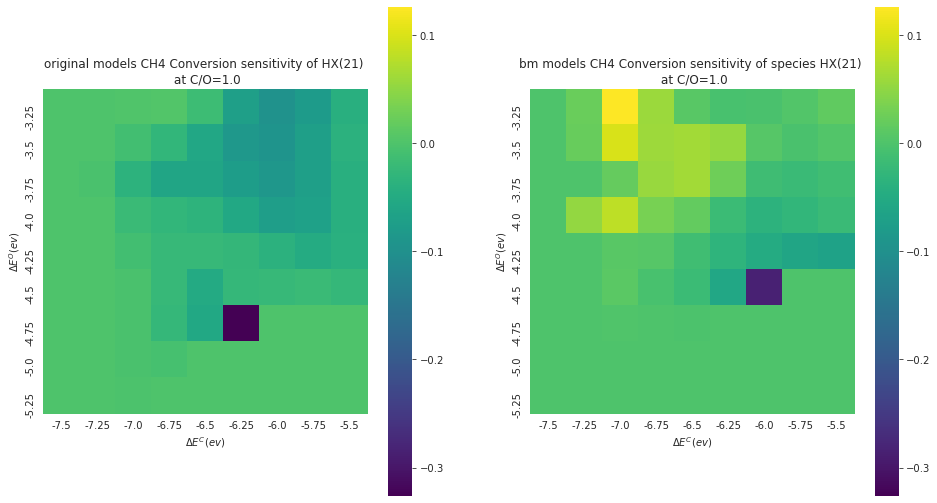

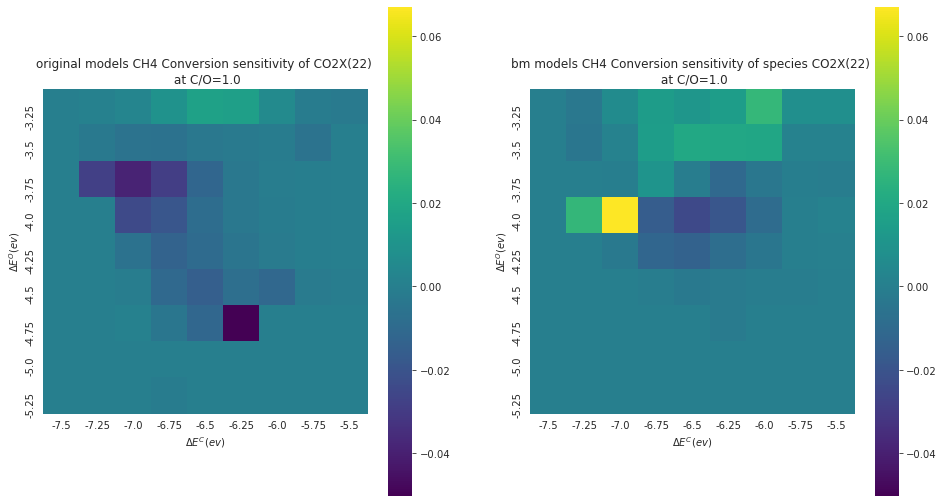

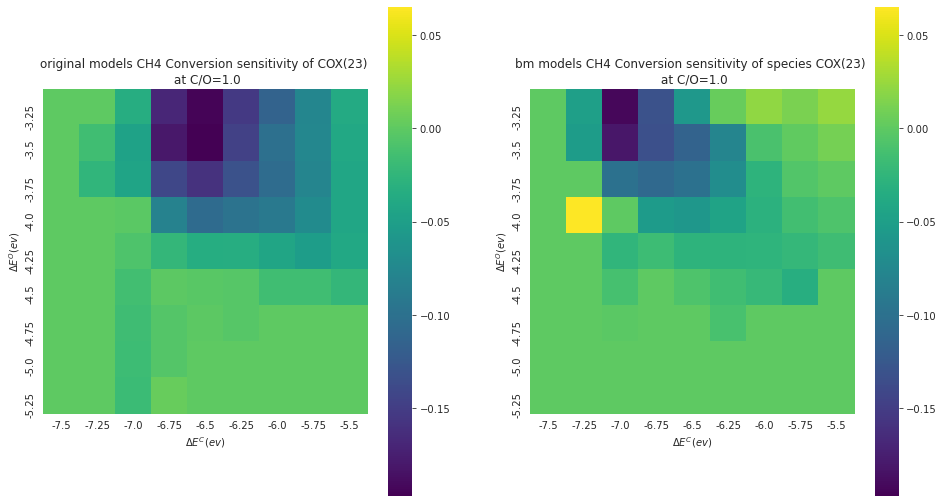

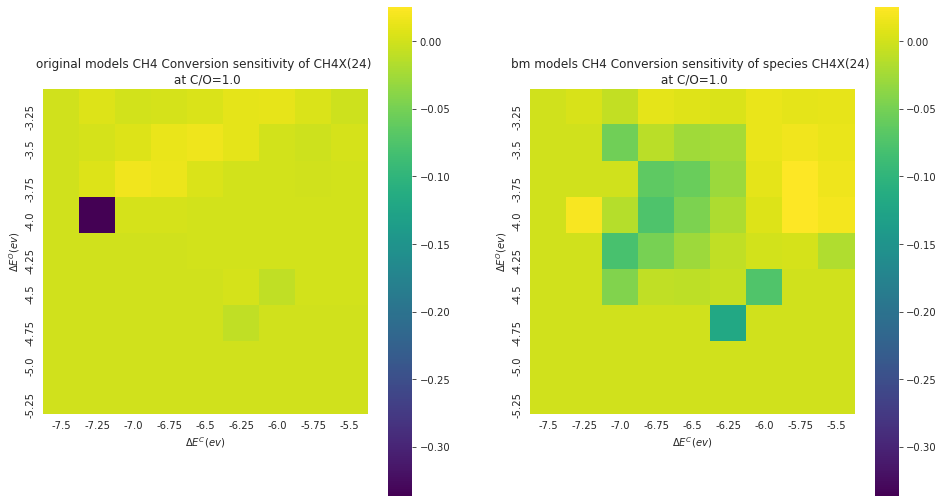

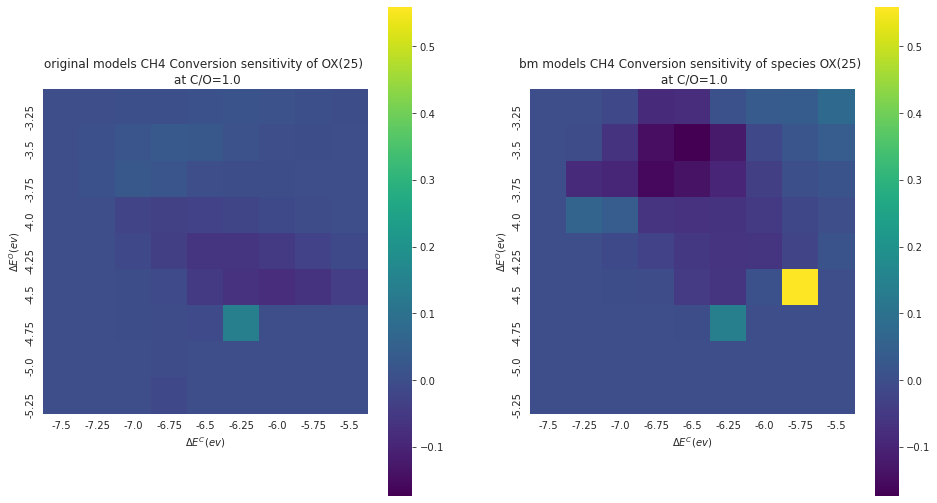

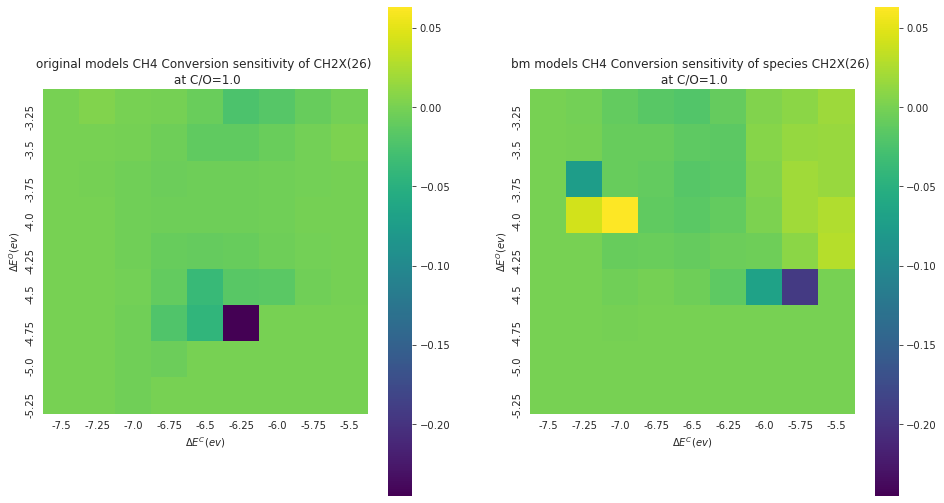

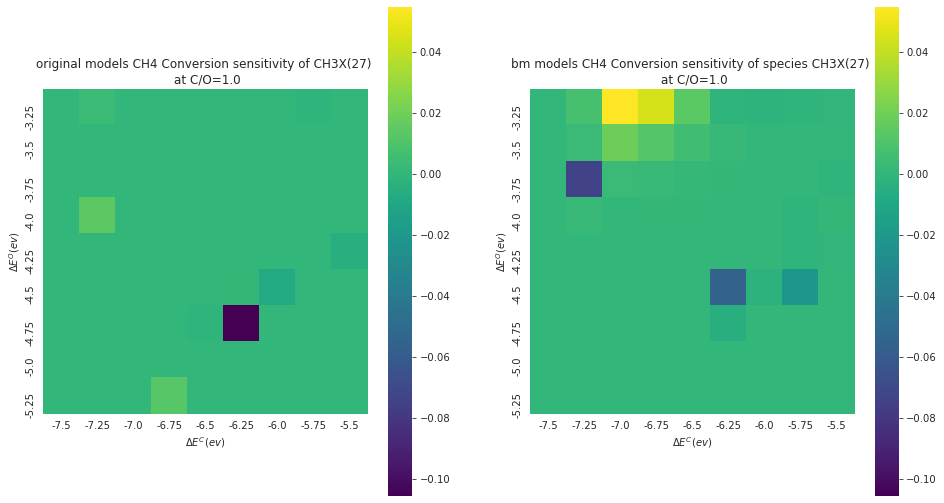

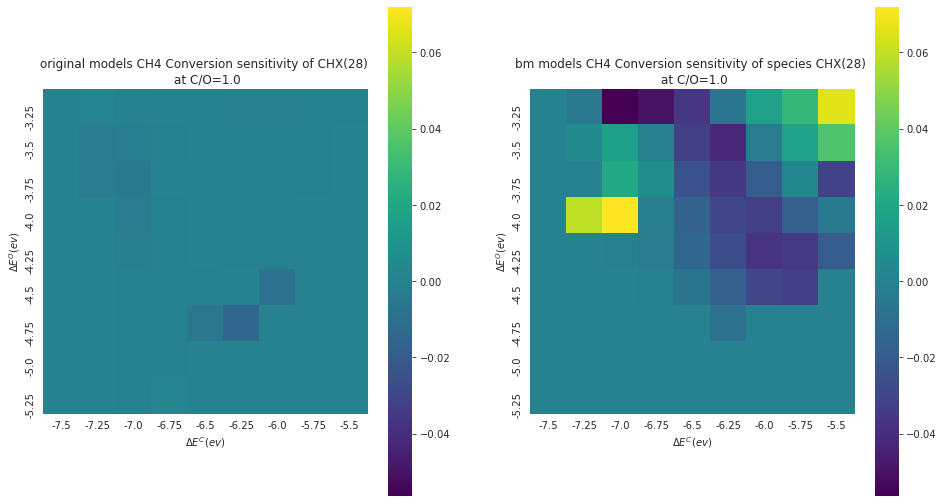

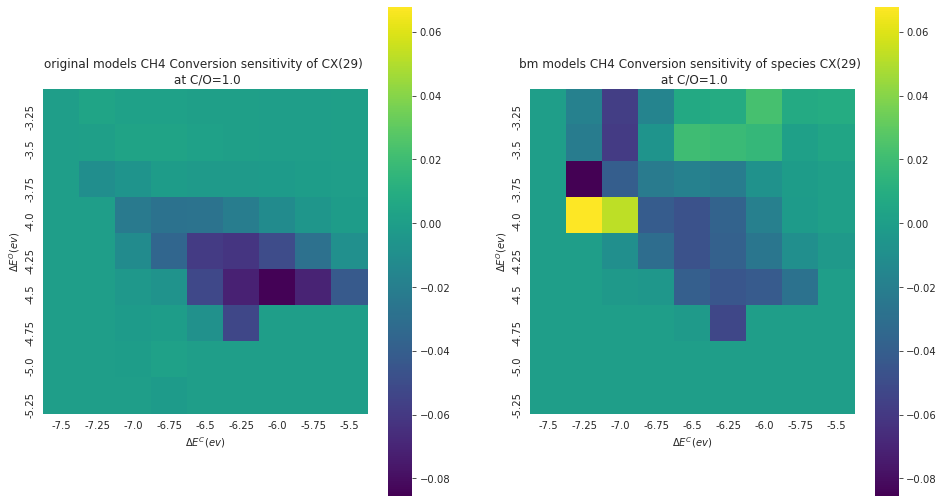

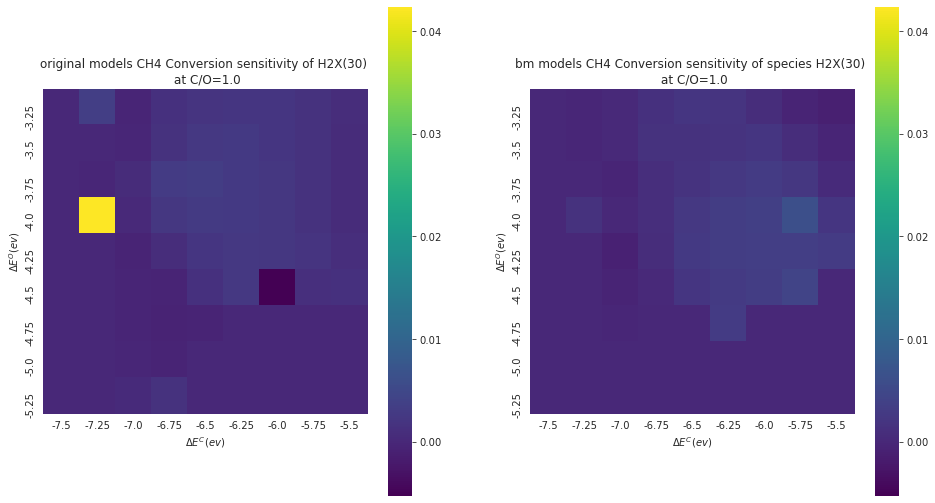

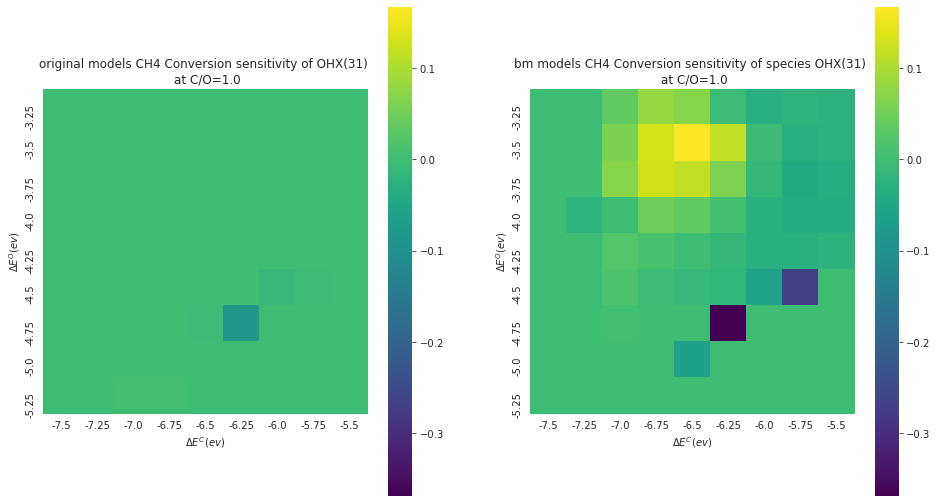

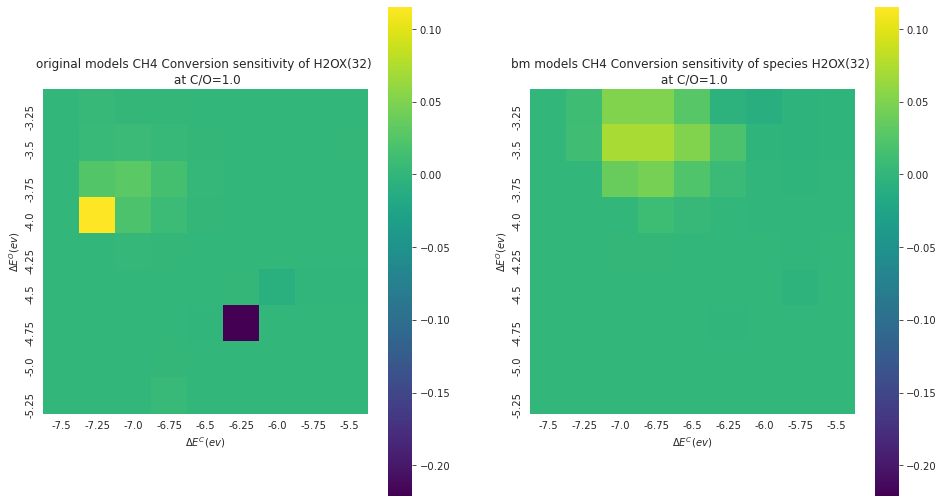

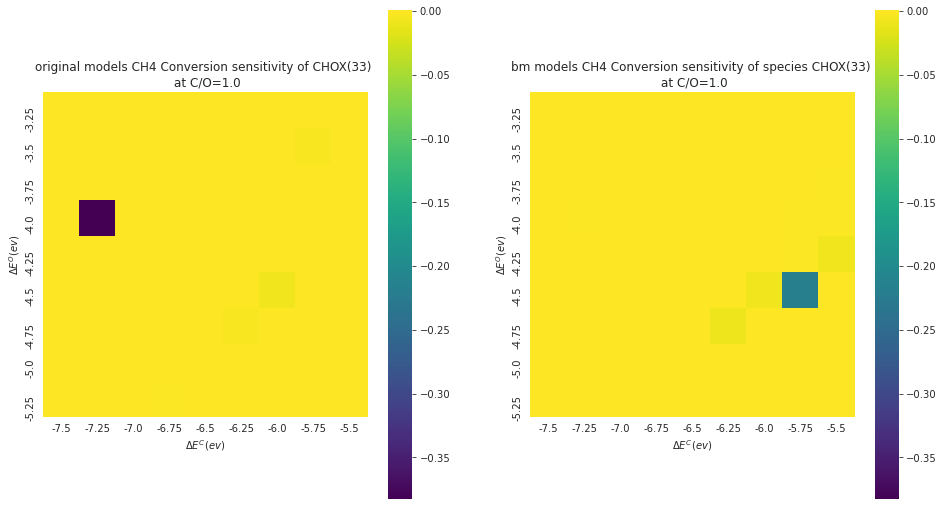

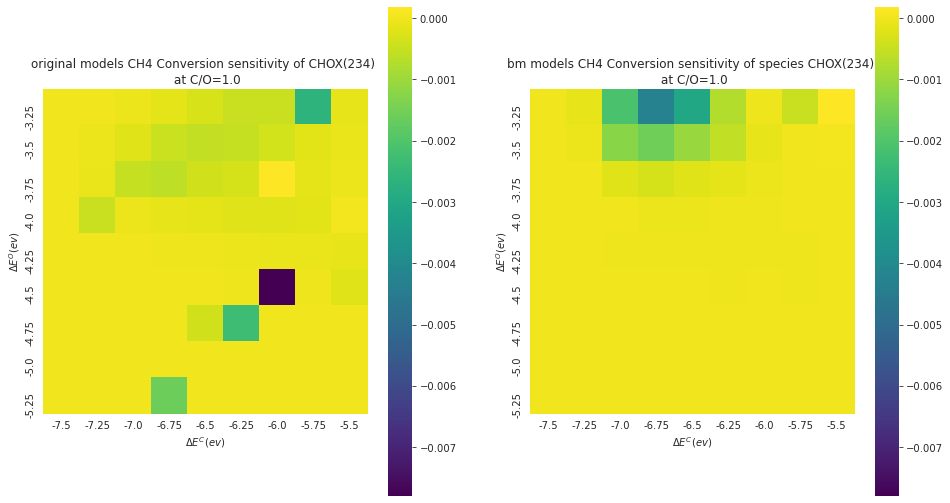

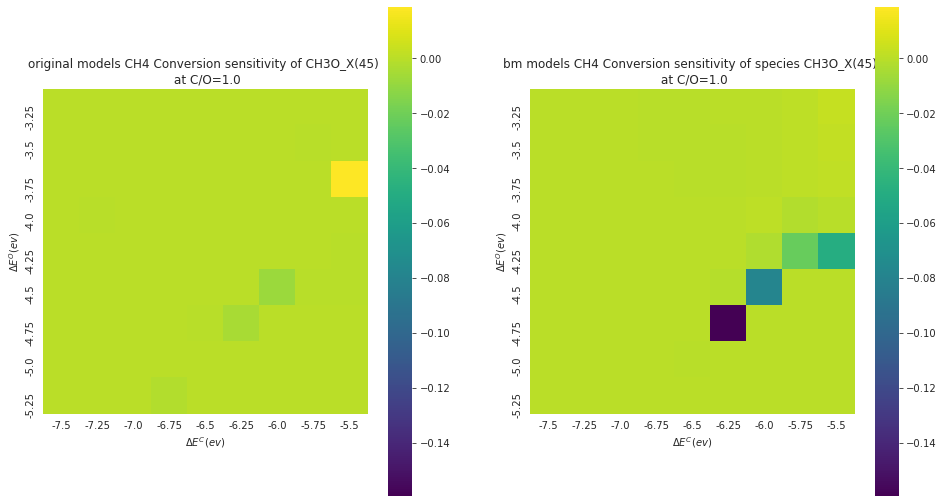

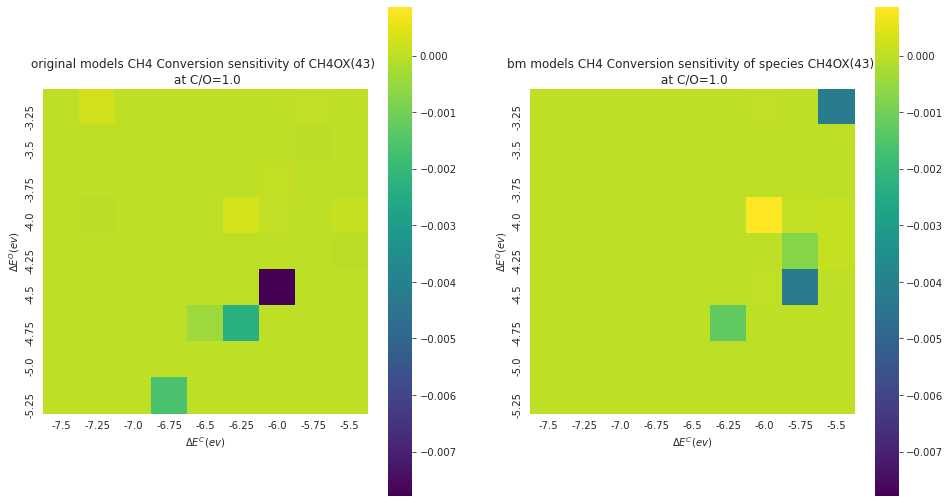

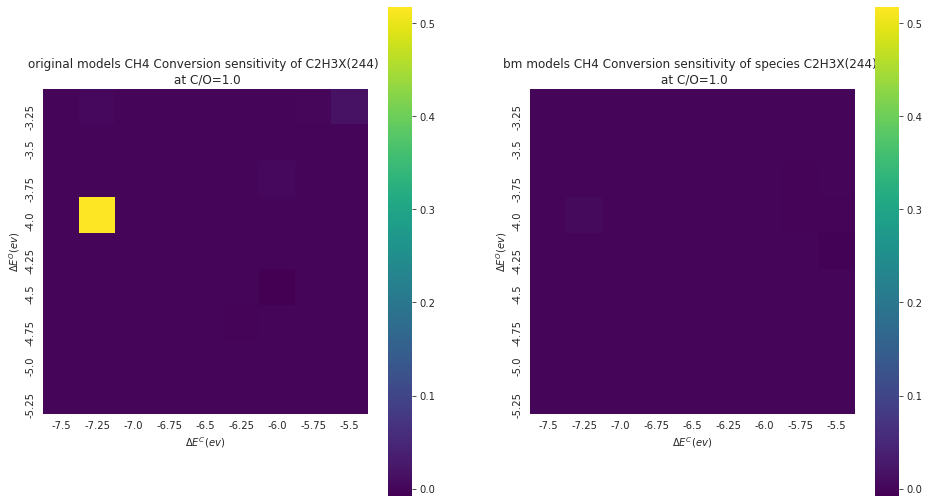

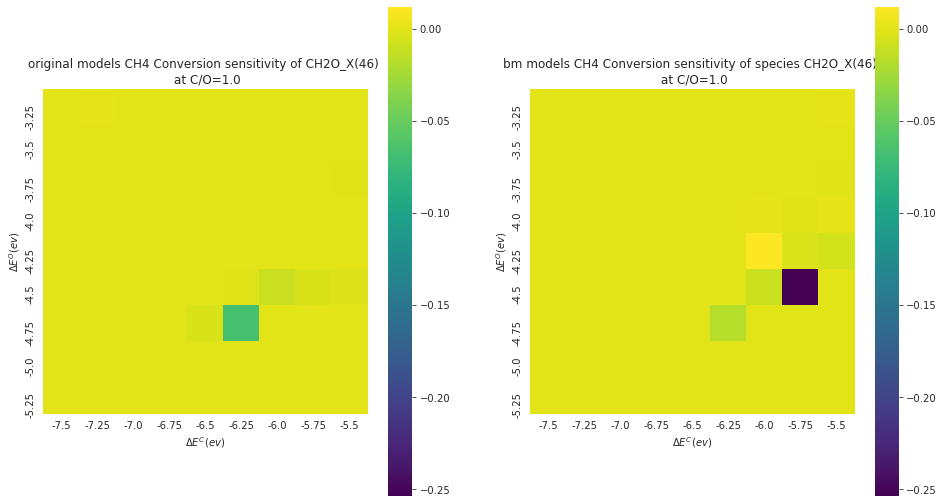

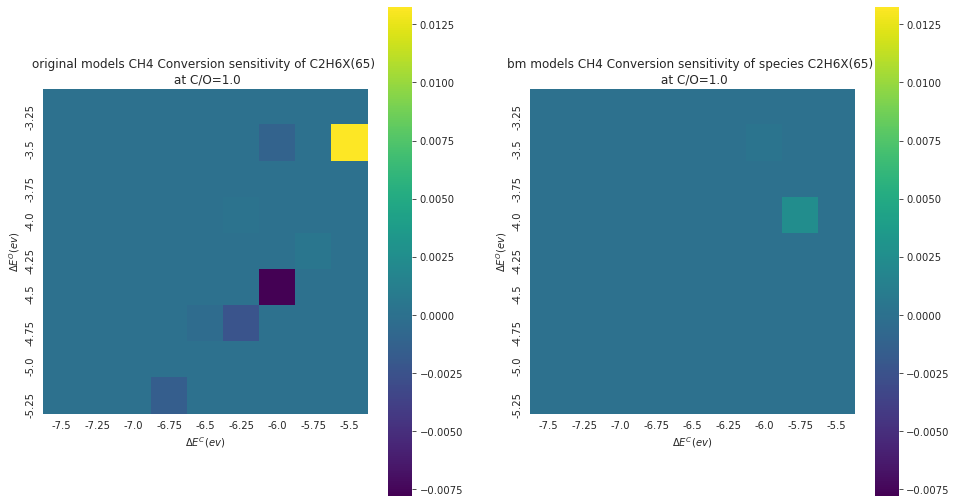

In [17]:
# CH4 conversion
for i in range(1, 20):
    heat_map_gen(i, 8, 1.0, 1)

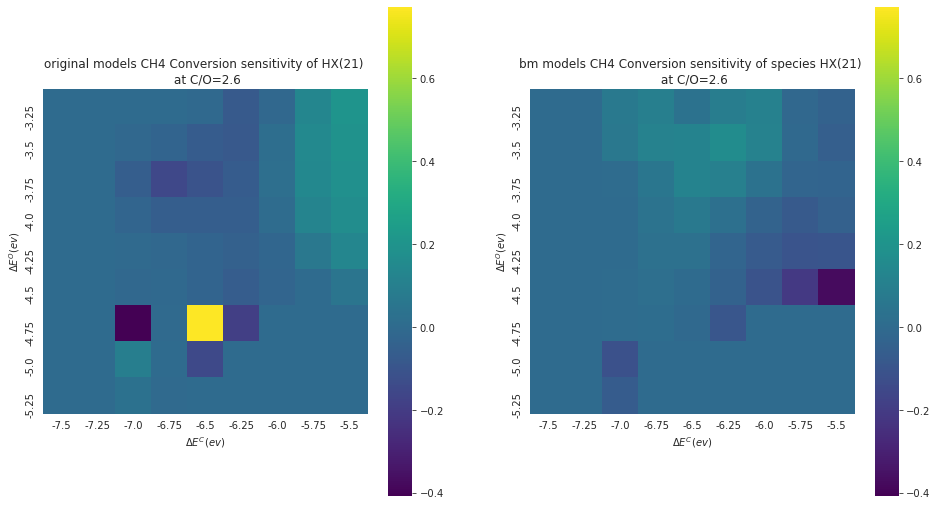

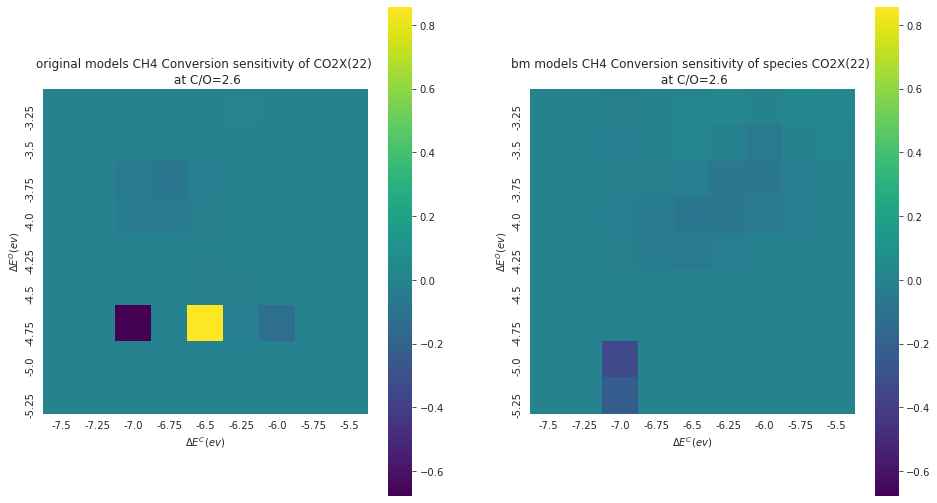

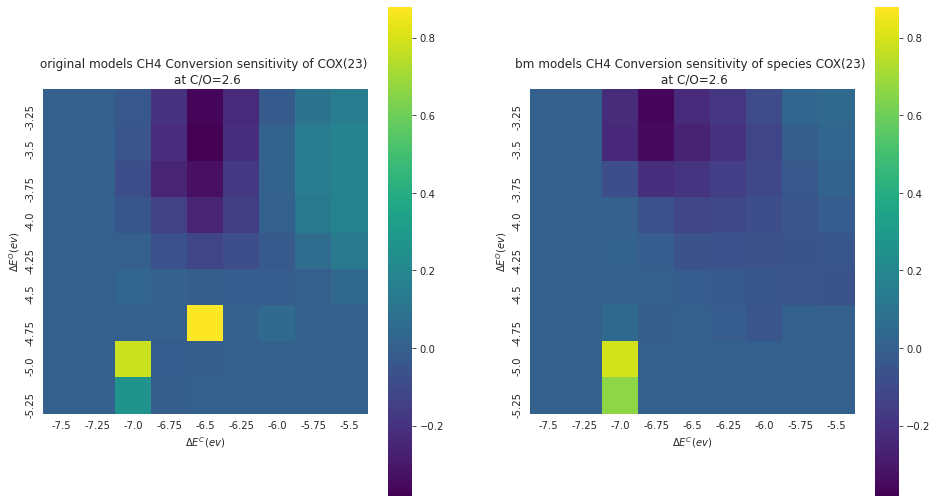

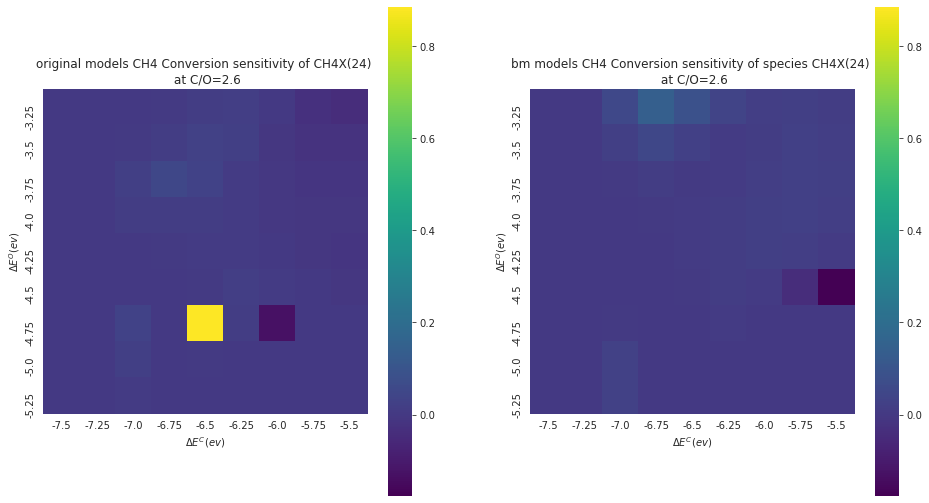

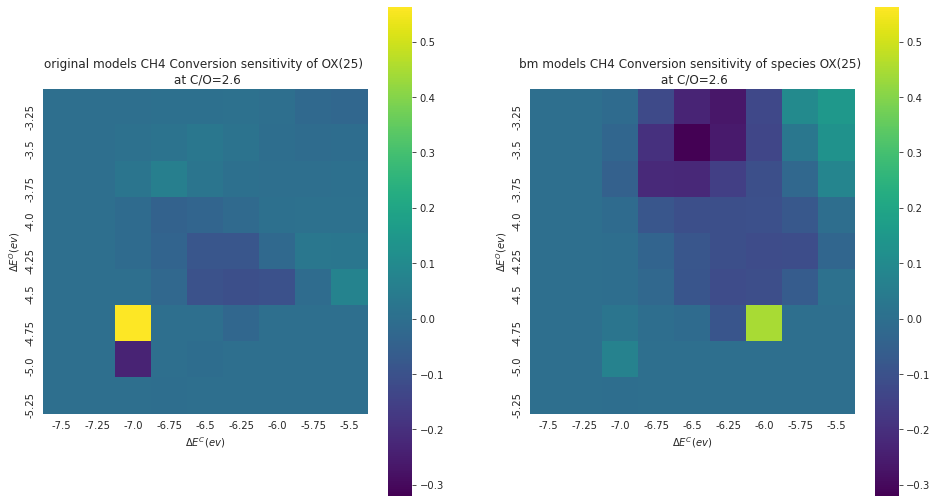

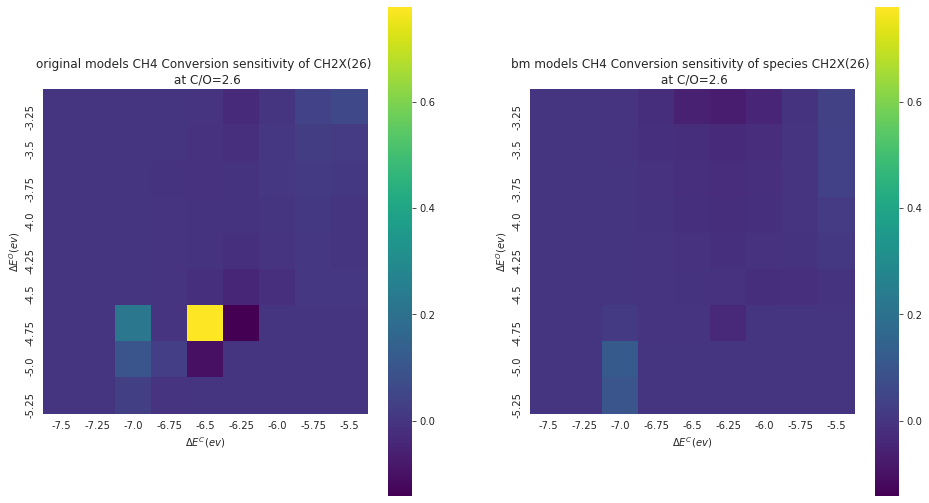

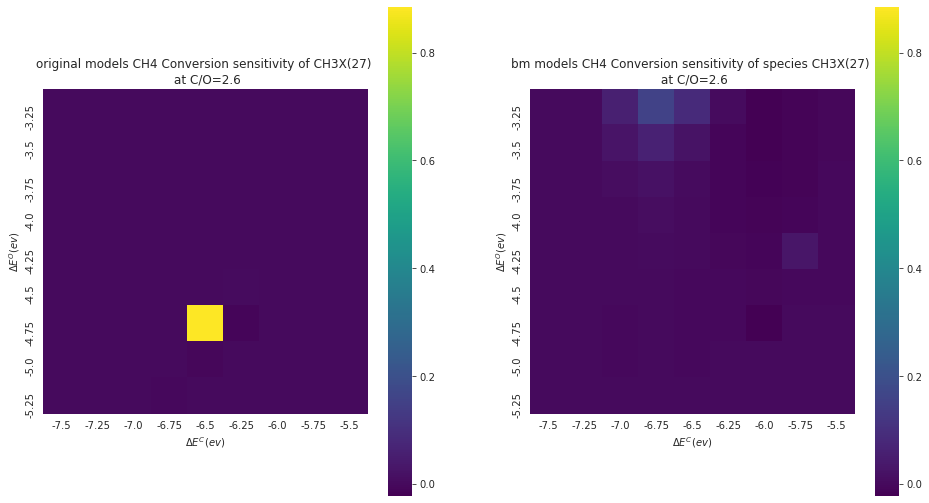

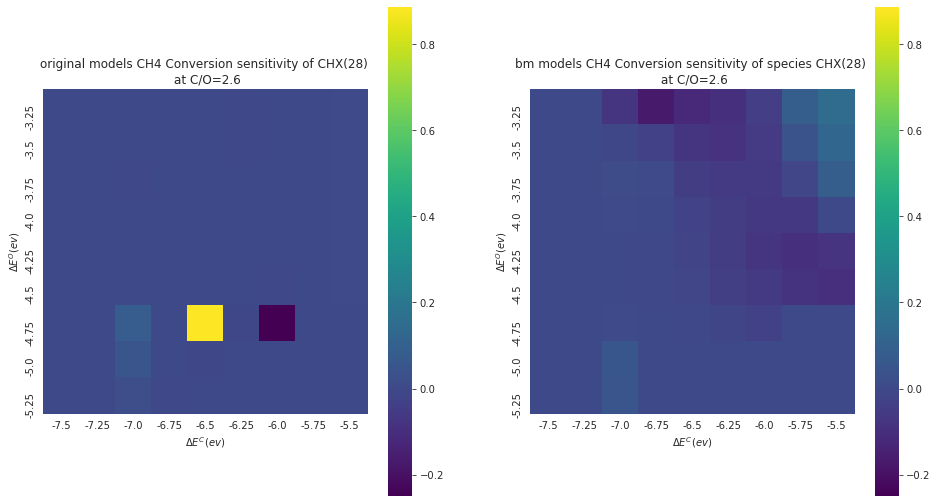

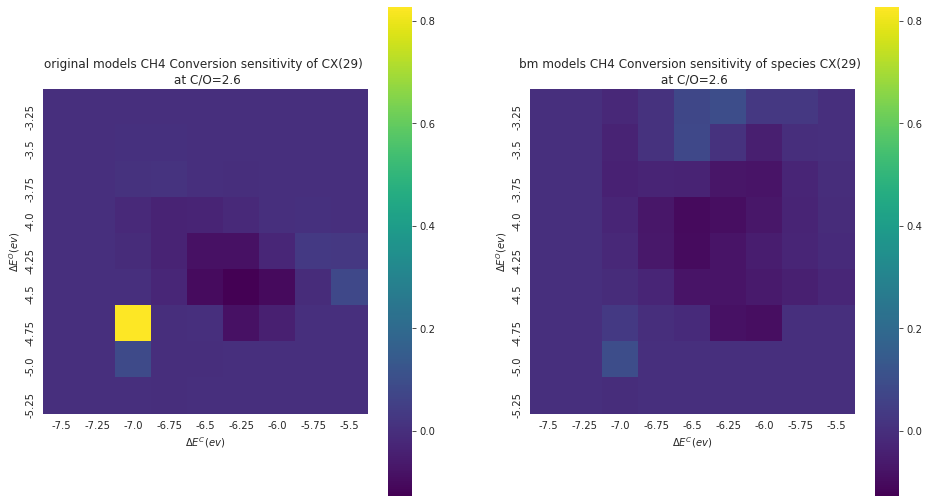

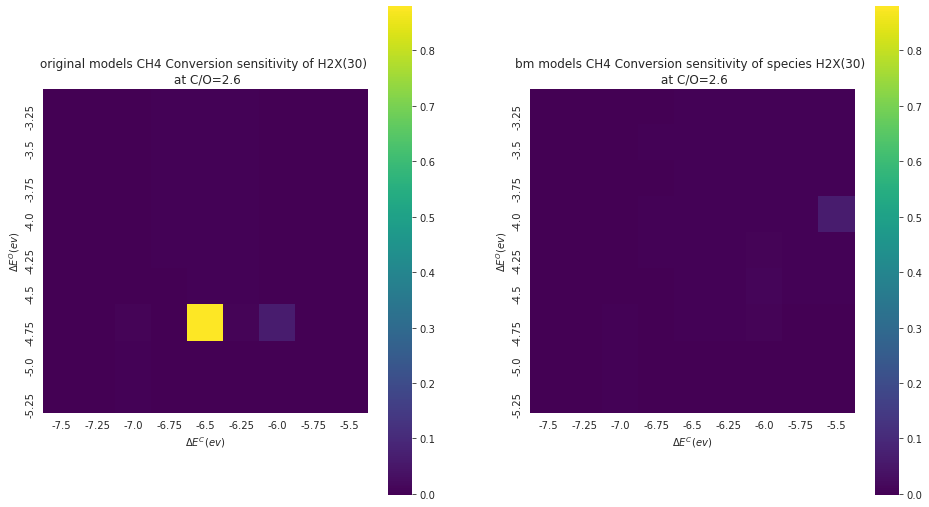

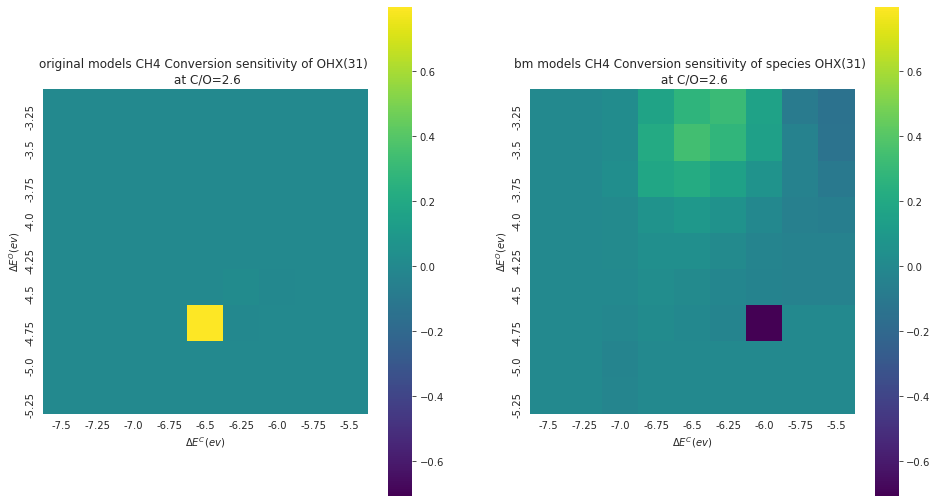

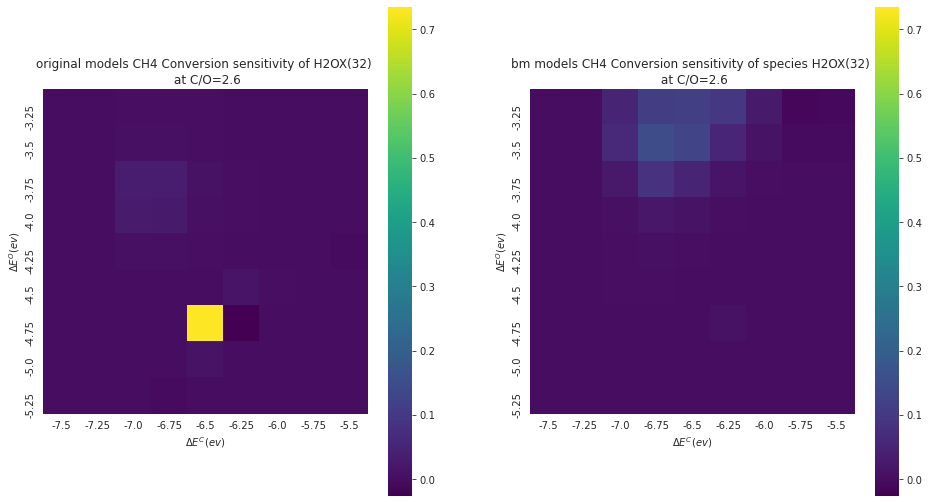

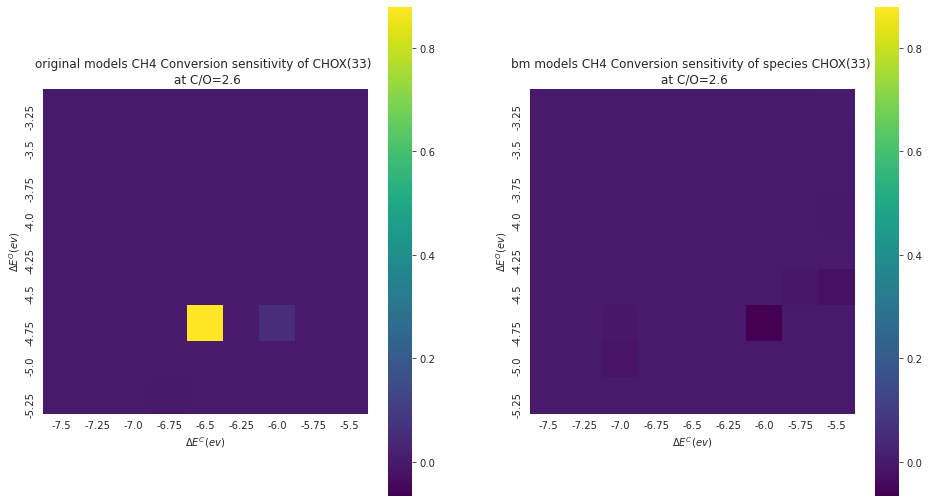

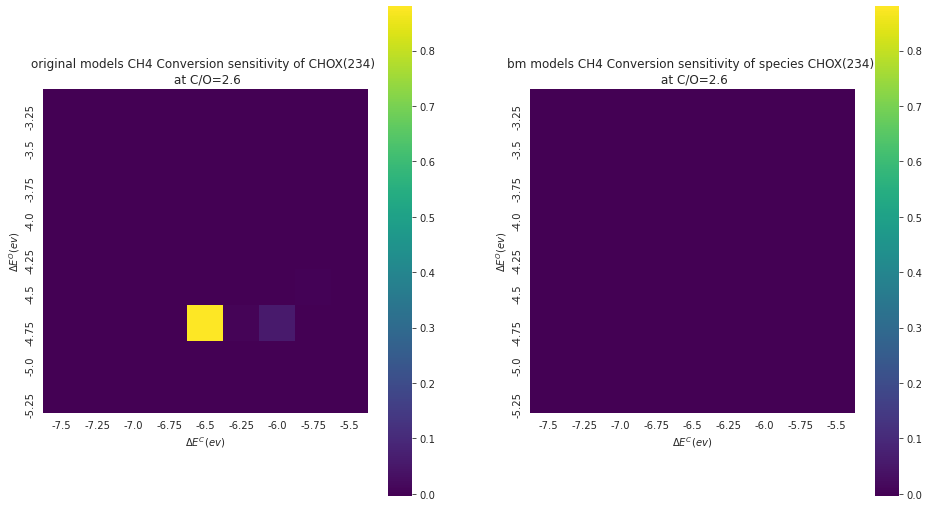

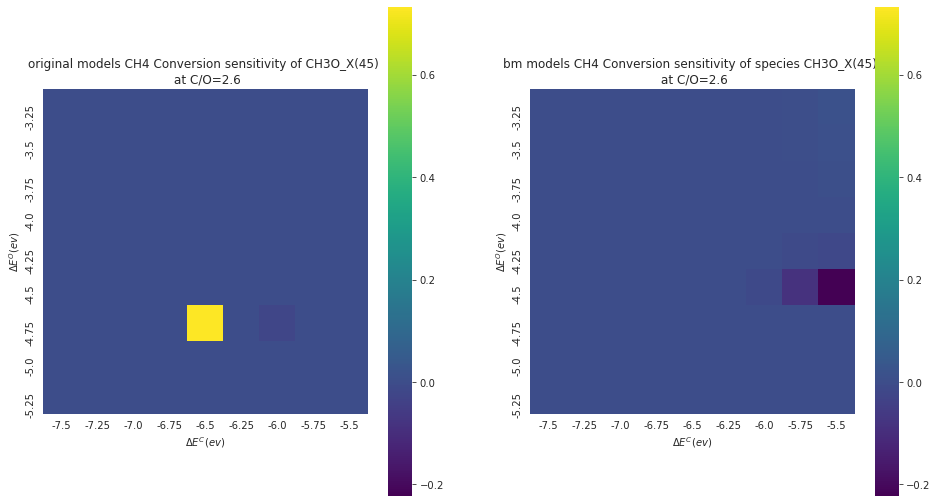

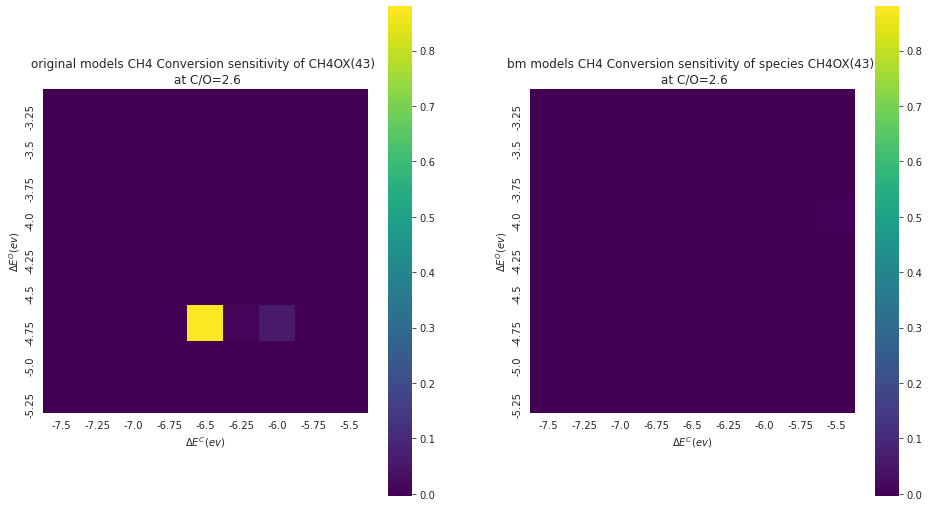

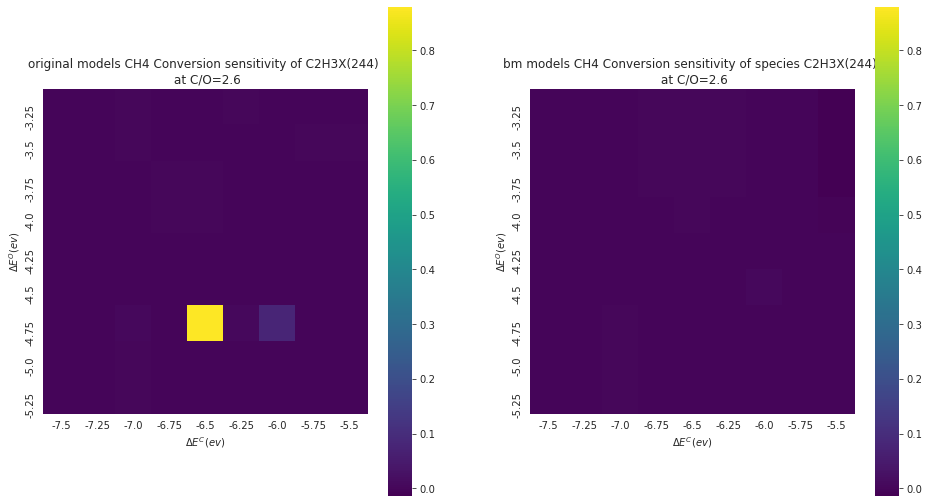

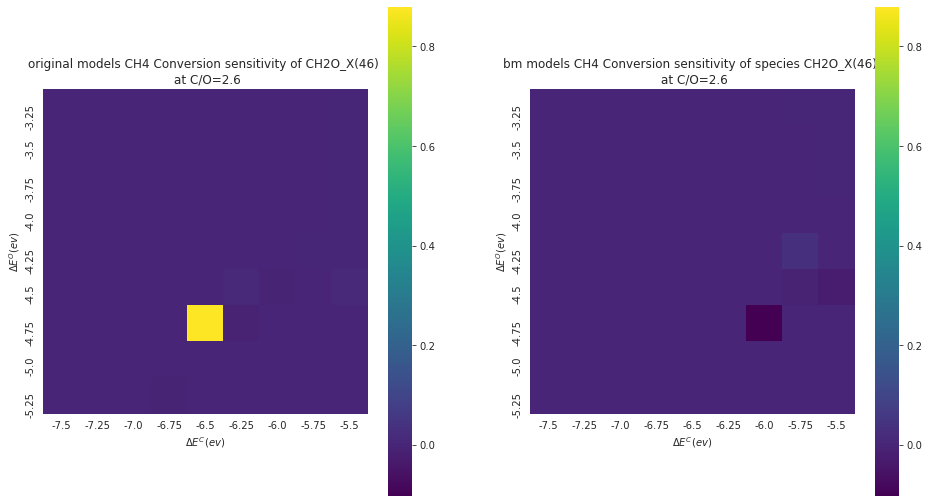

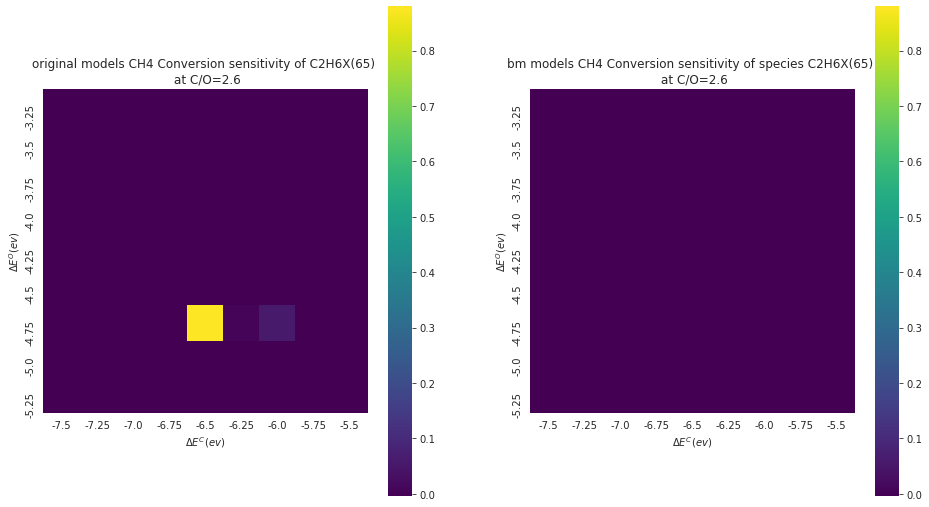

In [20]:
# CH4 conversion
for i in range(1, 20):
    heat_map_gen(i, 8, 2.6, 1)